# Imports / Set up

In [2]:
from __future__ import annotations

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LogNorm
from matplotlib.colors import TwoSlopeNorm
from torch.utils.data import DataLoader

from operator_aliasing.data.utils import get_data
from operator_aliasing.data.utils import get_dataset
from operator_aliasing.models.utils import get_model
from operator_aliasing.train.train import test_model
from operator_aliasing.train.utils import load_latest_ckpt
from operator_aliasing.utils import get_dataset_info
from operator_aliasing.utils import get_energy_curve
from operator_aliasing.utils import get_energy_curve_1d
from operator_aliasing.utils import get_model_preds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device=}')

FIG_DIR = '../figures'

ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'


def str_from_res(resolutions=[0, 1, 0, 0]):
    resolutions = str(resolutions)
    resolutions = resolutions.replace('[', '')
    resolutions = resolutions.replace(']', '')
    resolutions = resolutions.replace(' ', '')
    resolutions = resolutions.replace(',', '_')
    resolutions = resolutions.replace('.', '')
    return resolutions


# dataset params
darcy_forcing_term = 1.0
burger_viscosity = 0.001
comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
seed = 0

device=device(type='cuda')


# Signal Processing Overview Figure

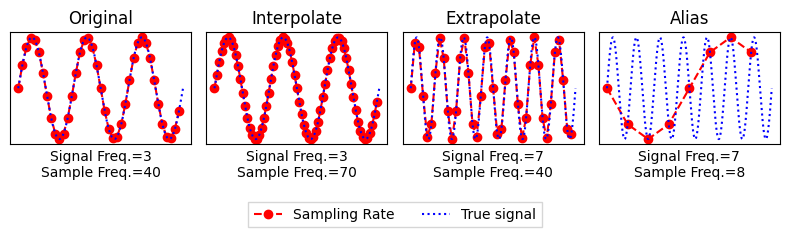

In [196]:
fig, axes = plt.subplots(
    nrows=1, ncols=4, sharey='row', sharex='col', figsize=(8, 2)
)

# original
sample_frequency = 40
sine_frequency = 3
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[0].plot(t, x, '--ro', label='Sampling Rate')
axes[0].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[0].set_title('Original')
axes[0].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# interpolate
sample_frequency = 70
sine_frequency = 3
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[1].plot(t, x, '--ro', label='Sampling Rate')
axes[1].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[1].set_title('Interpolate')
axes[1].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# extrapolate
sample_frequency = 40
sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[2].plot(t, x, '--ro', label='Sampling Rate')
axes[2].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[2].set_title('Extrapolate')
axes[2].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# alias
sample_frequency = 8
# sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
plt.plot(t, x, '--ro', label='Sampling Rate')
plt.plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True Signal',
)
axes[3].set_title('Alias')
axes[3].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

for i in range(4):
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_xticks([])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.0),
    fancybox=False,
    shadow=False,
    ncol=9,
)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/signal_process_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

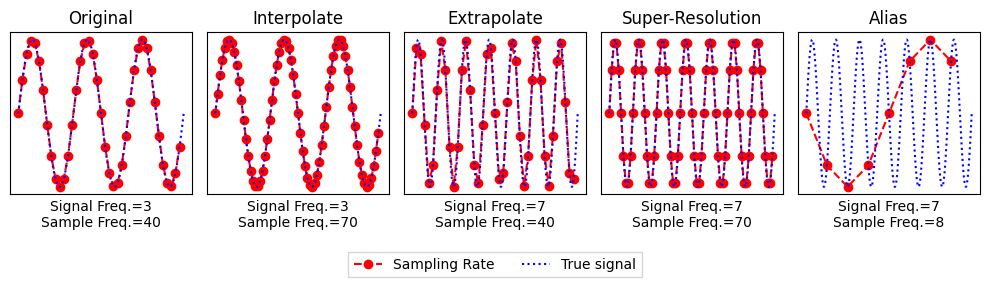

In [201]:
fig, axes = plt.subplots(
    nrows=1, ncols=5, sharey='row', sharex='col', figsize=(10, 2.5)
)

# original
sample_frequency = 40
sine_frequency = 3
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[0].plot(t, x, '--ro', label='Sampling Rate')
axes[0].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[0].set_title('Original')
axes[0].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# interpolate
sample_frequency = 70
sine_frequency = 3
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[1].plot(t, x, '--ro', label='Sampling Rate')
axes[1].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[1].set_title('Interpolate')
axes[1].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# extrapolate
sample_frequency = 40
sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[2].plot(t, x, '--ro', label='Sampling Rate')
axes[2].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[2].set_title('Extrapolate')
axes[2].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# super-res
sample_frequency = 70
# sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[3].plot(t, x, '--ro', label='Sampling Rate')
axes[3].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True Signal',
)
axes[3].set_title('Super-Resolution')
axes[3].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

# alias
sample_frequency = 8
# sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
plt.plot(t, x, '--ro', label='Sampling Rate')
plt.plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True Signal',
)
axes[4].set_title('Alias')
axes[4].set_xlabel(
    f'Signal Freq.={sine_frequency}\nSample Freq.={sample_frequency}'
)

for i in range(5):
    axes[i].get_yaxis().set_visible(False)
    axes[i].set_xticks([])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.0),
    fancybox=False,
    shadow=False,
    ncol=9,
)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/signal_process_overview_w_super_res.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

## Brain storm

(8,)


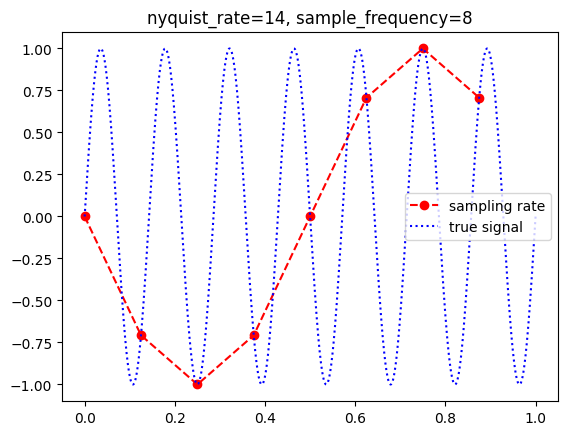

(11,)


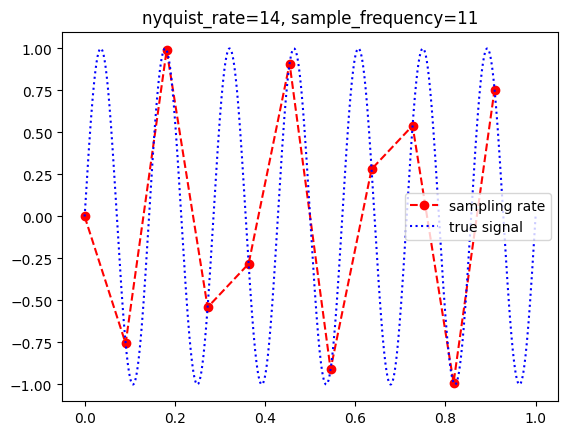

(100,)


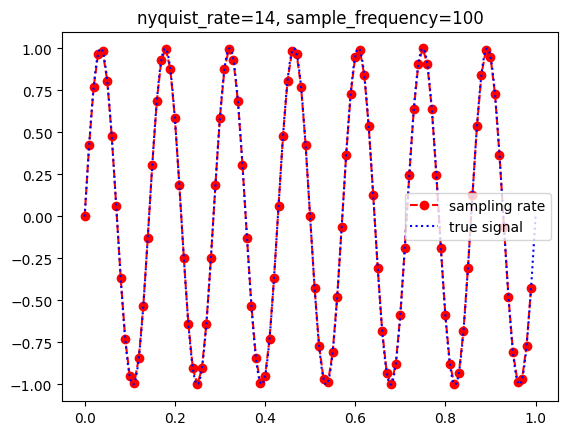

In [115]:
sine_frequency = 7
nyquist_rate = sine_frequency * 2
for sample_frequency in [8, 11, 100]:  # range(1, 100, 10):
    t = np.linspace(0, 1, sample_frequency, endpoint=False)
    print(t.shape)
    x = np.sin(2 * np.pi * sine_frequency * t)
    plt.plot(t, x, '--ro', label='sampling rate')
    plt.plot(
        t2 := np.linspace(0, 1, 10000),
        np.sin(2 * np.pi * sine_frequency * t2),
        'b:',
        label='true signal',
    )
    plt.title(f'{nyquist_rate=}, {sample_frequency=}')
    plt.legend()
    plt.show()

(31,)


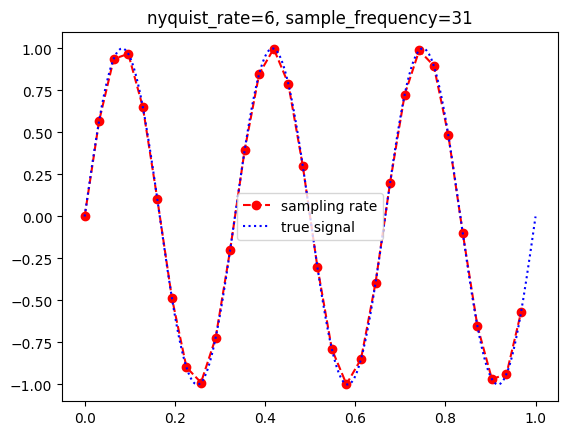

(281,)


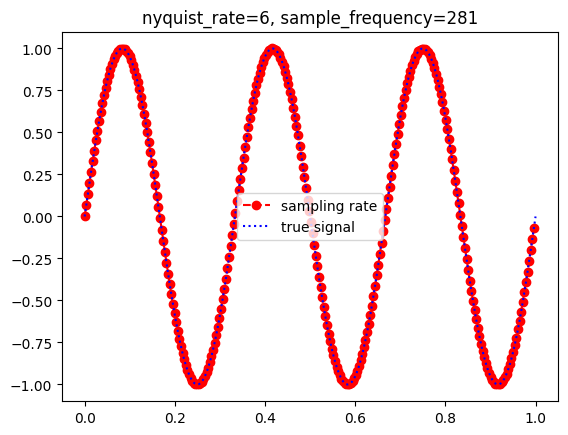

In [84]:
sine_frequency = 3
nyquist_rate = sine_frequency * 2
for sample_frequency in range(31, 500, 250):
    t = np.linspace(0, 1, sample_frequency, endpoint=False)
    print(t.shape)
    x = np.sin(2 * np.pi * sine_frequency * t)
    plt.plot(t, x, '--ro', label='sampling rate')
    plt.plot(
        t2 := np.linspace(0, 1, 10000),
        np.sin(2 * np.pi * sine_frequency * t2),
        'b:',
        label='true signal',
    )
    plt.title(f'{nyquist_rate=}, {sample_frequency=}')
    plt.legend()
    plt.show()

(70,)


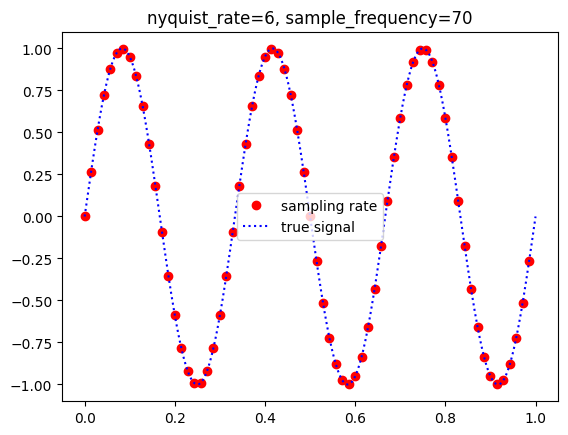

(70,)


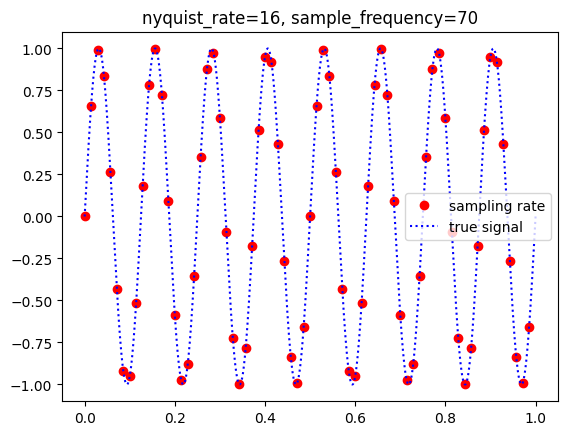

In [93]:
sample_frequency = 70

for sine_frequency in range(3, 10, 5):
    nyquist_rate = sine_frequency * 2
    t = np.linspace(0, 1, sample_frequency, endpoint=False)
    print(t.shape)
    x = np.sin(2 * np.pi * sine_frequency * t)
    plt.plot(t, x, 'ro', label='sampling rate')
    plt.plot(
        t2 := np.linspace(0, 1, 10000),
        np.sin(2 * np.pi * sine_frequency * t2),
        'b:',
        label='true signal',
    )
    plt.title(f'{nyquist_rate=}, {sample_frequency=}')
    plt.legend()
    plt.show()

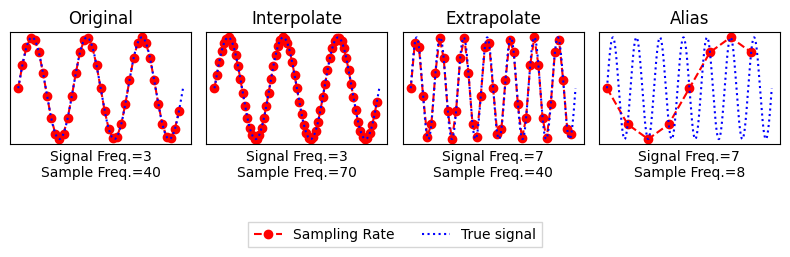

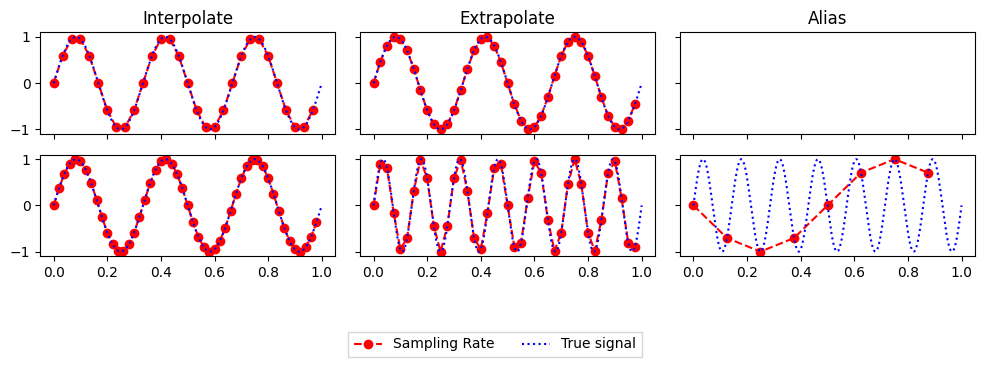

In [167]:
fig, axes = plt.subplots(
    nrows=2, ncols=3, sharey='row', sharex='col', figsize=(10, 3)
)


# interpolate
sample_frequency = 30
sine_frequency = 3
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[0, 0].plot(t, x, '--ro', label='Sampling Rate')
axes[0, 0].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)

sample_frequency = 50
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[1, 0].plot(t, x, '--ro', label='Sampling Rate')
axes[1, 0].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[0, 0].set_title('Interpolate')

# extrapolate
sample_frequency = 40
sine_frequency = 3
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[0, 1].plot(t, x, '--ro', label='Sampling Rate')
axes[0, 1].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)

sample_frequency = 40
sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
axes[1, 1].plot(t, x, '--ro', label='Sampling Rate')
axes[1, 1].plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True signal',
)
axes[0, 1].set_title('Extrapolate')

# alias
sample_frequency = 8
# sine_frequency = 7
t = np.linspace(0, 1, sample_frequency, endpoint=False)
x = np.sin(2 * np.pi * sine_frequency * t)
plt.plot(t, x, '--ro', label='Sampling Rate')
plt.plot(
    t2 := np.linspace(0, 1, 10000),
    np.sin(2 * np.pi * sine_frequency * t2),
    'b:',
    label='True Signal',
)
axes[0, 2].set_title('Alias')

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    fancybox=False,
    shadow=False,
    ncol=9,
)
plt.tight_layout()
plt.show()

# Aliasing Overview
TODO: redo w/ newly trained model

3 rows (1st: sample img, 2nd, avg label+avg model pred spectrum, 3rd avg residual spectrum)
- 2nd and 3rd row can be smaller than the first one

In [10]:
# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)

dataset = get_dataset(
    dataset_name=dataset_name,
    filter_lim=-1,
    img_size=128,
    downsample_dim=-1,
    train=False,
    initial_steps=initial_steps,
    model_name=model_name,
    darcy_forcing_term=darcy_forcing_term,
    burger_viscosity=burger_viscosity,
    batch_size=128,
    seed=0,
    resolution_ratios=[0, 1, 0, 0],
)

dataset[0]['x'].shape

resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000


torch.Size([128, 1, 64, 64])

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


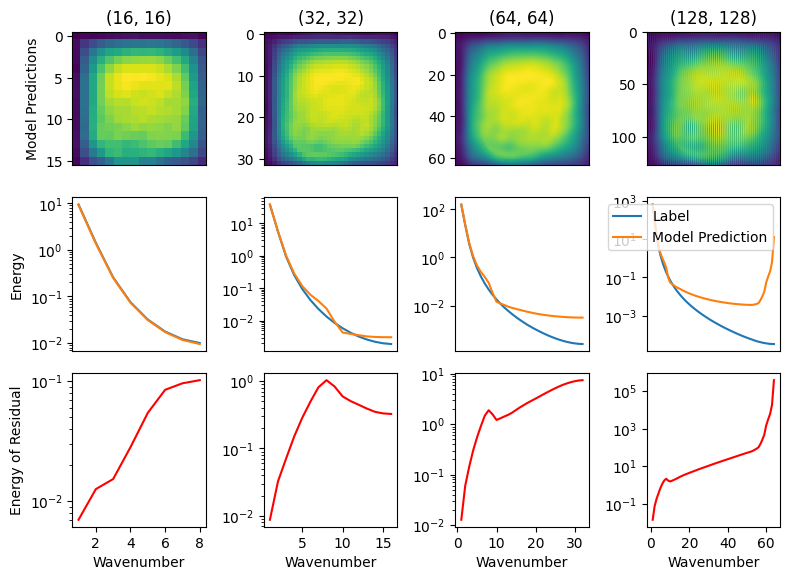

In [22]:
fig, axs = plt.subplots(3, 4, figsize=(8, 6))


# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)

# ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0, 0, 0, 1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx + 1)] = 1
    resolutions = [16, 32, 64, 128]  # [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )
    # sample = dataset[0]
    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    axs[0, x_idx].imshow(output)
    # axs[3, x_idx].imshow(output-label)
    axs[0, x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    # axs[0, x_idx].get_yaxis().set_visible(False)
    axs[0, x_idx].get_xaxis().set_visible(False)
    axs[1, x_idx].get_xaxis().set_visible(False)

    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    residual_spectrum = get_energy_curve(residuals)

    axs[1, x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    axs[1, x_idx].plot(x, label_spectrum, label='Label')
    axs[1, x_idx].plot(x, pred_spectrum, label='Model Prediction')

    axs[2, x_idx].set_yscale('log')
    axs[2, x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    axs[2, x_idx].set_xlabel('Wavenumber')
    # plt.locator_params(axis="x", integer=True, tight=True)
    axs[2, x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    if x_idx == 0:
        axs[2, x_idx].set_ylabel('Energy of Residual')
        axs[1, x_idx].set_ylabel('Energy')
        axs[0, x_idx].set_ylabel('Model Predictions')
        # axs[3, x_idx].set_ylabel('Residual')

axs[1, x_idx].legend(loc='upper right')
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


/tmp/ipykernel_469259/2053484167.py:120: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


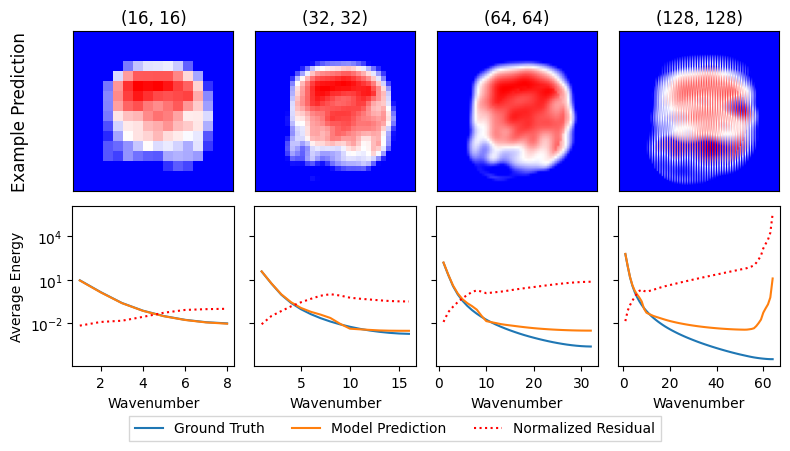

In [35]:
# fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(8, 3.5))
subfigs = fig.subfigures(2, 1, wspace=0.07)  # three rows

img_axs = subfigs[0].subplots(1, 4, sharey=False)
spectrum_axs = subfigs[1].subplots(1, 4, sharey='row')
# residual_axs = subfigs[2].subplots(1, 4, sharey='row')

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)

# ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0, 0, 0, 1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx + 1)] = 1
    resolutions = [16, 32, 64, 128]  # [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )
    # sample = dataset[0]
    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    # get spectrums
    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    residual_spectrum = get_energy_curve(residuals)

    img = output  # - label
    norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
    img_axs[x_idx].imshow(img, norm=norm, cmap='bwr')
    img_axs[x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    img_axs[x_idx].get_yaxis().set_visible(False)
    img_axs[x_idx].get_xaxis().set_visible(False)
    subfigs[0].supylabel('Example Prediction')
    # img_axs[x_idx].set_ylabel('Model Predictions')

    spectrum_axs[x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    spectrum_axs[x_idx].plot(x, label_spectrum, label='Ground Truth')
    spectrum_axs[x_idx].plot(x, pred_spectrum, label='Model Prediction')
    spectrum_axs[x_idx].plot(
        x,
        residual_spectrum / label_spectrum,
        linestyle=':',
        label='Normalized Residual',
        color='red',
    )
    spectrum_axs[0].set_ylabel('Average Energy')
    spectrum_axs[x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )
    spectrum_axs[x_idx].set_xlabel('Wavenumber')
    """
    residual_axs[x_idx].set_yscale('log')
    residual_axs[x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    residual_axs[x_idx].set_xlabel('Wavenumber')
    residual_axs[0].set_ylabel('Energy of Residual')
    """

handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.1),
    fancybox=False,
    shadow=False,
    ncol=9,
)
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000


/tmp/ipykernel_1010912/1582236672.py:156: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


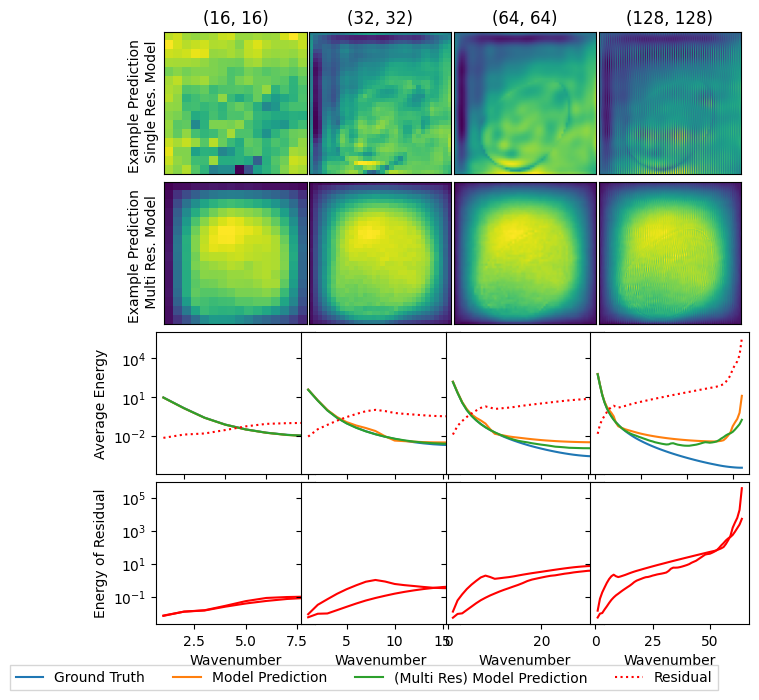

In [24]:
# fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(8, 6))
subfigs = fig.subfigures(4, 1, wspace=0.07)  # three rows

img_axs = subfigs[0].subplots(1, 4, sharey=False)
multi_axs = subfigs[1].subplots(1, 4, sharey=False)
spectrum_axs = subfigs[2].subplots(1, 4, sharey='row')
residual_axs = subfigs[3].subplots(1, 4, sharey='row')

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
# grab trained model
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)


# ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
resolutions = str_from_res([0, 0, 0, 1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
print(ckpt_dir)
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()


multi_model = get_model(
    model_name=model_name,
    max_modes=128 // 2,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)
multi_res_dir = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_01_01_01_07/'
multi_res_dir = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/'
ckpt_dict = load_latest_ckpt(multi_res_dir)
multi_model.load_state_dict(ckpt_dict['model_state_dict'])
multi_model = multi_model.to(device)
multi_model = multi_model.eval()

for x_idx, res in enumerate([16, 32, 64, 128]):
    resolution_ratio = [0, 0, 0, 0]
    resolution_ratio[-(x_idx + 1)] = 1
    resolutions = [16, 32, 64, 128]  # [128, 64, 32, 16]
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size=res,
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=resolution_ratio,
    )

    sample = {
        'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }
    # grab a single input from the last batch
    model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
    with torch.no_grad():
        model_output = model(x=model_input)
        multi_model_output = multi_model(x=model_input)
    ground_truth = sample['y']  # .unsqueeze(dim=0)
    residuals = model_output - ground_truth.to(
        device
    )  # / ground_truth.to(device)
    multi_residuals = multi_model_output - ground_truth.to(device)

    # convert to plotable form
    model_in = model_input[0, 0, :, :].cpu().numpy()
    output = model_output[0, 0, :, :].cpu().numpy()
    multi_output = multi_model_output[0, 0, :, :].cpu().numpy()
    label = ground_truth[0, 0, :, :].cpu().numpy()

    # get spectrums
    label_spectrum = get_energy_curve(ground_truth)
    pred_spectrum = get_energy_curve(model_output)
    multi_pred_spectrum = get_energy_curve(multi_model_output)
    residual_spectrum = get_energy_curve(residuals)
    multi_residual_spectrum = get_energy_curve(multi_residuals)

    img = output - label
    norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
    img_axs[x_idx].imshow(img)  # norm=norm, cmap='bwr')
    img_axs[x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    # img_axs[x_idx].get_yaxis().set_visible(False)
    img_axs[x_idx].set_yticks([])
    img_axs[x_idx].get_xaxis().set_visible(False)
    # subfigs[0].supylabel("Example Prediction")
    img_axs[0].set_ylabel('Example Prediction \n Single Res. Model')

    img = multi_output  # - label
    # norm = colors.LogNorm(img.mean() + 0.5 * img.std(), img.max(), clip='True')
    multi_axs[x_idx].imshow(img)  # norm=norm, cmap='bwr')
    # img_axs[x_idx].set_title(f'{(resolutions[x_idx], resolutions[x_idx])}')
    multi_axs[x_idx].set_yticks([])
    multi_axs[x_idx].get_xaxis().set_visible(False)
    multi_axs[0].set_ylabel('Example Prediction \n Multi Res. Model')

    spectrum_axs[x_idx].set_yscale('log')
    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    spectrum_axs[x_idx].plot(x, label_spectrum, label='Ground Truth')
    spectrum_axs[x_idx].plot(x, pred_spectrum, label='Model Prediction')
    spectrum_axs[x_idx].plot(
        x, multi_pred_spectrum, label='(Multi Res) Model Prediction'
    )
    spectrum_axs[x_idx].plot(
        x,
        residual_spectrum / label_spectrum,
        linestyle=':',
        label='Residual',
        color='red',
    )
    spectrum_axs[0].set_ylabel('Average Energy')
    spectrum_axs[x_idx].xaxis.set_major_locator(
        ticker.MaxNLocator(integer=True, nbins=4)
    )

    residual_axs[x_idx].set_yscale('log')
    residual_axs[x_idx].plot(
        x, residual_spectrum / label_spectrum, label='Resid', color='red'
    )
    residual_axs[x_idx].plot(
        x,
        multi_residual_spectrum / label_spectrum,
        label='(Multi Res) Resid',
        color='red',
    )
    residual_axs[x_idx].set_xlabel('Wavenumber')
    residual_axs[0].set_ylabel('Energy of Residual')


handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fancybox=False,
    shadow=False,
    ncol=9,
)
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/aliasing_overview_experiment.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

In [26]:
img

array([[0.0017174 , 0.00312961, 0.00435727, ..., 0.00435875, 0.00313063,
        0.00171792],
       [0.00312959, 0.00583334, 0.00823188, ..., 0.00823491, 0.00583543,
        0.00313065],
       [0.00435718, 0.00823177, 0.01172588, ..., 0.01173058, 0.008235  ,
        0.00435882],
       ...,
       [0.00466121, 0.00884139, 0.01264418, ..., 0.01188501, 0.00833757,
        0.00440999],
       [0.00333318, 0.00624156, 0.00884683, ..., 0.00833831, 0.0059041 ,
        0.00316491],
       [0.00181946, 0.00333427, 0.00466556, ..., 0.00441058, 0.00316506,
        0.00173509]], dtype=float32)

In [ ]:
# Average Error Spectrum (Figure 2)

# grab trained model
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'
seed = 0
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, loss)
max_mode = 8
model = get_model(
    model_name=model_name,
    max_modes=max_mode,
    hidden_channels=32,
    in_channels=in_channels,
    out_channels=out_channels,
)
resolutions = str_from_res([0, 0, 0, 1])
ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
ckpt_dir = str(ckpt_dir).replace('.', '')
ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
ckpt_dict = load_latest_ckpt(ckpt_pth)
model.load_state_dict(ckpt_dict['model_state_dict'])
model = model.to(device)
model = model.eval()

fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey='row')
train_loader, test_loaders = get_data(
    dataset_name=dataset_name,
    filter_lim=filter_lim,
    img_size=s,
    downsample_dim=downsample_dim,
    train=False,
    initial_steps=initial_steps,
    model_name=model_name,
    darcy_forcing_term=darcy_forcing_term,
    burger_viscosity=burger_viscosity,
    seed=seed,
    batch_size=batch_size,
    resolution_ratios=resolution_ratio,
    test_res='multi',
)
for idx, s in enumerate([128, 64, 32, 16]):
    test_loader = test_loaders[f'test_res_{idx}']
    dataset = test_loader.dataset
    # squeeze the dataset to remove the empty channel dimension
    model_preds_test = get_model_preds(
        test_loader, model, device, initial_steps
    ).squeeze()
    shape = model_preds_test.shape
    sample = {
        #'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
        'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
    }

    ground_truth = sample['y']
    residuals = model_preds_test.to('cpu') - ground_truth

    test_sp_y = get_energy_curve(ground_truth, s)

    residual_spectrum = get_energy_curve(residuals, s)

    # Configure pyplot and generate the plot
    ax.set_yscale('log')
    x = np.linspace(1, s // 2, s // 2)
    ax.plot(
        # abs(test_sp_model_pred - test_sp_y) / test_sp_y,
        x,
        residual_spectrum / test_sp_y,
        linestyle='-',
        label=f'Res {s}',
    )
    ax.axvline(x=8, color='grey', linestyle='--')

    fig.suptitle(f'{dataset_name} Dataset')

fig.supxlabel('Wavenumber')
fig.supylabel('Energy of Residual \n (Pred - Label)')

# show the figure
leg = plt.legend(loc='best')
leg.get_frame().set_alpha(0.5)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/higher_res_residual_spectrum.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=9000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


# Show the turbulence (power spectra of all our datasets)

TODO
- Do this w/ error bars for the time-varying data
- Add additional power spectra for varying NS (compressible settings)

NOTE: for compressible NS, I am just showing the spectrum of a single field (X Velocity)

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


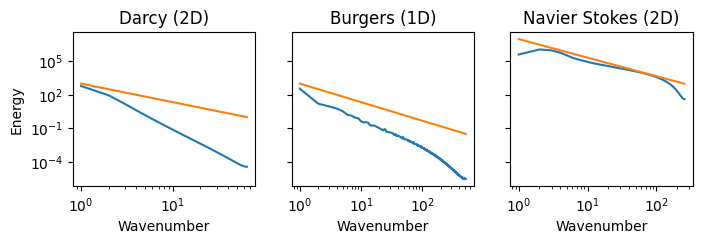

In [4]:
fig, axs = plt.subplots(1, 3, sharey='row', figsize=(8, 2))

for x_idx, dataset_name in enumerate(
    [
        'darcy_pdebench',
        'burgers_pdebench',
        'incomp_ns_pdebench',  # 'ns_pdebench'
    ]
):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    img_size = 510
    title = 'Navier Stokes (2D)'

    powerlaw_coeffs = [1e3, 1e3, 1e7, 1e5]
    if dataset_name == 'ns_pdebench':
        img_size = 512
        title = 'Compressible NS'

    if dataset_name == 'darcy_pdebench':
        img_size = 128
        title = 'Darcy (2D)'

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        title = 'Burgers (1D)'
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, 'mse')

    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
    seed = 0

    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=-1,
        img_size='na',
        downsample_dim=-1,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        batch_size=128,
        seed=0,
        resolution_ratios=[1, 0, 0, 0],
        comp_ns_params=comp_ns_params,
        loss_name='na',
    )
    labels = torch.concat([dataset[i]['y'] for i in range(len(dataset))])
    if dataset_name == 'ns_pdebench':
        labels = labels[
            :, :, 2, ...
        ]  # choose specific channel [density, pressure, X Vel, Y Vel]
    label_spectrum = energy_curve_func(labels)

    x = np.linspace(1, len(label_spectrum), len(label_spectrum))
    axs[x_idx].plot(x, label_spectrum)
    axs[x_idx].plot(
        x, powerlaw_coeffs[x_idx] * x ** (-5 / 3)
    )  # on a log-log plot a linear relationship y=mx + b == c * x ^ (m)
    axs[x_idx].set_yscale('log')
    axs[x_idx].set_xscale('log')
    axs[x_idx].set_title(title)
    axs[x_idx].set_xlabel('Wavenumber')
    if x_idx == 0:
        axs[x_idx].set_ylabel('Energy')

2d energy
dataset_name='ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
loaded density, density.shape=(1000, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 32, 32)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 16, 16)
loaded pressure
loaded Vx
loaded Vy
2d energy
dataset_name='ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
loaded density, density.shape=(1000, 21, 128, 128)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 64, 64)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 32, 32)
loaded pressure
loaded Vx
loaded Vy
loaded density, density.shape=(0, 21, 16, 16)
loaded pressure
loaded Vx
loaded Vy


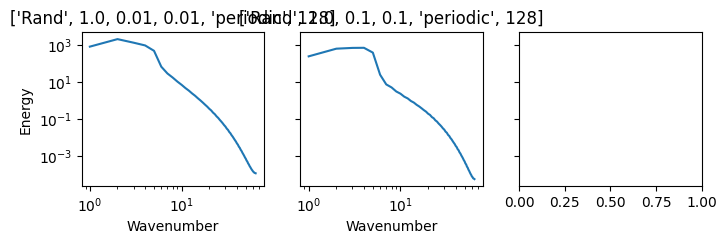

In [13]:
# compare the many compressible NS methods
fig, axs = plt.subplots(1, 3, sharey='row', figsize=(8, 2))

for x_idx, comp_ns_params in enumerate(
    [
        # ['Rand', 1.0, 1e-08, 1e-08, 'periodic', 512],
        ['Rand', 1.0, 1e-02, 1e-02, 'periodic', 128],
        ['Rand', 1.0, 1e-01, 1e-01, 'periodic', 128],
    ]
):
    for dataset_name in ['ns_pdebench']:
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve

        print(f'{dataset_name=}')
        batch_size = 128
        batch_size = 128
        in_channels = 10
        out_channels = 1
        initial_steps = 10
        filter_lim = -1
        downsample_dim = -1

        model_name = 'FNO2D'
        darcy_forcing_term = 1.0
        burger_viscosity = 0.001
        seed = 0

        if dataset_name == 'ns_pdebench':
            batch_size = 4
            in_channels = 40
            out_channels = 4
            title = 'Compressible NS'

        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=128,
            seed=0,
            resolution_ratios=[1, 0, 0, 0],
            comp_ns_params=comp_ns_params,
        )
        labels = torch.concat([dataset[i]['y'] for i in range(len(dataset))])
        if dataset_name == 'ns_pdebench':
            labels = labels[
                :, :, 2, ...
            ]  # choose specific channel [density, pressure, X Vel, Y Vel]
        label_spectrum = energy_curve_func(labels)

        x = np.linspace(1, len(label_spectrum), len(label_spectrum))
        axs[x_idx].plot(x, label_spectrum)
        axs[x_idx].set_yscale('log')
        axs[x_idx].set_xscale('log')
        axs[x_idx].set_title(comp_ns_params)
        axs[x_idx].set_xlabel('Wavenumber')
        if x_idx == 0:
            axs[x_idx].set_ylabel('Energy')

## Visualize Burgers + Incomp NS

Looking for turbulence: vis + energy spectrum

TODO: https://github.com/pdebench/PDEBench/blob/main/pdebench/data_download/visualize_pdes.py#L168

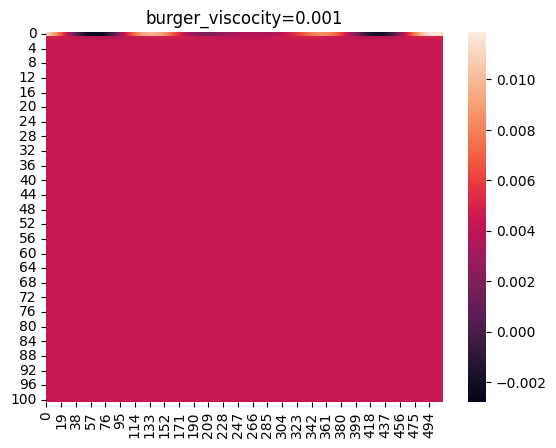

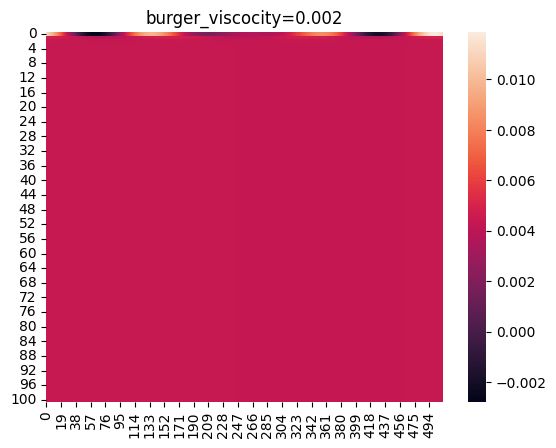

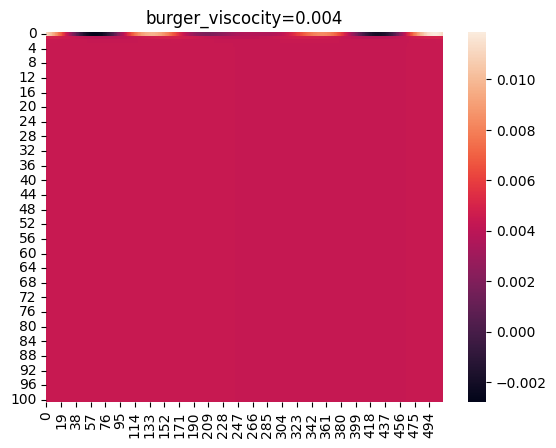

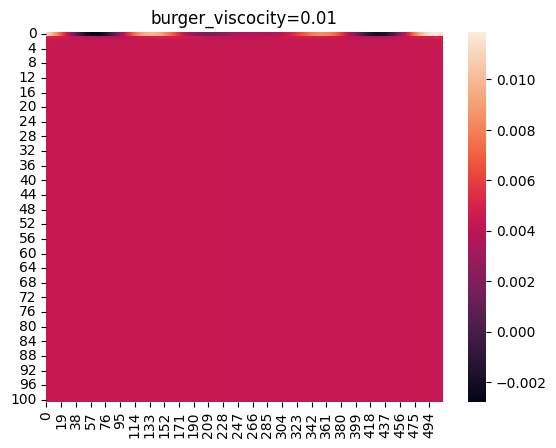

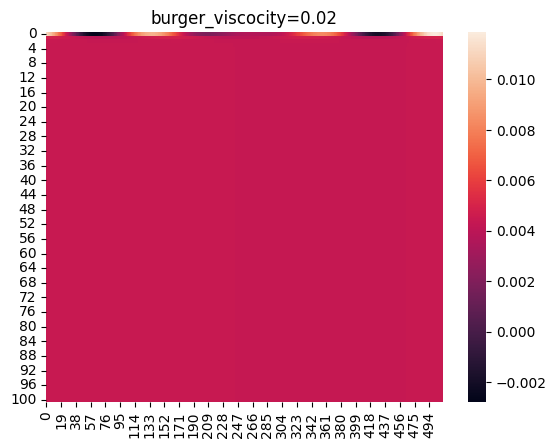

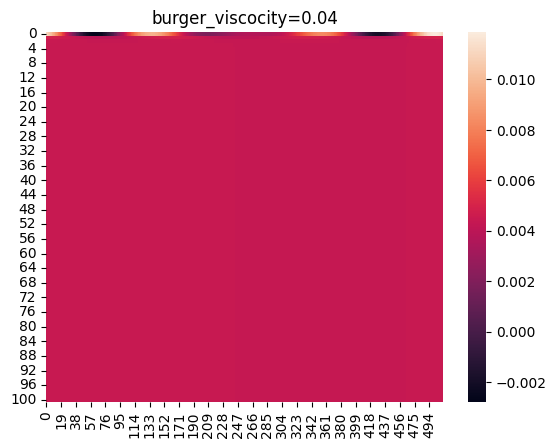

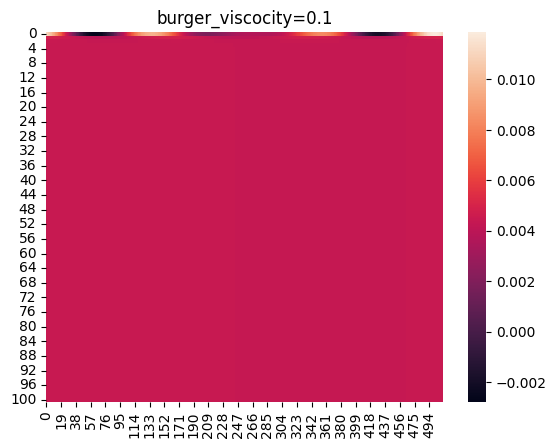

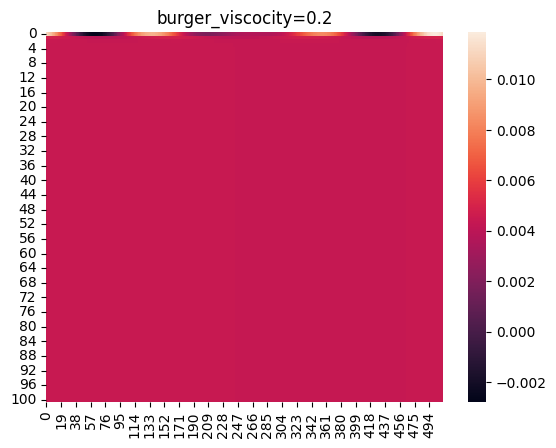

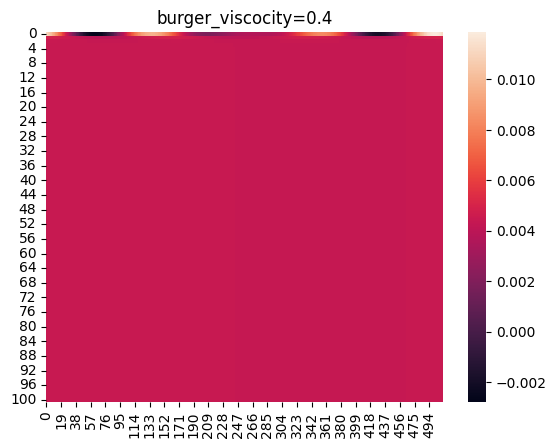

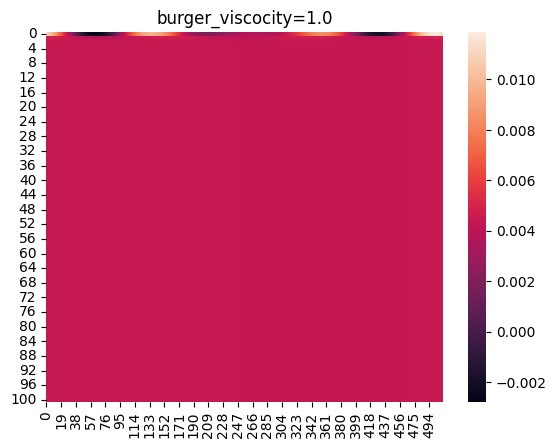

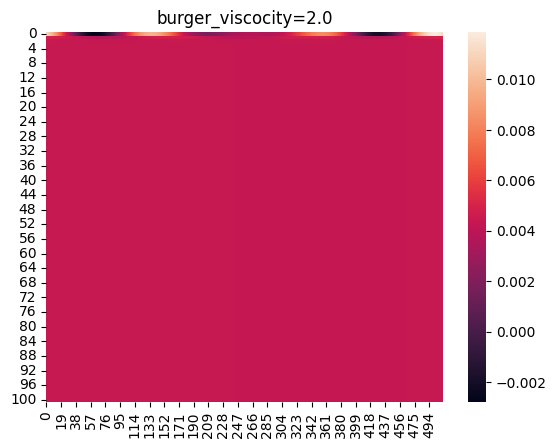

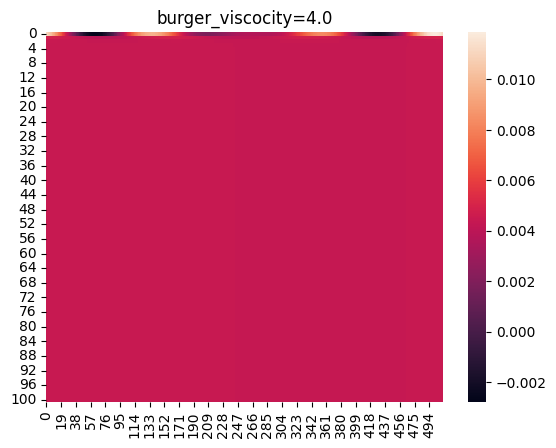

In [46]:
# vis burgers at different visocity coeffs

dataset_name = 'burgers_pdebench'
img_size = 512
max_mode = img_size // 2
in_channels = 1
out_channels = 1
initial_steps = 1
filter_lim = -1
downsample_dim = -1
model_name = 'FNO2D'
darcy_forcing_term = 1.0
burger_viscosity = 1.0

for burger_viscocity in [
    0.001,
    0.002,
    0.004,
    0.01,
    0.02,
    0.04,
    0.1,
    0.2,
    0.4,
    1.0,
    2.0,
    4.0,
]:
    dataset = get_dataset(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size=img_size,
        downsample_dim=downsample_dim,
        train=False,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
    )
    x = dataset[100]['y'].squeeze()
    norm1 = x / np.linalg.norm(x)
    # plt.imshow(norm1)
    # plt.colorbar(orientation='horizontal')
    sns.heatmap(norm1)

    plt.title(f'{burger_viscocity=}')
    plt.show()

# HP Search

Find optimial HP config for darcy, burgers, and incompressible navier stokes, and compressible navier stokes

TODO: select best models!

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


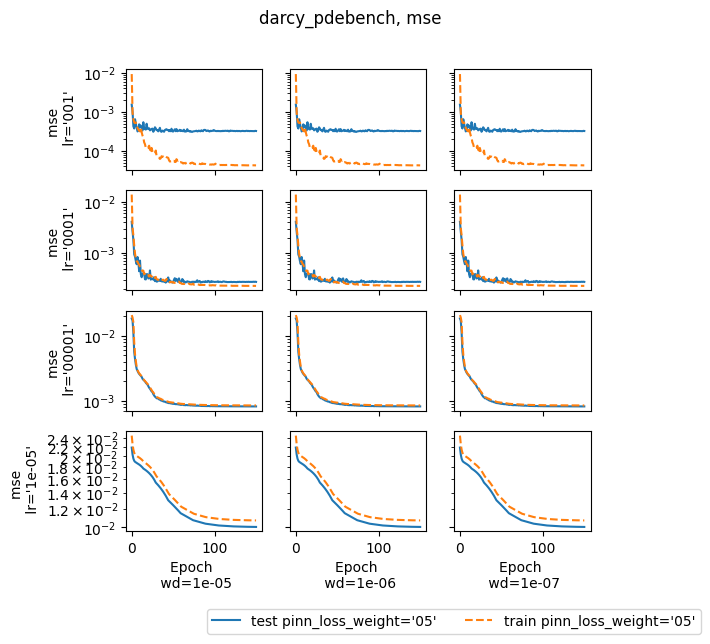

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


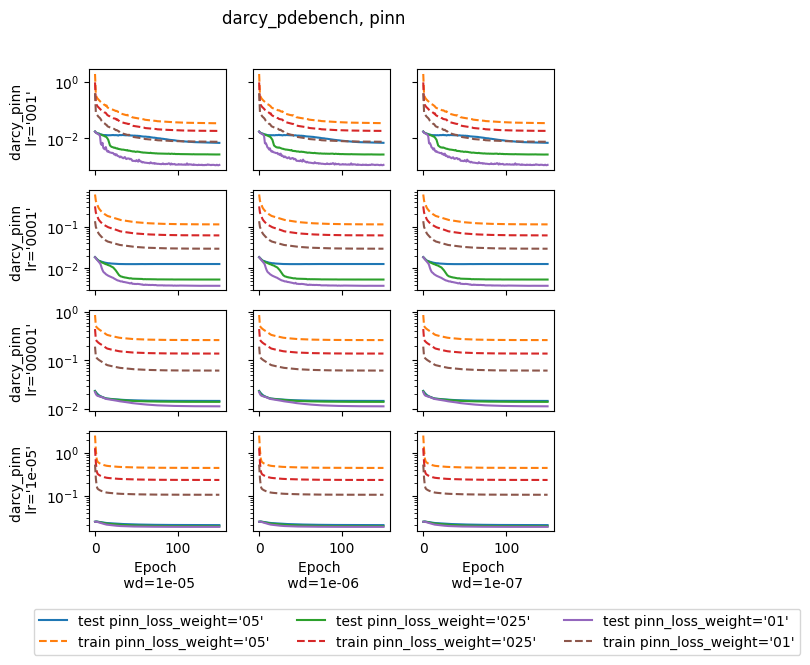

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


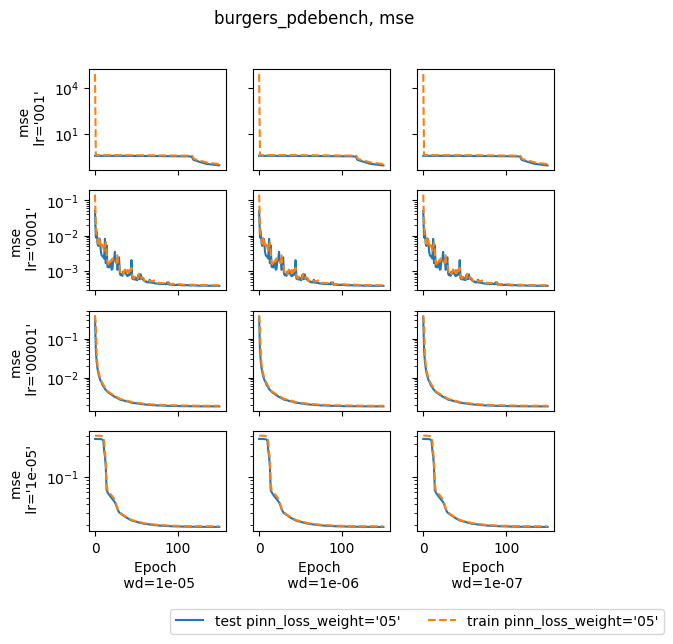

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


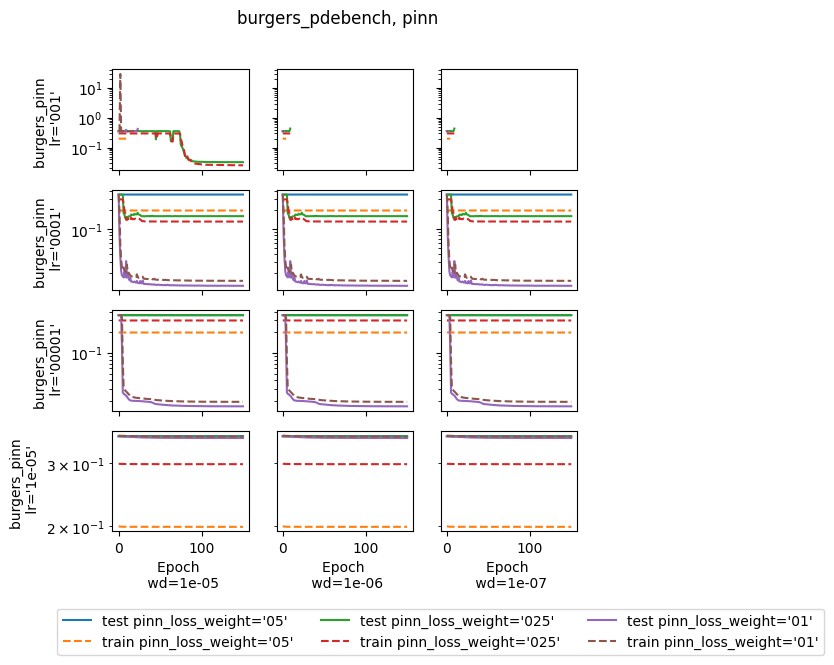

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


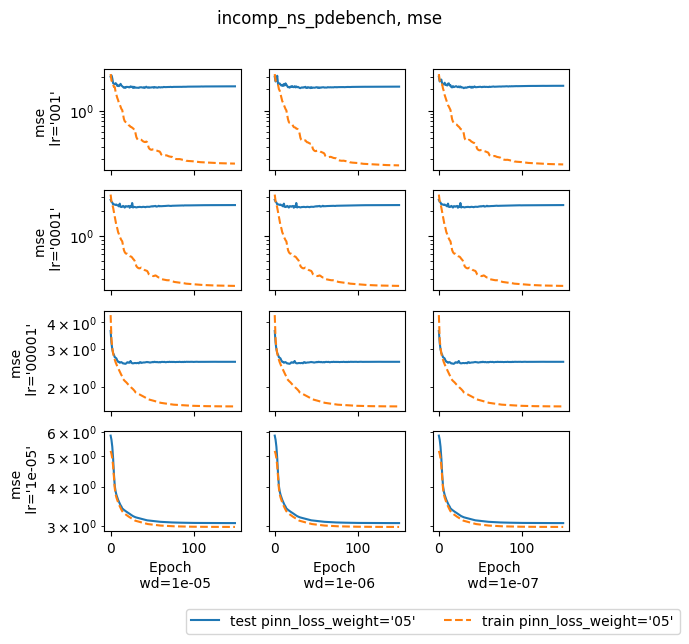

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


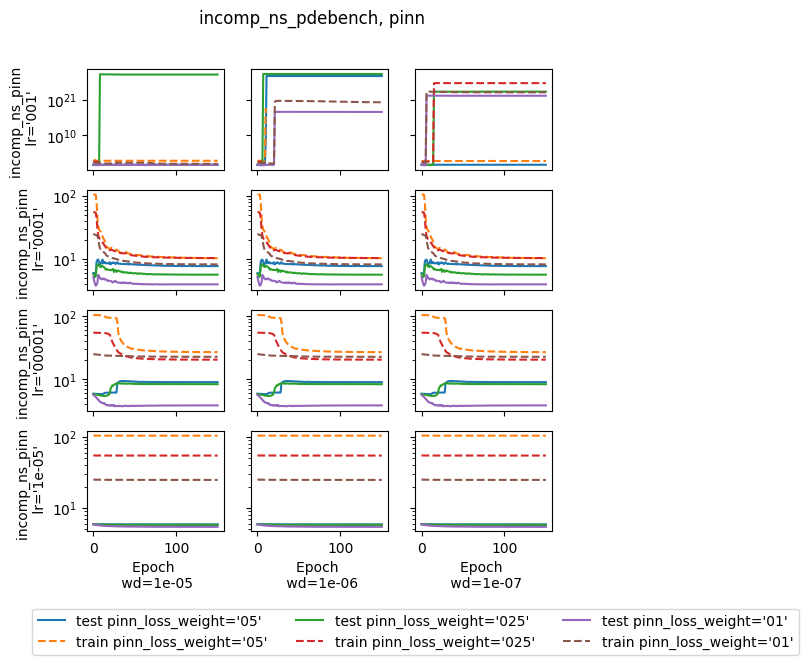

/tmp/ipykernel_375814/1074562398.py:104: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


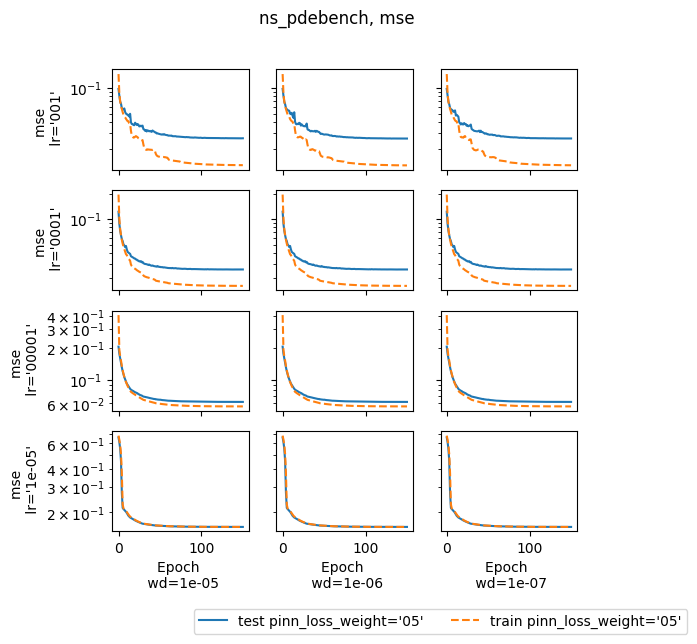

finished_exp=156, total_exp=156, 100.0 %


In [13]:
# Check if all experiments have finished
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
)
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    'ns_pdebench',
]:
    img_size = 255

    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64

    if dataset_name == 'burgers_pdebench':
        img_size = 512

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            _,
            _,
        ) = get_dataset_info(dataset_name, loss_type)
        if loss == 'n/a':
            continue
        fig, axes = plt.subplots(
            nrows=4, ncols=3, sharey='row', sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['001', '0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-05, 1e-06, 1e-07]):
                pinn_loss_weights = ['05']
                if 'pinn' in loss_type:
                    pinn_loss_weights += ['025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    max_mode = img_size // 2
                    resolutions = str_from_res([0, 1, 0, 0])
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ', ckpt_name)
                        continue
                    # print(ckpt_dir)
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                            row = df[df.epoch == 150]
                            summary_stats.loc[len(summary_stats)] = [
                                dataset_name,
                                loss,
                                learning_rates[lr],
                                wd,
                                pinn_weights[pinn_loss_weight],
                                row[ylabel].item(),
                            ]
                        else:
                            print('Not finished: ', ckpt_name)
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'test {pinn_loss_weight=}',
                            ax=axes[y_idx, x_idx],
                        )
                        sns.lineplot(
                            df,
                            x='epoch',
                            y='train_loss',
                            linestyle='--',
                            label=f'train {pinn_loss_weight=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 3:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.7), loc='upper center', ncols=3)

        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.tight_layout()
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

In [3]:
best_hps = summary_stats.loc[
    summary_stats.groupby(['data', 'loss']).test.idxmin()
]
best_hps

data            loss      lr            wd  \
66     burgers_pdebench    burgers_pinn  0.0010  1.000000e-05   
46     burgers_pdebench             mse  0.0010  1.000000e-05   
9        darcy_pdebench      darcy_pinn  0.0100  1.000000e-05   
0        darcy_pdebench             mse  0.0010  1.000000e-07   
123  incomp_ns_pdebench  incomp_ns_pinn  0.0001  1.000000e-05   
92   incomp_ns_pdebench             mse  0.0100  1.000000e-06   
143         ns_pdebench             mse  0.0010  1.000000e-06   

     pinn_loss_weight      test  
66                0.1  0.012701  
46                0.5  0.000381  
9                 0.1  0.001141  
0                 0.5  0.000274  
123               0.1  3.866482  
92                0.5  2.194969  
143               0.5  0.025513

## HP search for CROP/CNO2D

/tmp/ipykernel_1559530/2424363473.py:112: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


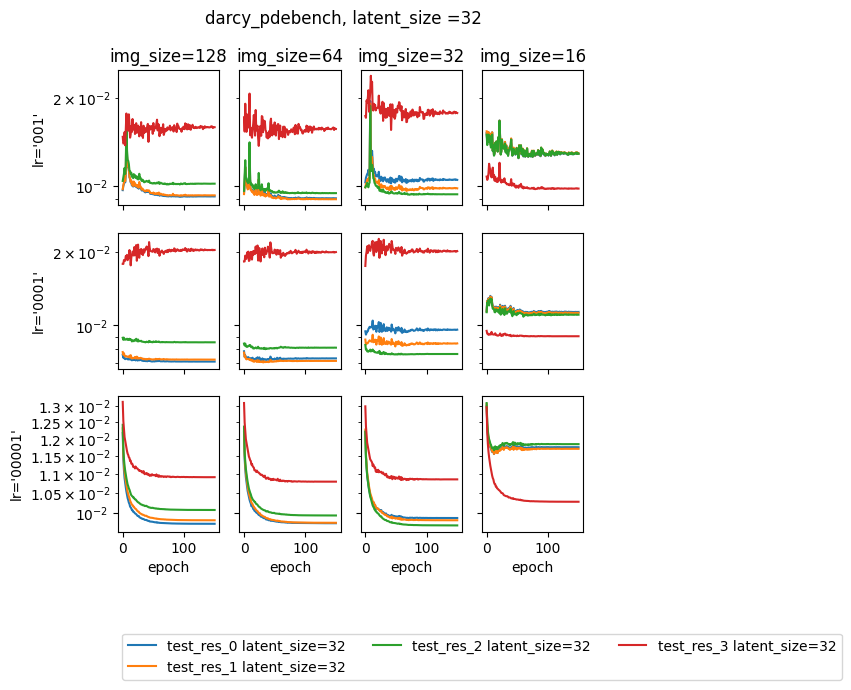

/tmp/ipykernel_1559530/2424363473.py:112: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


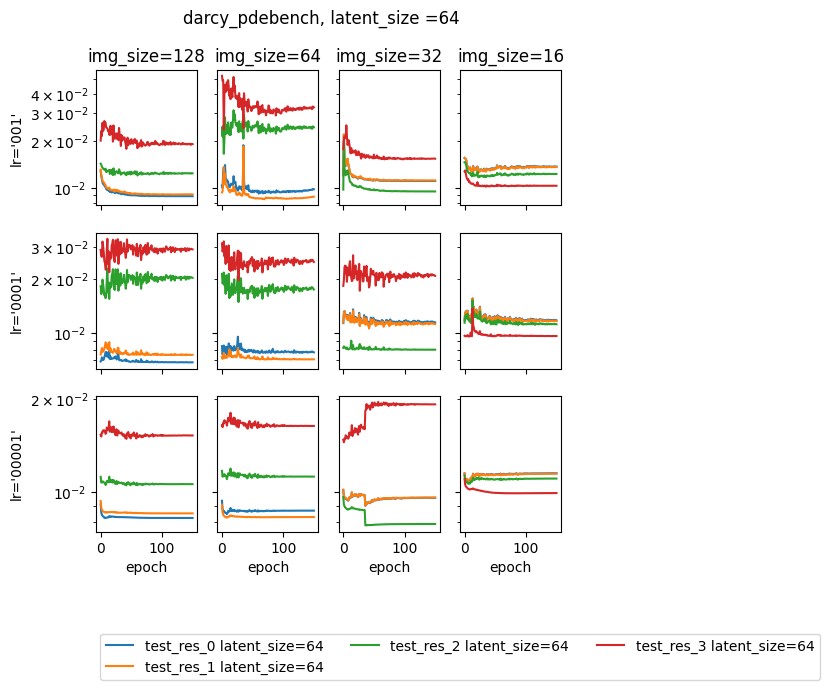

/tmp/ipykernel_1559530/2424363473.py:112: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


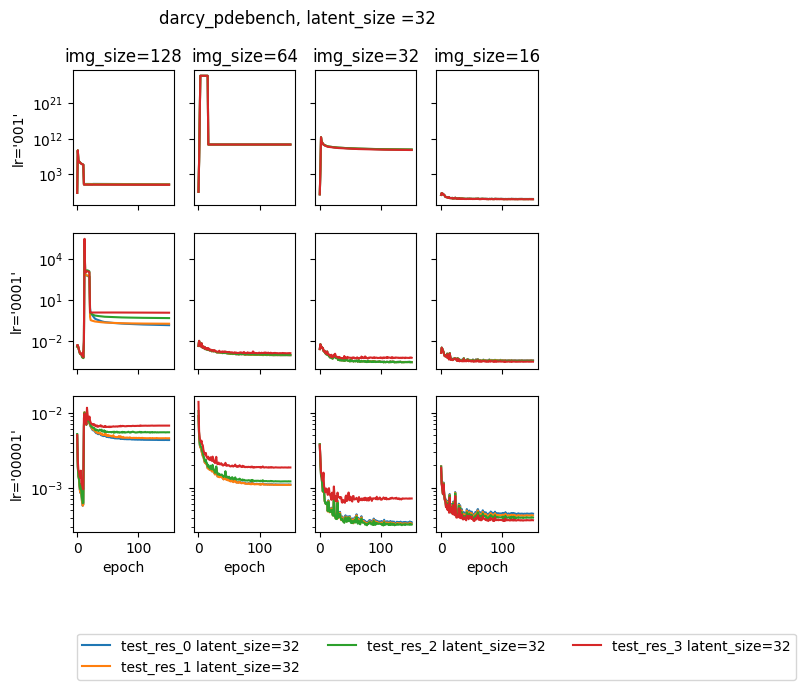

/tmp/ipykernel_1559530/2424363473.py:112: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


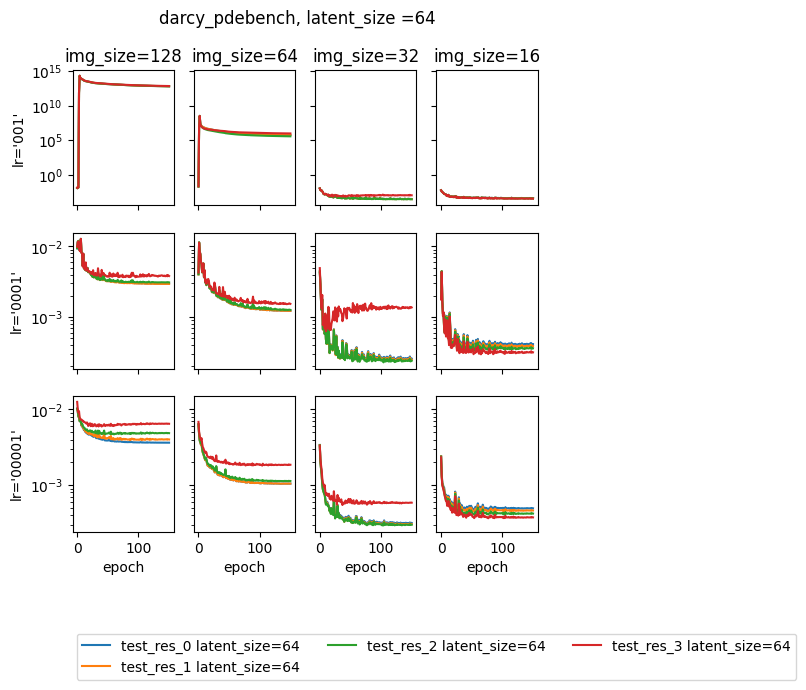

finished_exp=192, total_exp=48, 400.0 %


In [3]:
# Check if all experiments have finished
ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=[
        'model_name',
        'train_res',
        'test_res',
        'latent_size',
        'lr',
        'test_loss',
    ]
)
for model_name in [
    'CROP2D',
    'CNO2D',
]:
    dataset_name = 'darcy_pdebench'
    img_sizes = [128, 64, 32, 16]
    (
        _model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, 'mse')

    for latent_size in [32, 64]:
        fig, axes = plt.subplots(
            nrows=3, ncols=4, sharey='row', sharex='col', figsize=(6, 6)
        )
        wd = 1e-05
        for y_idx, lr in enumerate(['001', '0001', '00001']):
            for x_idx, res in enumerate(range(4)):
                img_size = img_sizes[res]
                pinn_loss_weight = '05'
                max_mode = latent_size // 2
                resolutions = [0, 0, 0, 0]
                resolutions[res] = 1
                resolutions = str_from_res(resolutions)
                ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
                ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                # print(ckpt_pth)
                ckpt_name = f'{ckpt_pth}/train_stats.csv'
                total_exp += 1
                if not os.path.exists(ckpt_name):
                    print('does not exist: ', ckpt_name)
                    continue
                # print(ckpt_dir)
                df = pd.read_csv(ckpt_name)

                for test_idx, ylabel in enumerate(
                    [
                        #'train_loss',
                        # f'test_res_{res}',
                        'test_res_0',
                        'test_res_1',
                        'test_res_2',
                        'test_res_3',
                    ]
                ):
                    test_res = img_sizes[test_idx]
                    if 150 in df['epoch']:
                        finished_exp += 1
                        row = df[df.epoch == 150]
                        summary_stats.loc[len(summary_stats)] = [
                            model_name,
                            img_size,
                            test_res,
                            latent_size,
                            learning_rates[lr],
                            row[ylabel].item(),
                        ]
                    else:
                        print('Not finished: ', ckpt_name)
                    sns.lineplot(
                        df,
                        x='epoch',
                        y=ylabel,
                        label=f'{ylabel} {latent_size=}',
                        ax=axes[y_idx, x_idx],
                    )
                    """
                    sns.lineplot(
                        df,
                        x='epoch',
                        y='train_loss',
                        linestyle="--",
                        label=f'train {latent_size=}',
                        ax=axes[y_idx, x_idx],
                    )
                    """
                    axes[y_idx, x_idx].get_legend().remove()
                    axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 3:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if y_idx == 0:
                    axes[y_idx, x_idx].set_title(f'{img_size=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{lr=}')

        plt.legend(bbox_to_anchor=(0, -0.7), loc='upper center', ncols=3)
        fig.suptitle(f'{dataset_name}, {latent_size =}')
        plt.tight_layout()
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

learning_rates[lr]=0.01, model_name='CROP2D', latent_size=32, avg loss:0.011456615317001663 
learning_rates[lr]=0.01, model_name='CROP2D', latent_size=64, avg loss:0.013862370829883681 


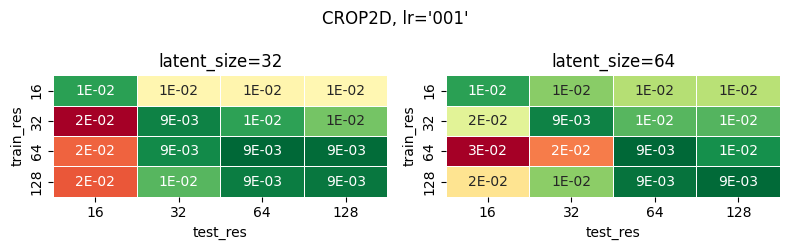

learning_rates[lr]=0.001, model_name='CROP2D', latent_size=32, avg loss:0.010897562442551075 
learning_rates[lr]=0.001, model_name='CROP2D', latent_size=64, avg loss:0.013500921293598311 


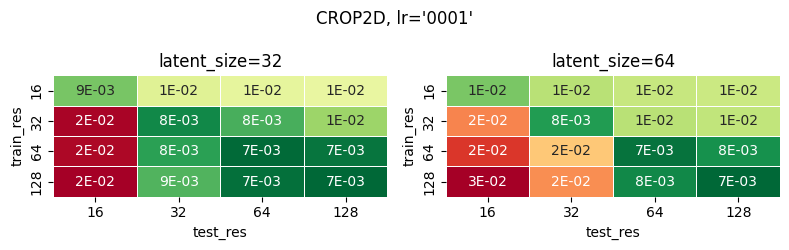

learning_rates[lr]=0.0001, model_name='CROP2D', latent_size=32, avg loss:0.010415028074930836 
learning_rates[lr]=0.0001, model_name='CROP2D', latent_size=64, avg loss:0.011067023904615742 


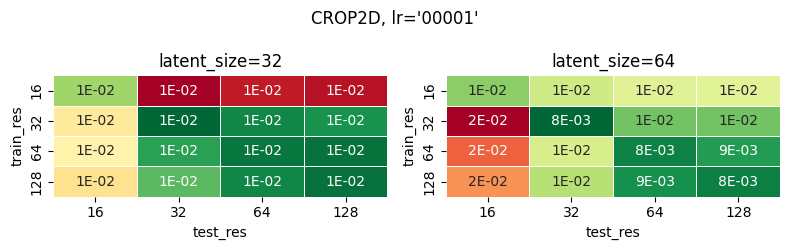

learning_rates[lr]=0.01, model_name='CNO2D', latent_size=32, avg loss:7824533696.520511 
learning_rates[lr]=0.01, model_name='CNO2D', latent_size=64, avg loss:1688144757021.9417 


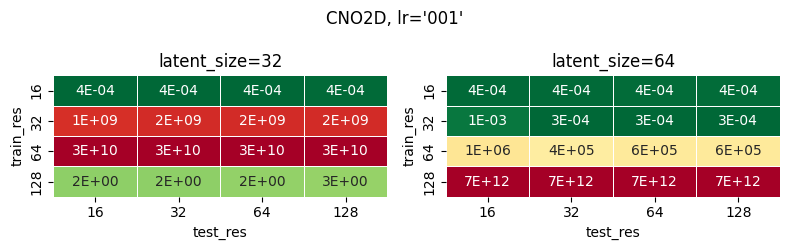

learning_rates[lr]=0.001, model_name='CNO2D', latent_size=32, avg loss:0.12354499858940919 
learning_rates[lr]=0.001, model_name='CNO2D', latent_size=64, avg loss:0.0013543973336708937 


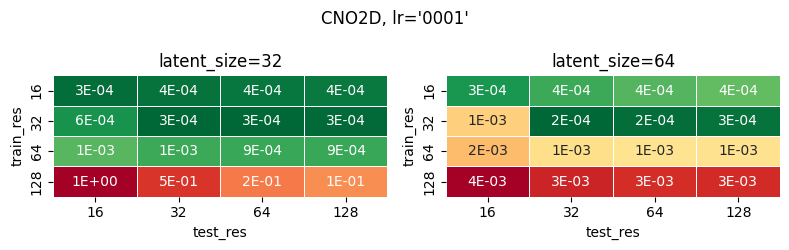

learning_rates[lr]=0.0001, model_name='CNO2D', latent_size=32, avg loss:0.0018617416594679062 
learning_rates[lr]=0.0001, model_name='CNO2D', latent_size=64, avg loss:0.001707276626802875 


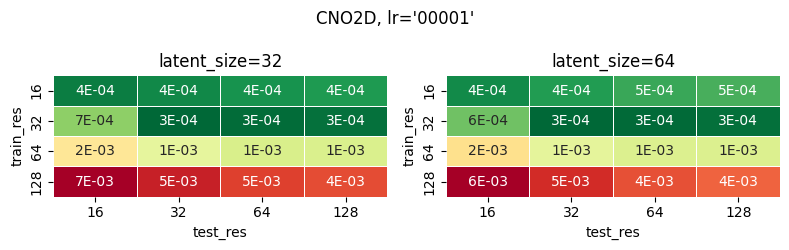

In [5]:
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
hp_search_stats = pd.DataFrame(
    columns=['model_name', 'latent_size', 'lr', 'avg_test_loss']
)
for model_name in [
    'CROP2D',
    'CNO2D',
]:
    for _, lr in enumerate(['001', '0001', '00001']):
        fig, axes = plt.subplots(
            nrows=1, ncols=2, sharey=False, sharex='col', figsize=(8, 2.5)
        )
        for y_idx, latent_size in enumerate([32, 64]):
            heatmap = summary_stats[
                (summary_stats.lr == learning_rates[lr])
                & (summary_stats.model_name == model_name)
                & (summary_stats.latent_size == latent_size)
            ]

            pivot = heatmap.pivot(
                index='train_res', columns='test_res', values='test_loss'
            )
            print(
                f'{learning_rates[lr]=}, {model_name=}, {latent_size=}, avg loss:{pivot.mean().mean()} '
            )
            norm = LogNorm()
            sns.heatmap(
                pivot,
                norm=norm,
                ax=axes[y_idx],
                cmap='RdYlGn_r',
                linewidths=0.5,
                fmt='.0E',
                annot=pivot,
                cbar=False,
            )
            axes[y_idx].set_title(f'{latent_size=}')

            hp_search_stats.loc[len(hp_search_stats)] = [
                model_name,
                latent_size,
                learning_rates[lr],
                pivot.mean().mean(),
            ]

        fig.suptitle(f'{model_name}, {lr=}')
        plt.tight_layout()
        plt.show()

In [6]:
best_hps = hp_search_stats.loc[
    hp_search_stats.groupby(
        ['model_name', 'latent_size']
    ).avg_test_loss.idxmin()
]
best_hps

model_name  latent_size      lr  avg_test_loss
10      CNO2D           32  0.0001       0.001862
9       CNO2D           64  0.0010       0.001354
4      CROP2D           32  0.0001       0.010415
5      CROP2D           64  0.0001       0.011067

learning_rates[lr]=0.0001, model_name='CROP2D', latent_size=32, avg loss:0.010415028074930836 
learning_rates[lr]=0.0001, model_name='CROP2D', latent_size=64, avg loss:0.011067023904615742 


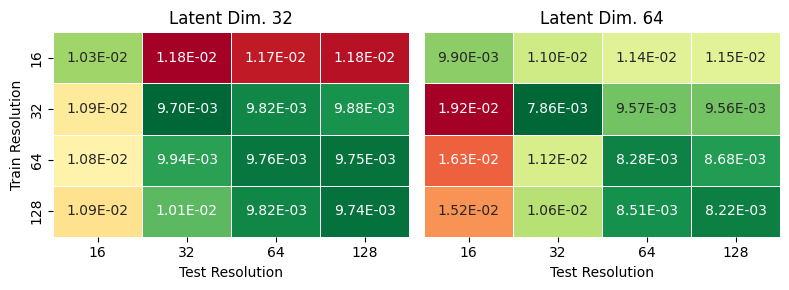

learning_rates[lr]=0.0001, model_name='CNO2D', latent_size=32, avg loss:0.0018617416594679062 
learning_rates[lr]=0.001, model_name='CNO2D', latent_size=64, avg loss:0.0013543973336708937 


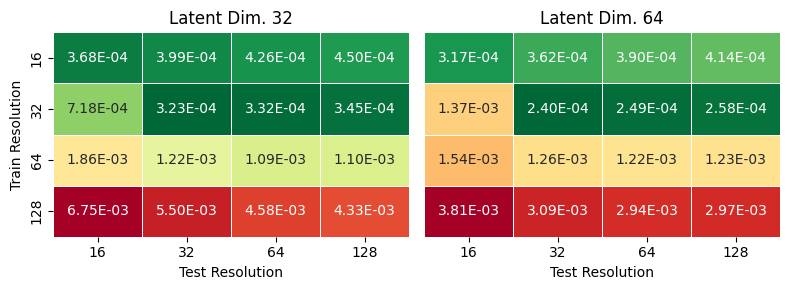

In [7]:
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
hp_search_stats = pd.DataFrame(
    columns=['model_name', 'latent_size', 'lr', 'avg_test_loss']
)
for model_name in [
    'CROP2D',
    'CNO2D',
]:
    fig, axes = plt.subplots(
        nrows=1, ncols=2, sharey='row', sharex='col', figsize=(8, 3)
    )

    for y_idx, latent_size in enumerate([32, 64]):
        # LR based on HP search
        if model_name == 'CROP2D':
            lr = '00001'
        else:
            if latent_size == 32:
                lr = '00001'
            if latent_size == 64:
                lr = '0001'

        heatmap = summary_stats[
            (summary_stats.lr == learning_rates[lr])
            & (summary_stats.model_name == model_name)
            & (summary_stats.latent_size == latent_size)
        ]

        pivot = heatmap.pivot(
            index='train_res', columns='test_res', values='test_loss'
        )
        print(
            f'{learning_rates[lr]=}, {model_name=}, {latent_size=}, avg loss:{pivot.mean().mean()} '
        )
        norm = LogNorm()
        sns.heatmap(
            pivot,
            norm=norm,
            ax=axes[y_idx],
            cmap='RdYlGn_r',
            linewidths=0.5,
            fmt='.2E',
            annot=pivot,
            cbar=False,
        )
        axes[y_idx].set_title(f'Latent Dim. {latent_size}')
        axes[y_idx].set_ylabel('Train Resolution')
        axes[y_idx].set_xlabel('Test Resolution')
        if y_idx != 0:
            axes[y_idx].get_yaxis().set_visible(False)

    hp_search_stats.loc[len(hp_search_stats)] = [
        model_name,
        latent_size,
        learning_rates[lr],
        pivot.mean().mean(),
    ]

    # fig.suptitle(f"{model_name}")
    plt.tight_layout()
    plt.show()
    fig.savefig(
        f'{FIG_DIR}/{model_name}_heatmapt.pdf',  # .png
        dpi=300,
        bbox_inches='tight',
    )

In [8]:
def resize(x, out_size, permute=False):
    if permute:
        x = x.permute(0, 3, 1, 2)

    f = torch.fft.rfft2(x, norm='backward')
    f_z = torch.zeros(
        (*x.shape[:-2], out_size[0], out_size[1] // 2 + 1),
        dtype=f.dtype,
        device=f.device,
    )
    # 2k+1 -> (2k+1 + 1) // 2 = k+1 and (2k+1)//2 = k
    top_freqs1 = min((f.shape[-2] + 1) // 2, (out_size[0] + 1) // 2)
    top_freqs2 = min(f.shape[-1], out_size[1] // 2 + 1)
    # 2k -> (2k + 1) // 2 = k and (2k)//2 = k
    bot_freqs1 = min(f.shape[-2] // 2, out_size[0] // 2)
    bot_freqs2 = min(f.shape[-1], out_size[1] // 2 + 1)
    f_z[..., :top_freqs1, :top_freqs2] = f[..., :top_freqs1, :top_freqs2]
    f_z[..., -bot_freqs1:, :bot_freqs2] = f[..., -bot_freqs1:, :bot_freqs2]
    # x_z = torch.fft.ifft2(f_z, s=out_size).real
    x_z = torch.fft.irfft2(f_z, s=out_size).real
    x_z = x_z * (out_size[0] / x.shape[-2]) * (out_size[1] / x.shape[-1])

    # f_z[..., -f.shape[-2]//2:, :f.shape[-1]] = f[..., :f.shape[-2]//2+1, :]

    if permute:
        x_z = x_z.permute(0, 2, 3, 1)
    return x_z

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_32_CROP2D_1_1_05_1_multi_0_0_0_1_64_16/150_ckpt.pth
resolution_ratios=[0,

/tmp/ipykernel_1559530/2431613509.py:219: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


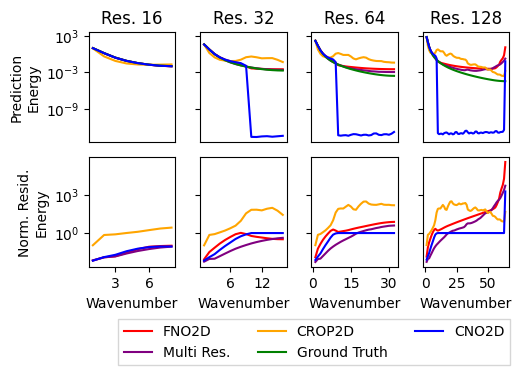

In [9]:
# fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(6, 2.5))
subfigs = fig.subfigures(2, 1, wspace=0.07)  # three rows

# img_axs = subfigs[0].subplots(1, 4, sharey=False)
# multi_axs = subfigs[1].subplots(1, 4, sharey=False)
spectrum_axs = subfigs[0].subplots(1, 4, sharey='row')
residual_axs = subfigs[1].subplots(1, 4, sharey='row')

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'

color_dict = {
    'ground_truth': 'green',
    'FNO2D': 'red',
    'CROP2D': 'orange',
    'CNO2D': 'blue',
    'Multi Res.': 'purple',
}


for model_name in [
    'FNO2D',
    'Multi Res.',
    'CROP2D',
    'CNO2D',
]:  # "CROP", "CNO2D",
    if model_name == 'FNO2D':
        (
            m_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        latent_size = '-'
        img_size = '-'
        max_mode = 8
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'

    if model_name == 'Multi Res.':
        (
            m_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        latent_size = '-'
        img_size = '-'
        max_mode = 128 // 2
        ckpt_pth = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_01_01_01_07/'
        ckpt_pth = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/'

    if model_name == 'CROP2D':
        m_name = 'CROP2D'
        (
            _model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        lr = 0.001
        latent_size = 64
        img_size = 16
        max_mode = latent_size // 2
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'

    if model_name == 'CNO2D':
        m_name = 'CNO2D'
        (
            _model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        lr = 0.0001
        latent_size = 64
        img_size = 16
        max_mode = latent_size // 2
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        print(ckpt_pth)

    # grab trained model
    model = get_model(
        model_name=m_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
        latent_size=latent_size,
        img_size=img_size,
    )

    ckpt_dict = load_latest_ckpt(ckpt_pth)
    model.load_state_dict(ckpt_dict['model_state_dict'])
    model = model.to(device)
    model = model.eval()

    for x_idx, res in enumerate([16, 32, 64, 128]):
        resolution_ratio = [0, 0, 0, 0]
        resolution_ratio[-(x_idx + 1)] = 1
        resolutions = [16, 32, 64, 128]  # [128, 64, 32, 16]
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=-1,
            img_size=res,
            downsample_dim=-1,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=128,
            seed=0,
            resolution_ratios=resolution_ratio,
        )

        sample = {
            'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
            'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
        }
        # grab a single input from the last batch
        model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
        with torch.no_grad():
            model_output = model(x=model_input)
        ground_truth = sample['y']  # .unsqueeze(dim=0)
        residuals = model_output - ground_truth.to(
            device
        )  # / ground_truth.to(device)

        # convert to plotable form
        output = model_output[0, 0, :, :].cpu().numpy()
        label = ground_truth[0, 0, :, :].cpu().numpy()

        # get spectrums
        label_spectrum = get_energy_curve(ground_truth)
        pred_spectrum = get_energy_curve(model_output)
        residual_spectrum = get_energy_curve(residuals)

        spectrum_axs[x_idx].set_yscale('log')
        x = np.linspace(1, len(label_spectrum), len(label_spectrum))

        spectrum_axs[x_idx].plot(
            x,
            pred_spectrum,
            label=f'{model_name}',
            color=color_dict[model_name],
        )
        if model_name == 'CROP2D':
            spectrum_axs[x_idx].plot(
                x,
                label_spectrum,
                label='Ground Truth',
                color=color_dict['ground_truth'],
            )
        # spectrum_axs[x_idx].plot(x, residual_spectrum / label_spectrum, linestyle=":", label='Residual', color='red')
        spectrum_axs[0].set_ylabel('Prediction\nEnergy')
        spectrum_axs[x_idx].xaxis.set_major_locator(
            ticker.MaxNLocator(integer=True, nbins=4)
        )
        spectrum_axs[x_idx].get_xaxis().set_visible(False)
        spectrum_axs[x_idx].set_title(f'Res. {resolutions[x_idx]}')

        residual_axs[x_idx].set_yscale('log')
        residual_axs[x_idx].plot(
            x,
            residual_spectrum / label_spectrum,
            label=f'{model_name} Resid',
            color=color_dict[model_name],
        )
        residual_axs[x_idx].set_xlabel('Wavenumber')
        residual_axs[0].set_ylabel('Norm. Resid.\nEnergy')
        residual_axs[x_idx].xaxis.set_major_locator(
            ticker.MaxNLocator(integer=True, nbins=3)
        )

handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.65, -0.15),
    fancybox=False,
    shadow=False,
    ncol=3,
)
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/all_methods_aliasing_overview_experiment.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_32_CROP2D_1_1_05_1_multi_0_0_0_1_64_16/150_ckpt.pth
resolution_ratios=[0,

/tmp/ipykernel_1559530/2912280344.py:218: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


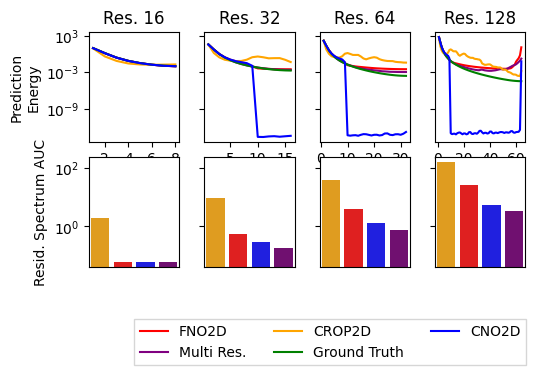

In [45]:
# fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(6, 2.5))
subfigs = fig.subfigures(2, 1, wspace=0.07)  # three rows

# img_axs = subfigs[0].subplots(1, 4, sharey=False)
# multi_axs = subfigs[1].subplots(1, 4, sharey=False)
spectrum_axs = subfigs[0].subplots(1, 4, sharey='row')
residual_axs = subfigs[1].subplots(1, 4, sharey="row")

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'

df_auc = pd.DataFrame(columns=["Model", "Resid. Spectrum AUC", "Test Resolution"])
color_dict = {
    'ground_truth': 'green',
    'FNO2D': 'red',
    'CROP2D': 'orange',
    'CNO2D': 'blue',
    'Multi Res.': 'purple',
}


for model_name in [
    'FNO2D',
    'Multi Res.',
    'CROP2D',
    'CNO2D',
]:  # "CROP", "CNO2D",
    if model_name == 'FNO2D':
        (
            m_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        latent_size = '-'
        img_size = '-'
        max_mode = 8
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'

    if model_name == 'Multi Res.':
        (
            m_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        latent_size = '-'
        img_size = '-'
        max_mode = 128 // 2
        ckpt_pth = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_01_01_01_07/'
        ckpt_pth = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/'

    if model_name == 'CROP2D':
        m_name = 'CROP2D'
        (
            _model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        lr = 0.001
        latent_size = 64
        img_size = 16
        max_mode = latent_size // 2
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'

    if model_name == 'CNO2D':
        m_name = 'CNO2D'
        (
            _model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        lr = 0.0001
        latent_size = 64
        img_size = 16
        max_mode = latent_size // 2
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        print(ckpt_pth)

    # grab trained model
    model = get_model(
        model_name=m_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
        latent_size=latent_size,
        img_size=img_size,
    )

    ckpt_dict = load_latest_ckpt(ckpt_pth)
    model.load_state_dict(ckpt_dict['model_state_dict'])
    model = model.to(device)
    model = model.eval()

    for x_idx, res in enumerate([16, 32, 64, 128]):
        resolution_ratio = [0, 0, 0, 0]
        resolution_ratio[-(x_idx + 1)] = 1
        resolutions = [16, 32, 64, 128]  # [128, 64, 32, 16]
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=-1,
            img_size=res,
            downsample_dim=-1,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=128,
            seed=0,
            resolution_ratios=resolution_ratio,
        )

        sample = {
            'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
            'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
        }
        # grab a single input from the last batch
        model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
        with torch.no_grad():
            model_output = model(x=model_input)
        ground_truth = sample['y']  # .unsqueeze(dim=0)
        residuals = model_output - ground_truth.to(
            device
        )  # / ground_truth.to(device)

        # convert to plotable form
        output = model_output[0, 0, :, :].cpu().numpy()
        label = ground_truth[0, 0, :, :].cpu().numpy()

        # get spectrums
        label_spectrum = get_energy_curve(ground_truth)
        pred_spectrum = get_energy_curve(model_output)
        residual_spectrum = get_energy_curve(residuals)

        auc = np.trapz(residual_spectrum)
        df_auc.loc[len(df_auc)] = [model_name, auc, resolutions[x_idx]]

        spectrum_axs[x_idx].set_yscale('log')
        x = np.linspace(1, len(label_spectrum), len(label_spectrum))

        spectrum_axs[x_idx].plot(
            x,
            pred_spectrum,
            label=f'{model_name}',
            color=color_dict[model_name],
        )
        if model_name == 'CROP2D':
            auc = np.trapz(label_spectrum)
            
            spectrum_axs[x_idx].plot(
                x,
                label_spectrum,
                label='Ground Truth',
                color=color_dict['ground_truth'],
            )
        # spectrum_axs[x_idx].plot(x, residual_spectrum / label_spectrum, linestyle=":", label='Residual', color='red')
        spectrum_axs[0].set_ylabel('Prediction\nEnergy')
        spectrum_axs[x_idx].xaxis.set_major_locator(
            ticker.MaxNLocator(integer=True, nbins=4)
        )
        #spectrum_axs[x_idx].get_xaxis().set_visible(False)
        spectrum_axs[x_idx].set_title(f'Res. {resolutions[x_idx]}')

for x_idx, resolution_val in enumerate([16, 32, 64, 128]):
    sns.barplot(df_auc[df_auc['Test Resolution'] == resolution_val], x="Model", y="Resid. Spectrum AUC", hue="Model", 
        order=['CROP2D', 'FNO2D', 'CNO2D', 'Multi Res.'], ax=residual_axs[x_idx], palette = color_dict)
    residual_axs[x_idx].get_xaxis().set_visible(False)
    residual_axs[x_idx].set_yscale("log")
    
handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.65, -0.15),
    fancybox=False,
    shadow=False,
    ncol=3,
)
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/all_methods_aliasing_overview_experiment.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_8_FNO2D_1_1_05_1_single_0_0_0_1/150_ckpt.pth
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
Resuming training from /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_32_CROP2D_1_1_05_1_multi_0_0_0_1_64_16/150_ckpt.pth
resolution_ratios=[0,

/tmp/ipykernel_95263/1363219496.py:182: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


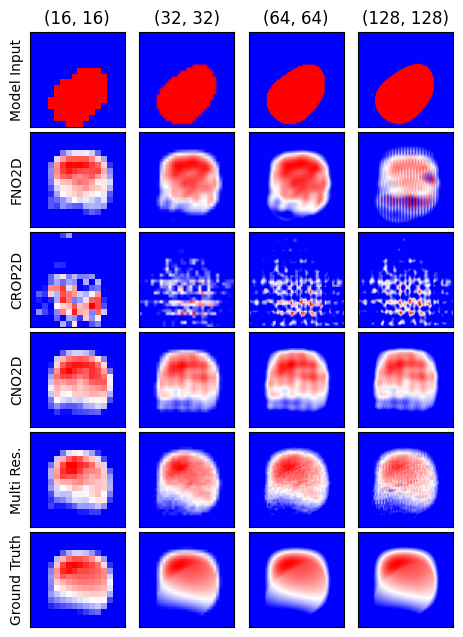

In [22]:
# fig, axs = plt.subplots(3, 4, figsize=(8, 8))

fig = plt.figure(layout='constrained', figsize=(8, 6))
subfigs = fig.subfigures(6, 1, wspace=0.07)  # three rows

# img_axs = subfigs[0].subplots(1, 4, sharey=False)
# multi_axs = subfigs[1].subplots(1, 4, sharey=False)
# spectrum_axs = subfigs[1].subplots(1, 4, sharey='row')
# residual_axs = subfigs[2].subplots(1, 4, sharey='row')

# get data args
loss = 'mse'
dataset_name = 'darcy_pdebench'
darcy_forcing_term = 1.0
burger_viscosity = 'na'

color_dict = {
    'ground_truth': 'green',
    'FNO2D': 'red',
    'CROP2D': 'orange',
    'CNO2D': 'blue',
    'Multi_res': 'purple',
}


for i, model_name in enumerate(
    ['Model Input', 'FNO2D', 'CROP2D', 'CNO2D', 'Multi Res.', 'Ground Truth']
):  # "CROP", "CNO2D",
    img_axs = subfigs[i].subplots(1, 4, sharey=False)

    if model_name == 'FNO2D':
        (
            m_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        latent_size = '-'
        img_size = '-'
        max_mode = 8
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'

    if model_name == 'Multi Res.':
        (
            m_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        latent_size = '-'
        img_size = '-'
        max_mode = 128 // 2
        ckpt_pth = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_01_01_01_07/'
        ckpt_pth = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025/'

    if model_name == 'CROP2D':
        m_name = 'CROP2D'
        (
            _model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        lr = 0.001
        latent_size = 64
        img_size = 16
        max_mode = latent_size // 2
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'

    if model_name == 'CNO2D':
        m_name = 'CNO2D'
        (
            _model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            _,
            wd,
            pinn_loss_weight,
        ) = get_dataset_info(dataset_name, loss)
        lr = 0.0001
        latent_size = 64
        img_size = 16
        max_mode = latent_size // 2
        resolutions = str_from_res([0, 0, 0, 1])
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{resolutions}_{latent_size}_{img_size}'
        ckpt_dir = str(ckpt_dir).replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        print(ckpt_pth)

    # grab trained model
    model = get_model(
        model_name=m_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
        latent_size=latent_size,
        img_size=img_size,
    )

    ckpt_dict = load_latest_ckpt(ckpt_pth)
    model.load_state_dict(ckpt_dict['model_state_dict'])
    model = model.to(device)
    model = model.eval()

    for x_idx, res in enumerate([16, 32, 64, 128]):
        resolution_ratio = [0, 0, 0, 0]
        resolution_ratio[-(x_idx + 1)] = 1
        resolutions = [16, 32, 64, 128]  # [128, 64, 32, 16]
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=-1,
            img_size=res,
            downsample_dim=-1,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=128,
            seed=0,
            resolution_ratios=resolution_ratio,
        )

        sample = {
            'x': torch.concat([dataset[i]['x'] for i in range(len(dataset))]),
            'y': torch.concat([dataset[i]['y'] for i in range(len(dataset))]),
        }
        # grab a single input from the last batch
        model_input = sample['x'].to(device)  # .unsqueeze(dim=0).to(device)
        with torch.no_grad():
            model_output = model(x=model_input)
        ground_truth = sample['y']  # .unsqueeze(dim=0)
        residuals = model_output - ground_truth.to(
            device
        )  # / ground_truth.to(device)

        # convert to plotable form
        output = model_output[0, 0, :, :].cpu().numpy()
        label = ground_truth[0, 0, :, :].cpu().numpy()

        img = output  # - label
        if model_name == 'Model Input':
            img = sample['x'][0, 0, ...]
        if model_name == 'Ground Truth':
            img = label
        norm = colors.LogNorm(
            img.mean() + 0.5 * img.std(), img.max(), clip='True'
        )
        img_axs[x_idx].imshow(img, norm=norm, cmap='bwr')
        if i == 0:
            img_axs[x_idx].set_title(
                f'{(resolutions[x_idx], resolutions[x_idx])}'
            )
        # img_axs[x_idx].get_yaxis().set_visible(False)
        img_axs[x_idx].set_yticks([])
        img_axs[x_idx].get_xaxis().set_visible(False)
        # subfigs[0].supylabel("Example Prediction")
        img_axs[0].set_ylabel(f'{model_name}')

handles, labels = spectrum_axs[x_idx].get_legend_handles_labels()
plt.tight_layout()
fig.savefig(
    f'{FIG_DIR}/all_methods_aliasing_vis.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

In [46]:
def show_img_and_power_spectrum(image: np.array):
    """Show image and its corresponding energy spectrum."""
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))

    axs[0].imshow(image[0, 0, ...])
    axs[0].set_title('Spatial Domain')

    spectrum = get_energy_curve(torch.tensor(image))
    axs[1].plot(spectrum)
    axs[1].set_yscale('log')
    axs[1].set_title('spectrum')
    axs[1].set_ylabel('Energy')
    axs[1].set_xlabel('Wavenumber')
    # axs[1].set_xscale("log")

    plt.tight_layout()
    plt.show()


show_img_and_power_spectrum(img)

NameError: name 'img' is not defined

/tmp/ipykernel_871660/1557007290.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum = get_energy_curve(torch.tensor(image))


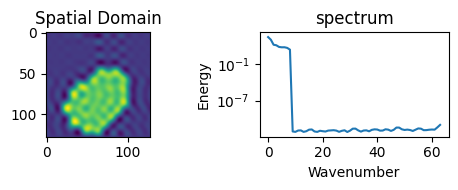

In [44]:
resize_img = resize(img, (128, 128), permute=False)
show_img_and_power_spectrum(resize_img)

/tmp/ipykernel_871660/1557007290.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum = get_energy_curve(torch.tensor(image))


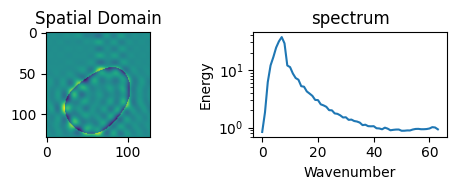

In [65]:
show_img_and_power_spectrum(residual)

/tmp/ipykernel_871660/1557007290.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrum = get_energy_curve(torch.tensor(image))


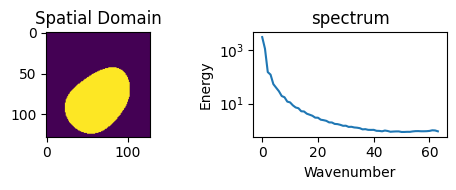

In [67]:
show_img_and_power_spectrum(high_res_dataset[0]['x'])

/tmp/ipykernel_871660/3613425592.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  residual = resize_img - torch.tensor(high_res_dataset[0]['x'])
/tmp/ipykernel_871660/3613425592.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  high_spectrum = get_energy_curve(torch.tensor(high_res_dataset[0]['x']))


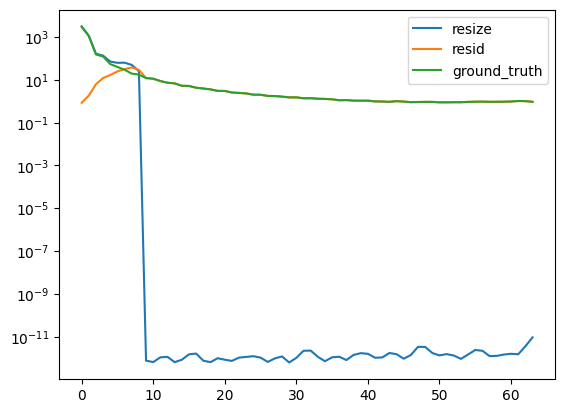

In [64]:
residual = resize_img - torch.tensor(high_res_dataset[0]['x'])
resid_spectrum = get_energy_curve(residual)
resize_spectrum = get_energy_curve(resize_img)
high_spectrum = get_energy_curve(torch.tensor(high_res_dataset[0]['x']))
plt.plot(resize_spectrum, label='resize')
plt.plot(resid_spectrum, label='resid')
plt.plot(high_spectrum, label='ground_truth')
plt.yscale('log')
plt.legend()

# PINNs

TODO:
- make fig about pinn's weights
- make fig w/ ns various feilds

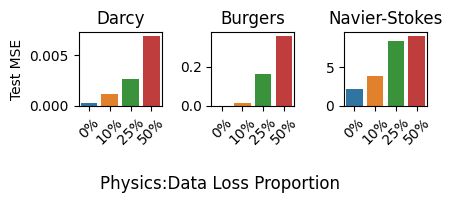

In [65]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}


fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey=False, sharex='col', figsize=(4.5, 2)
)
for x_idx, dataset_name in enumerate(
    [
        'darcy_pdebench',
        'burgers_pdebench',
        'incomp_ns_pdebench',
        #'ns_pdebench',
    ]
):
    summary_stats = pd.DataFrame(
        columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
    )
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'incomp_ns_pdebench':
        img_size = 255
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
        title = 'Navier-Stokes'

    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64
        title = 'Darcy'

    if dataset_name == 'burgers_pdebench':
        img_size = 512
        title = 'Burgers'

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, loss_type)

        if loss == 'n/a':
            continue

        pinn_loss_weights = ['05']
        if 'pinn' in loss_type:
            pinn_loss_weights = ['01', '025', '05']
        for pinn_loss_weight in pinn_loss_weights:
            label = '0%'
            if 'pinn' in loss_type:
                # label = f"Data ({(1 - pinn_weights[pinn_loss_weight])* 100}%) + Physics ({pinn_weights[pinn_loss_weight]*100}%) Loss"
                label = f'{int(pinn_weights[pinn_loss_weight] * 100)}%'
            max_mode = img_size // 2
            resolutions = str_from_res([0, 1, 0, 0])
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_pth = ckpt_pth.replace('.', '')
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            total_exp += 1
            if not os.path.exists(ckpt_name):
                print('does not exist: ', ckpt_dir)
                continue
            df = pd.read_csv(ckpt_name)
            for ylabel in [
                'test',
            ]:
                if 150 in df['epoch']:
                    finished_exp += 1
                    row = df[df.epoch == 150]
                    summary_stats.loc[len(summary_stats)] = [
                        dataset_name,
                        # f"{loss}+{pinn_loss_weight}",
                        label,
                        lr,
                        wd,
                        pinn_weights[pinn_loss_weight],
                        row[ylabel].item(),
                    ]
                else:
                    print('Not finished: ', ckpt_name)
                sns.barplot(
                    summary_stats,
                    x='loss',
                    y=ylabel,
                    hue='loss',
                    ax=axes[x_idx],
                )
                axes[x_idx].tick_params(axis='x', labelrotation=45)
                axes[x_idx].set_title(title)
                axes[x_idx].set_ylabel(None)
                axes[x_idx].set_xlabel(None)
                axes[x_idx].set_title(title)
                if x_idx == 0:
                    axes[x_idx].set_ylabel('Test MSE')
                fig.supxlabel('Physics:Data Loss Proportion')

plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/pinns_weight_barplot.pdf',
    bbox_inches='tight',
    dpi=300,
)

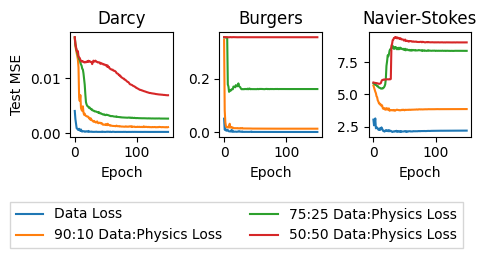

In [66]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}


fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey=False, sharex='col', figsize=(5, 2)
)
for x_idx, dataset_name in enumerate(
    [
        'darcy_pdebench',
        'burgers_pdebench',
        'incomp_ns_pdebench',
        #'ns_pdebench',
    ]
):
    summary_stats = pd.DataFrame(
        columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
    )

    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'incomp_ns_pdebench':
        img_size = 255
        title = 'Navier-Stokes'
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        img_size = 256

    if dataset_name == 'darcy_pdebench':
        img_size = 64
        title = 'Darcy'

    if dataset_name == 'burgers_pdebench':
        img_size = 512
        title = 'Burgers'

    for loss_type in ['mse', 'pinn']:
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, loss_type)

        if loss == 'n/a':
            continue

        pinn_loss_weights = ['05']

        if 'pinn' in loss_type:
            pinn_loss_weights = ['01', '025', '05']

        for pinn_loss_weight in pinn_loss_weights:
            label = 'Data Loss'
            if 'pinn' in loss_type:
                label = f'Data Loss ({int((1 - pinn_weights[pinn_loss_weight]) * 100)}%) + Physics Loss ({int(pinn_weights[pinn_loss_weight] * 100)}%)'
                label = f'{int((1 - pinn_weights[pinn_loss_weight]) * 100)}:{int(pinn_weights[pinn_loss_weight] * 100)} Data:Physics Loss'
            max_mode = img_size // 2
            resolutions = str_from_res([0, 1, 0, 0])
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{resolutions}'
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_pth = ckpt_pth.replace('.', '')
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            total_exp += 1
            if not os.path.exists(ckpt_name):
                print('does not exist: ', ckpt_dir)
                continue
            df = pd.read_csv(ckpt_name)
            for ylabel in [
                'test',
            ]:
                if 150 in df['epoch']:
                    finished_exp += 1
                    row = df[df.epoch == 150]
                    summary_stats.loc[len(summary_stats)] = [
                        dataset_name,
                        f'{loss}+{pinn_loss_weight}',
                        lr,
                        wd,
                        pinn_weights[pinn_loss_weight],
                        row[ylabel].item(),
                    ]
                else:
                    print('Not finished: ', ckpt_name)
                sns.lineplot(
                    df,
                    x='epoch',
                    y=ylabel,
                    label=label,  # f'{f"{loss}+{pinn_loss_weight}"}',
                    ax=axes[x_idx],
                )
                axes[x_idx].set_ylabel(None)
                axes[x_idx].set_title(title)
                axes[x_idx].set_xlabel('Epoch')
                handles, labels = axes[x_idx].get_legend_handles_labels()
                axes[x_idx].get_legend().remove()
                if x_idx == 0:
                    axes[x_idx].set_ylabel('Test MSE')


fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.00),
    fancybox=False,
    shadow=False,
    ncol=2,
)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/pinns_weight_tuning.pdf',
    bbox_inches='tight',
    dpi=300,
)

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


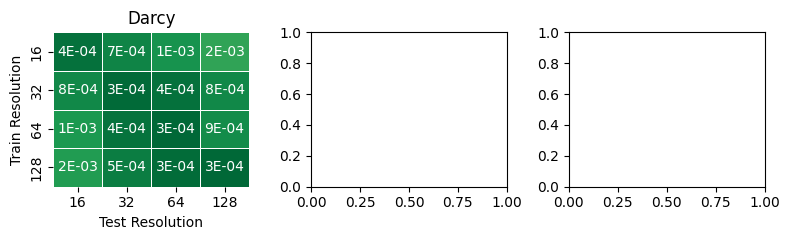

In [52]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey=False, sharex='col', figsize=(8, 2.5)
)
for x_idx, dataset_name in enumerate(
    [
        #'ns_pdebench',
        'darcy_pdebench',
        'burgers_pdebench',
        'incomp_ns_pdebench',
    ]
):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, 'mse')

    title = 'Navier-Stokes'
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
        center = 3  # 10
        # center w/ 3 and div norm and log works well

    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]

    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        title = 'Darcy'
        # center = 2e-03
        center = 1e-03

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        title = 'Burgers'
        center = 5e-4
        # center = 5e-3  # 7e-04, 6e-04, 5e-05, 5.5e-04, 1e-3, 1.5e-3, 2e-3, 3e-3, 4e-3

    heatmap = pd.DataFrame(
        columns=[
            'Train Resolution',
            'Test Resolution',
            'test_loss',
            'loss_name',
        ]
    )
    for epoch in [150]:  # 0, 50, 100, 250, 500
        for _x_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params,
                loss_name='na',
            )
            test_loader = DataLoader(dataset, batch_size=1)

            for _y_idx, img_size in enumerate(range(len(img_sizes))):
                train_resolutions = [0, 0, 0, 0]
                train_resolutions[img_size] = 1
                train_resolutions = ''.join(str(train_resolutions).split())
                offset = 0
                if initial_steps == 1:
                    offset = 1

                for _y_idx, loss in enumerate(['mse', 'pinn']):
                    (
                        model_name,
                        in_channels,
                        out_channels,
                        initial_steps,
                        loss,
                        batch_size,
                        lr,
                        wd,
                        pinn_loss_w,
                    ) = get_dataset_info(dataset_name, loss)
                    lr = str(lr).replace('.', '')
                    pinn_loss_weights = [pinn_loss_w]
                    # if 'pinn' in loss:
                    #    pinn_loss_weights = ['05', '025', '01']
                    for pinn_loss_weight in pinn_loss_weights:
                        loss_type = 'Data Loss'
                        col = 'green'
                        if 'pinn' in loss:
                            loss_type = 'Data+Physics Loss'
                            col = 'orange'

                        max_mode = img_sizes[img_size] // 2
                        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                        ckpt_pth = ckpt_pth.replace('.', '')
                        model = get_model(
                            model_name=model_name,
                            max_modes=max_mode,
                            hidden_channels=32,
                            in_channels=in_channels,
                            out_channels=out_channels,
                            latent_size='-',
                            img_size='-',
                        )

                        # ckpt_dict = load_latest_ckpt(ckpt_pth)
                        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                        total_exp += 1
                        if not os.path.exists(ckpt_file):
                            print('waiting for experiment: ', ckpt_file)
                            continue
                        # print("FINISHED: ", ckpt_file)
                        finished_exp += 1
                        ckpt_dict = torch.load(
                            ckpt_file,
                            weights_only=False,
                        )
                        model.load_state_dict(ckpt_dict['model_state_dict'])
                        model = model.to(device)
                        model = model.eval()

                        # get model pred
                        test_dict = test_model(
                            model,
                            {'test': test_loader},
                            device,
                            initial_steps,
                        )
                        # print(f"{img_size=}, {test_size=}, {test_dict=}")
                        heatmap.loc[len(heatmap)] = [
                            img_sizes[img_size],
                            img_sizes[test_size],
                            test_dict['test'],
                            loss,
                        ]
                        norm = TwoSlopeNorm(vcenter=center)
                        # norm = LogNorm()

    pivot = heatmap[heatmap.loss_name == 'mse'].pivot(
        index='Train Resolution', columns='Test Resolution', values='test_loss'
    )
    sns.heatmap(
        pivot,
        ax=axes[x_idx],
        norm=norm,
        cmap='RdYlGn_r',
        linewidths=0.5,
        fmt='.0E',
        annot=pivot,
        cbar=False,
    )
    axes[x_idx].set_title(title)
    if x_idx > 0:
        axes[x_idx].set_ylabel('')

plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/multi_res_test_heatmap.pdf',
    bbox_inches='tight',
    dpi=300,
)

In [61]:
pivot.mean().mean()

0.0007881300475673925

<Axes: xlabel='Test Resolution', ylabel='Train Resolution'>

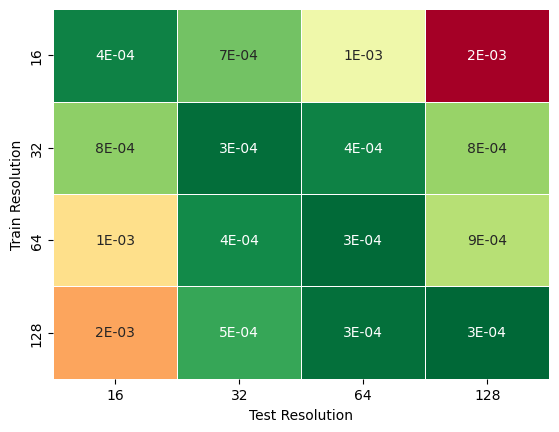

In [76]:
norm = TwoSlopeNorm(vcenter=-5e-3)
norm = LogNorm()
sns.heatmap(
    pivot,  # norm=norm,
    cmap='RdYlGn_r',
    linewidths=0.5,
    fmt='.0E',
    annot=pivot,
    cbar=False,
)

In [67]:
np.log10(pivot)

Test Resolution        16        32        64        128
Train Resolution                                        
16               -3.430160 -3.154165 -2.930354 -2.646593
32               -3.105617 -3.538460 -3.426556 -3.087127
64               -2.835880 -3.390818 -3.562123 -3.034584
128              -2.774555 -3.267605 -3.526926 -3.585316

In [68]:
pivot

Test Resolution        16        32        64        128
Train Resolution                                        
16                0.000371  0.000701  0.001174  0.002256
32                0.000784  0.000289  0.000374  0.000818
64                0.001459  0.000407  0.000274  0.000923
128               0.001681  0.000540  0.000297  0.000260

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


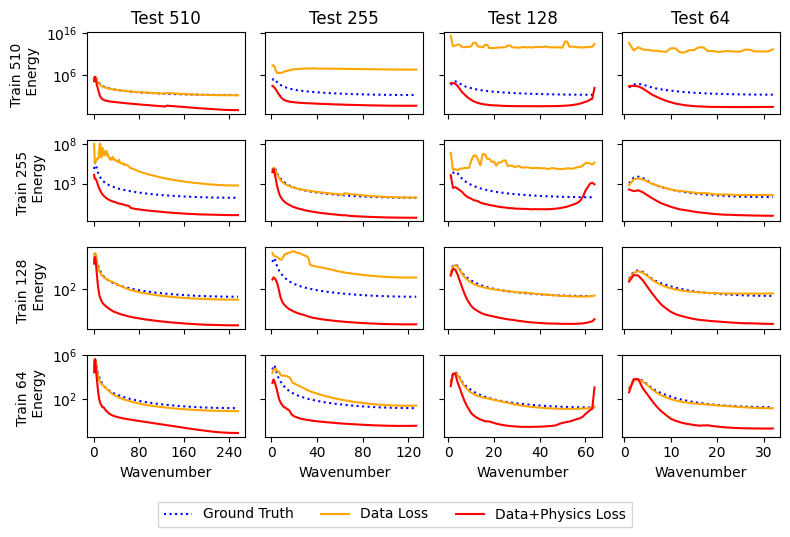

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


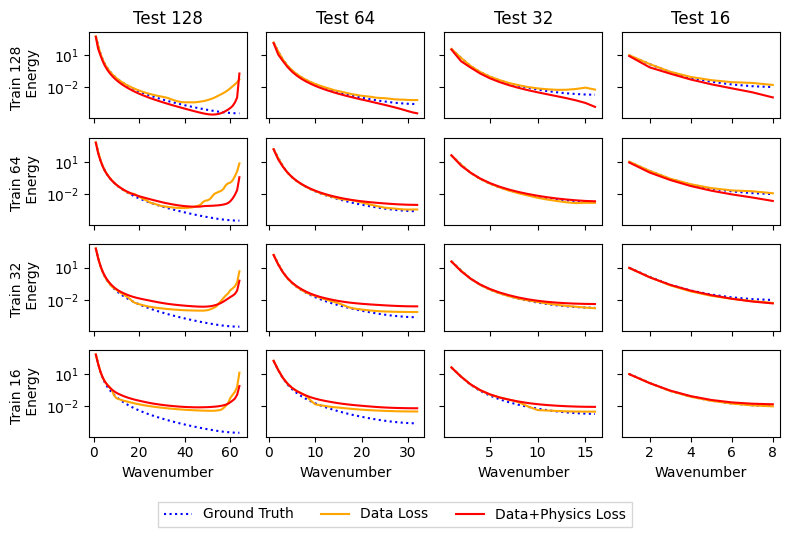

1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


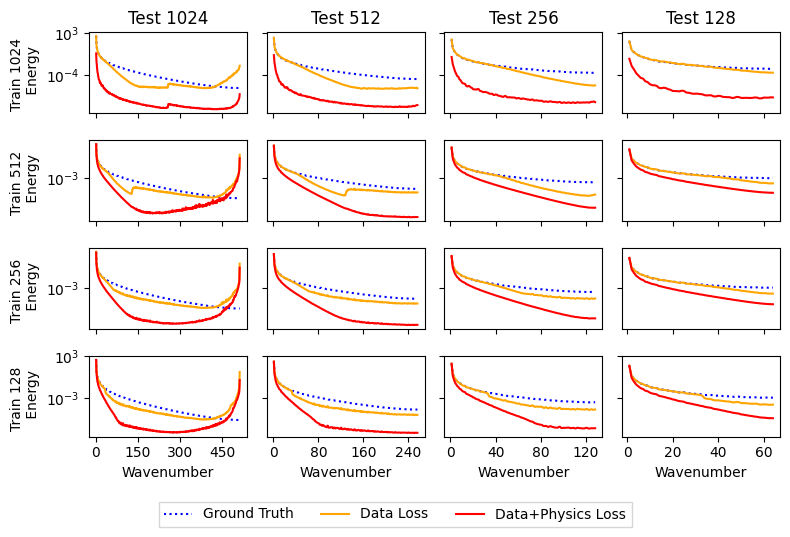

finished_exp=96, total_exp=96, 100.0 %


In [87]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
for dataset_name in [
    #'ns_pdebench',
    'incomp_ns_pdebench',
    'darcy_pdebench',
    'burgers_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, 'mse')
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]

    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]

    for epoch in [150]:  # 0, 50, 100, 250, 500
        fig, axes = plt.subplots(
            nrows=4, ncols=4, sharey='row', sharex='col', figsize=(8, 5)
        )
        for x_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params,
                loss_name='na',
            )
            test_loader = DataLoader(dataset, batch_size=1)

            for y_idx, img_size in enumerate(range(len(img_sizes))):
                if y_idx == 3:
                    axes[y_idx, x_idx].set_xlabel('Wavenumber')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(
                        f'Train {(img_sizes[img_size])} \n Energy'
                    )
                if y_idx == 0:
                    axes[y_idx, x_idx].set_title(
                        f'Test {(img_sizes[test_size])}'
                    )

                train_resolutions = [0, 0, 0, 0]
                train_resolutions[img_size] = 1
                train_resolutions = ''.join(str(train_resolutions).split())
                offset = 0
                if initial_steps == 1:
                    offset = 1
                label_spectrum = energy_curve_func(
                    torch.concat(
                        [
                            test_loader.dataset[i]['y'][
                                :, initial_steps - offset :, ...
                            ]
                            for i in range(len(test_loader))
                        ]
                    )
                )

                x = np.linspace(1, len(label_spectrum), len(label_spectrum))
                axes[y_idx, x_idx].plot(
                    x,
                    label_spectrum,
                    label='Ground Truth',
                    color='blue',
                    linestyle=':',
                )
                for _y_idx, loss in enumerate(['mse', 'pinn']):
                    (
                        model_name,
                        in_channels,
                        out_channels,
                        initial_steps,
                        loss,
                        batch_size,
                        lr,
                        wd,
                        pinn_loss_w,
                    ) = get_dataset_info(dataset_name, loss)
                    lr = str(lr).replace('.', '')
                    pinn_loss_weights = [pinn_loss_w]
                    # if 'pinn' in loss:
                    #    pinn_loss_weights = ['05', '025', '01']
                    for pinn_loss_weight in pinn_loss_weights:
                        loss_type = 'Data Loss'
                        col = 'orange'
                        if 'pinn' in loss:
                            loss_type = 'Data+Physics Loss'
                            col = 'red'

                        max_mode = img_sizes[img_size] // 2
                        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                        ckpt_pth = ckpt_pth.replace('.', '')
                        model = get_model(
                            model_name=model_name,
                            max_modes=max_mode,
                            hidden_channels=32,
                            in_channels=in_channels,
                            out_channels=out_channels,
                        )

                        # ckpt_dict = load_latest_ckpt(ckpt_pth)
                        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                        total_exp += 1
                        if not os.path.exists(ckpt_file):
                            print('waiting for experiment: ', ckpt_file)
                            continue
                        # print("FINISHED: ", ckpt_file)
                        finished_exp += 1
                        ckpt_dict = torch.load(
                            ckpt_file,
                            weights_only=False,
                        )
                        model.load_state_dict(ckpt_dict['model_state_dict'])
                        model = model.to(device)
                        model = model.eval()

                        # get model pred
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )  # .squeeze()

                        model_pred_spectrum = energy_curve_func(
                            model_preds_test  # .squeeze()
                        )

                        axes[y_idx, x_idx].set_yscale('log')
                        axes[y_idx, x_idx].plot(
                            x,
                            model_pred_spectrum,
                            label=f'{loss_type}',
                            color=col,
                        )
                        axes[y_idx, x_idx].xaxis.set_major_locator(
                            ticker.MaxNLocator(integer=True, nbins=4)
                        )

                        handles, labels = axes[
                            y_idx, x_idx
                        ].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        # fig.suptitle(f'{dataset_name}')
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_pinn_vs_no_pinn_label_spectrums.pdf',
            bbox_inches='tight',
            dpi=300,
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

2d energy
dataset_name='darcy_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000
2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


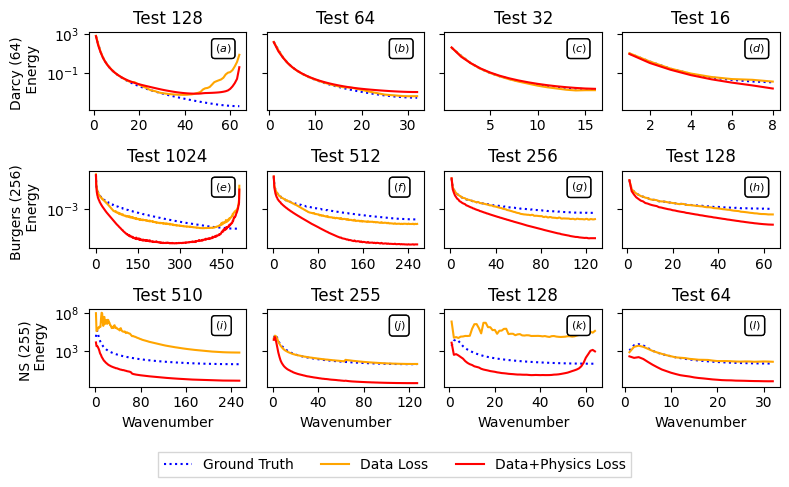

In [11]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
subplot_labels = ['a', 'b', 'c', 'd','e', 'f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(
    nrows=3, ncols=4, sharey='row', sharex=False, figsize=(8, 4.5) # 5
)
for y_idx, dataset_name in enumerate(
    [
        'darcy_pdebench',
        'burgers_pdebench',
        'incomp_ns_pdebench',
    ]
):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, 'mse')
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
        train_size = 1
        title = 'NS'

    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]

    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        train_size = 1
        title = 'Darcy'

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        train_size = 2
        title = 'Burgers'

    for epoch in [150]:  # 0, 50, 100, 250, 500
        for x_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params,
                loss_name='na',
            )
            test_loader = DataLoader(dataset, batch_size=1)

            # for _y_idx, img_size in enumerate(range(len(img_sizes))):
            if y_idx == 2:
                axes[y_idx, x_idx].set_xlabel('Wavenumber')
            if x_idx == 0:
                axes[y_idx, x_idx].set_ylabel(
                    f'{title} ({img_sizes[train_size]}) \n Energy'
                )
            axes[y_idx, x_idx].set_title(f'Test {(img_sizes[test_size])}')

            train_resolutions = [0, 0, 0, 0]
            train_resolutions[train_size] = 1
            train_resolutions = ''.join(str(train_resolutions).split())
            offset = 0
            if initial_steps == 1:
                offset = 1
            label_spectrum = energy_curve_func(
                torch.concat(
                    [
                        test_loader.dataset[i]['y'][
                            :, initial_steps - offset :, ...
                        ]
                        for i in range(len(test_loader))
                    ]
                )
            )

            x = np.linspace(1, len(label_spectrum), len(label_spectrum))
            axes[y_idx, x_idx].plot(
                x,
                label_spectrum,
                label='Ground Truth',
                color='blue',
                linestyle=':',
            )
            for _y_idx, loss in enumerate(['mse', 'pinn']):
                (
                    model_name,
                    in_channels,
                    out_channels,
                    initial_steps,
                    loss,
                    batch_size,
                    lr,
                    wd,
                    pinn_loss_w,
                ) = get_dataset_info(dataset_name, loss)
                lr = str(lr).replace('.', '')
                pinn_loss_weights = [pinn_loss_w]
                # if 'pinn' in loss:
                #    pinn_loss_weights = ['05', '025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    loss_type = 'Data Loss'
                    col = 'orange'
                    if 'pinn' in loss:
                        loss_type = 'Data+Physics Loss'
                        col = 'red'

                    max_mode = img_sizes[train_size] // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_pth = ckpt_pth.replace('.', '')
                    model = get_model(
                        model_name=model_name,
                        max_modes=max_mode,
                        hidden_channels=32,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        latent_size="-",
                        img_size='-',
                    )

                    # ckpt_dict = load_latest_ckpt(ckpt_pth)
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print('waiting for experiment: ', ckpt_file)
                        continue
                    # print("FINISHED: ", ckpt_file)
                    finished_exp += 1
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])
                    model = model.to(device)
                    model = model.eval()

                    # get model pred
                    model_preds_test = get_model_preds(
                        test_loader, model, device, initial_steps
                    )  # .squeeze()

                    model_pred_spectrum = energy_curve_func(
                        model_preds_test  # .squeeze()
                    )

                    axes[y_idx, x_idx].set_yscale('log')
                    axes[y_idx, x_idx].plot(
                        x,
                        model_pred_spectrum,
                        label=f'{loss_type}',
                        color=col,
                    )
                    axes[y_idx, x_idx].annotate(
                        f'$({subplot_labels[x_idx+(y_idx*4)]})$',
                        xy=(0.8, 0.75),
                        xycoords='axes fraction',
                        # textcoords='offset points',
                        size=8,
                        bbox=dict(
                            boxstyle='round',
                            facecolor='white',
                            edgecolor='black',
                        ),
                    )
                    axes[y_idx, x_idx].xaxis.set_major_locator(
                        ticker.MaxNLocator(integer=True, nbins=4)
                    )

                    handles, labels = axes[
                        y_idx, x_idx
                    ].get_legend_handles_labels()

fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.0),
    fancybox=False,
    shadow=False,
    ncol=4,
)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/summary_pinn_vs_no_pinn_label_spectrums.pdf',
    bbox_inches='tight',
    dpi=300,
)

1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


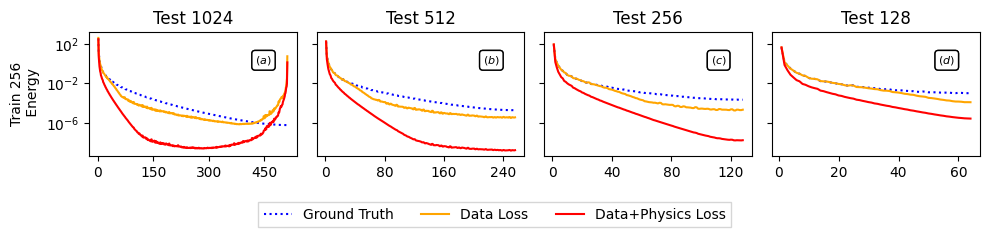

In [13]:
colors = ['red', 'green', 'blue', 'purple', 'brown', 'orange', 'pink']
total_exp = 0
finished_exp = 0
subplot_labels = ['a', 'b', 'c', 'd','e', 'f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(
    nrows=1, ncols=4, sharey='row', sharex=False, figsize=(10, 2) # 5
)
for y_idx, dataset_name in enumerate(
    [
        #'darcy_pdebench',
        'burgers_pdebench',
        #'incomp_ns_pdebench',
    ]
):
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    # if dataset_name == 'incomp_ns_pdebench':

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        _,
        _,
        _,
    ) = get_dataset_info(dataset_name, 'mse')
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
        train_size = 1
        title = 'NS'

    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]

    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        train_size = 1
        title = 'Darcy'

    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        train_size = 2
        title = 'Burgers'

    for epoch in [150]:  # 0, 50, 100, 250, 500
        for x_idx, test_size in enumerate(range(len(img_sizes))):
            # get data
            test_resolutions = [0, 0, 0, 0]
            test_resolutions[test_size] = 1
            dataset = get_dataset(
                dataset_name=dataset_name,
                filter_lim=-1,
                img_size=test_size,
                downsample_dim=-1,
                train=False,
                initial_steps=initial_steps,
                model_name=model_name,
                darcy_forcing_term=darcy_forcing_term,
                burger_viscosity=burger_viscosity,
                batch_size=batch_size,
                seed=0,
                resolution_ratios=test_resolutions,
                comp_ns_params=comp_ns_params,
                loss_name='na',
            )
            test_loader = DataLoader(dataset, batch_size=1)

            # for _y_idx, img_size in enumerate(range(len(img_sizes))):
            if y_idx == 2:
                axes[x_idx].set_xlabel('Wavenumber')
            if x_idx == 0:
                axes[x_idx].set_ylabel(
                    #f'{title} ({img_sizes[train_size]}) \n Energy'
                    f'Train {img_sizes[train_size]}\n Energy'
                )
            axes[x_idx].set_title(f'Test {(img_sizes[test_size])}')

            train_resolutions = [0, 0, 0, 0]
            train_resolutions[train_size] = 1
            train_resolutions = ''.join(str(train_resolutions).split())
            offset = 0
            if initial_steps == 1:
                offset = 1
            label_spectrum = energy_curve_func(
                torch.concat(
                    [
                        test_loader.dataset[i]['y'][
                            :, initial_steps - offset :, ...
                        ]
                        for i in range(len(test_loader))
                    ]
                )
            )

            x = np.linspace(1, len(label_spectrum), len(label_spectrum))
            axes[x_idx].plot(
                x,
                label_spectrum,
                label='Ground Truth',
                color='blue',
                linestyle=':',
            )
            for _y_idx, loss in enumerate(['mse', 'pinn']):
                (
                    model_name,
                    in_channels,
                    out_channels,
                    initial_steps,
                    loss,
                    batch_size,
                    lr,
                    wd,
                    pinn_loss_w,
                ) = get_dataset_info(dataset_name, loss)
                lr = str(lr).replace('.', '')
                pinn_loss_weights = [pinn_loss_w]
                # if 'pinn' in loss:
                #    pinn_loss_weights = ['05', '025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    loss_type = 'Data Loss'
                    col = 'orange'
                    if 'pinn' in loss:
                        loss_type = 'Data+Physics Loss'
                        col = 'red'

                    max_mode = img_sizes[train_size] // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_pth = ckpt_pth.replace('.', '')
                    model = get_model(
                        model_name=model_name,
                        max_modes=max_mode,
                        hidden_channels=32,
                        in_channels=in_channels,
                        out_channels=out_channels,
                        latent_size="-",
                        img_size='-',
                    )

                    # ckpt_dict = load_latest_ckpt(ckpt_pth)
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print('waiting for experiment: ', ckpt_file)
                        continue
                    # print("FINISHED: ", ckpt_file)
                    finished_exp += 1
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])
                    model = model.to(device)
                    model = model.eval()

                    # get model pred
                    model_preds_test = get_model_preds(
                        test_loader, model, device, initial_steps
                    )  # .squeeze()

                    model_pred_spectrum = energy_curve_func(
                        model_preds_test  # .squeeze()
                    )

                    axes[x_idx].set_yscale('log')
                    axes[x_idx].plot(
                        x,
                        model_pred_spectrum,
                        label=f'{loss_type}',
                        color=col,
                    )
                    axes[x_idx].annotate(
                        f'$({subplot_labels[x_idx+(y_idx*4)]})$',
                        xy=(0.8, 0.75),
                        xycoords='axes fraction',
                        # textcoords='offset points',
                        size=8,
                        bbox=dict(
                            boxstyle='round',
                            facecolor='white',
                            edgecolor='black',
                        ),
                    )
                    axes[x_idx].xaxis.set_major_locator(
                        ticker.MaxNLocator(integer=True, nbins=4)
                    )

                    handles, labels = axes[
                        x_idx
                    ].get_legend_handles_labels()

fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.0),
    fancybox=False,
    shadow=False,
    ncol=4,
)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/burgers_main_text_summary_pinn_vs_no_pinn_label_spectrums.pdf',
    bbox_inches='tight',
    dpi=300,
)

# Compound aliasing over time w/ Burgers/Incompressible NS/Compressible NS

TODO: show that aliasing gets worse over time w/ autoregressive inference

NOTE: normalizatoin causes NAN spectrums for residuals???

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


/tmp/ipykernel_538503/2257035103.py:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.sharey(plt.subplot(3, 4, 4))


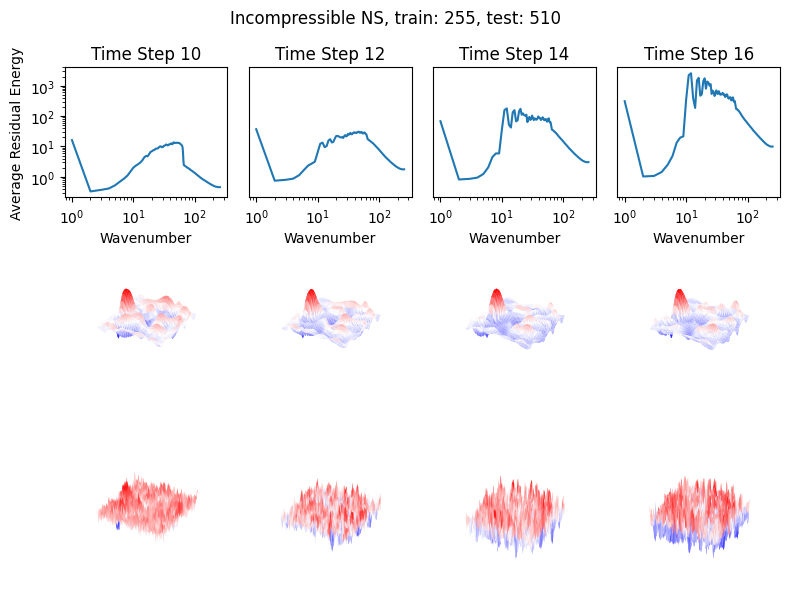

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109


KeyboardInterrupt: 

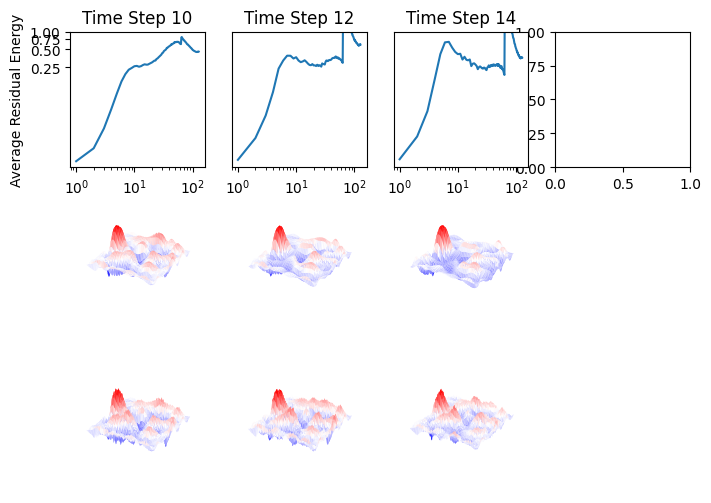

In [10]:
for test_res in range(4):
    for dataset_name in ['incomp_ns_pdebench']:
        # fig, axs = plt.subplots(4, 4, sharey='row', sharex=False, figsize=(10, 10))
        fig = plt.figure(1, figsize=(8, 6))
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve

        print(f'{dataset_name=}')
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, 'mse')

        if dataset_name == 'incomp_ns_pdebench':
            img_sizes = [64, 128, 255, 510]
            batch_size = 4
            title = 'Incompressible NS'
            max_mode = 255 // 2  # TODO Change

        test_resolution = img_sizes
        train_resolutions = '[0,1,0,0]'
        downsample_dim = -1
        filter_lim = -1
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
        ckpt_dir = ckpt_dir.replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        model = get_model(
            model_name=model_name,
            max_modes=max_mode,
            hidden_channels=32,
            in_channels=in_channels,
            out_channels=out_channels,
            latent_size="-",
            img_size="-",
        )

        # ckpt_dict = load_latest_ckpt(ckpt_pth)
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            print('waiting for experiment: ', ckpt_file)
            continue
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()

        # Test at specific resolution
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[test_res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
            loss_name='na',
        )

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        for x_idx, t in enumerate(range(4)):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[:, initial_steps + (t) * 2, ...].to(device)

            residuals = model_output[:, (t) * 2, ...] - labels  # / labels

            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)

            x = np.linspace(1, len(residual_spectrum), len(residual_spectrum))
            ax = plt.subplot(3, 4, x_idx + 1)
            ax.plot(x, residual_spectrum / label_spectrum)
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.sharey(plt.subplot(3, 4, 4))
            if x_idx > 0:
                ax.get_yaxis().set_visible(False)
            ax.set_title(f'Time Step {initial_steps + t * 2}')
            ax.set_xlabel('Wavenumber')

            # 3D render of label
            dim = labels.shape[-1]
            # Create a 1D array with 25 evenly spaced numbers between 0 and 1
            array_1d = np.linspace(0, 1, num=dim * dim)
            # Reshape the 1D array into a 2D array
            x = array_1d.reshape(dim, dim)
            y = x.copy().T
            z = labels[0, 0, ...].cpu()
            ax = plt.subplot(3, 4, x_idx + 1 + 4, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()

            # model prediction
            z = model_output[0, (t) * 2, ...][0, ...].cpu()
            ax = plt.subplot(3, 4, x_idx + 1 + 8, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()

            plt.subplot(3, 4, 1).set_ylabel('Average Residual Energy')
            plt.subplot(3, 4, 5).set_zlabel('Example Label')
            plt.subplot(3, 4, 9).set_zlabel('Example Model Prediction')

        fig.suptitle(f'{title}, train: 255, test: {dim}')
        plt.tight_layout()
        plt.show()

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


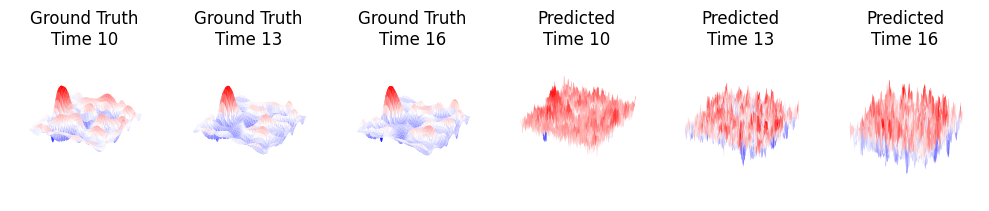

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109


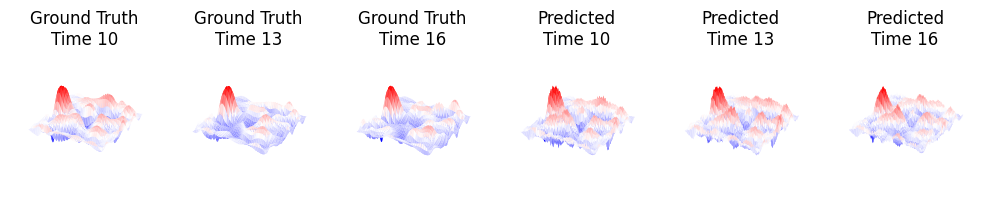

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109


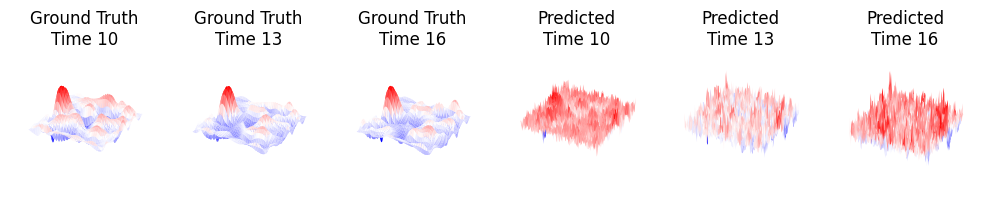

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


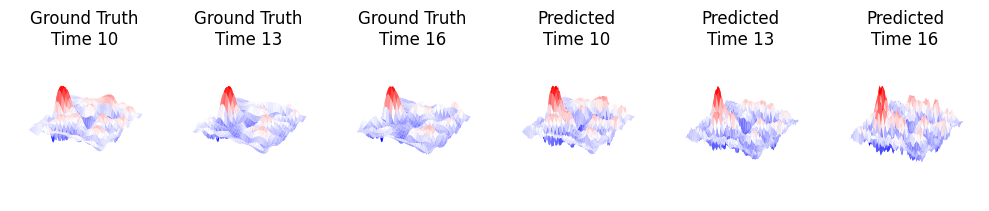

In [8]:
for test_res in [0,1,2,3]: #range(4):
    for dataset_name in ['incomp_ns_pdebench']:
        # fig, axs = plt.subplots(4, 4, sharey='row', sharex=False, figsize=(10, 10))
        num_rows = 1
        fig = plt.figure(1, figsize=(10, 2))
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve

        print(f'{dataset_name=}')
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, 'mse')

        if dataset_name == 'incomp_ns_pdebench':
            img_sizes = [510, 255,128,64]
            batch_size = 4
            title = 'Incompressible NS'
            max_mode = 255 // 2  # TODO Change

        train_resolutions = '[0,1,0,0]'
        downsample_dim = -1
        filter_lim = -1
        pinn_loss_weight = '05'
        test_resolution = img_sizes[test_res]
        epoch = 150
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
        ckpt_dir = ckpt_dir.replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        model = get_model(
            model_name=model_name,
            max_modes=max_mode,
            hidden_channels=32,
            in_channels=in_channels,
            out_channels=out_channels,
            latent_size="-",
            img_size="-",
        )

        # ckpt_dict = load_latest_ckpt(ckpt_pth)
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            print('waiting for experiment: ', ckpt_file)
            continue
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()

        # Test at specific resolution
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[test_res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
            loss_name='na',
        )

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        time_steps = 3
        for x_idx, t in enumerate(range(time_steps)):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[:, initial_steps + (t) * 3, ...].to(device)

            residuals = model_output[:, (t) * 3, ...] - labels  # / labels

            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)

            # 3D render of label
            dim = labels.shape[-1]
            # Create a 1D array with 25 evenly spaced numbers between 0 and 1
            array_1d = np.linspace(0, 1, num=dim * dim)
            # Reshape the 1D array into a 2D array
            x = array_1d.reshape(dim, dim)
            y = x.copy().T
            z = labels[0, 0, ...].cpu()
            ax = plt.subplot(num_rows, time_steps*2, x_idx + 1 , projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()
            ax.set_title(f"Ground Truth\nTime {initial_steps + t * 3}")

            # model prediction
            z = model_output[0, (t) * 2, ...][0, ...].cpu()
            ax = plt.subplot(num_rows, time_steps*2, x_idx + 1 + time_steps, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()
            ax.set_title(f"Predicted\nTime {initial_steps + (t) * 3}")
            
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_test_{test_resolution}_train_255.pdf',  # .png
            dpi=300,
            bbox_inches='tight',
        )

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109


/tmp/ipykernel_666395/3197085080.py:5: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  fig = plt.figure(1, figsize=(8, 2))


2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109


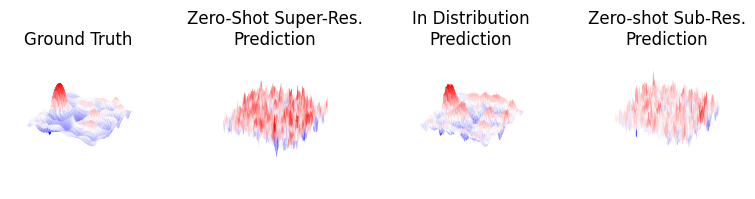

In [21]:
for x_idx, test_res in enumerate([0,1,2]): #range(4):
    for dataset_name in ['incomp_ns_pdebench']:
        # fig, axs = plt.subplots(4, 4, sharey='row', sharex=False, figsize=(10, 10))
        num_rows = 1
        fig = plt.figure(1, figsize=(8, 2))
        if 'burgers' in dataset_name:
            print('1d energy')
            energy_curve_func = get_energy_curve_1d
        else:
            print('2d energy')
            energy_curve_func = get_energy_curve

        print(f'{dataset_name=}')
        (
            model_name,
            in_channels,
            out_channels,
            initial_steps,
            loss,
            batch_size,
            lr,
            wd,
            _,
        ) = get_dataset_info(dataset_name, 'mse')

        if dataset_name == 'incomp_ns_pdebench':
            img_sizes = [510, 255,128,64]
            batch_size = 4
            title = 'Incompressible NS'
            max_mode = 255 // 2  # TODO Change

        train_resolutions = '[0,1,0,0]'
        downsample_dim = -1
        filter_lim = -1
        pinn_loss_weight = '05'
        test_resolution = img_sizes[test_res]
        epoch = 150
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
        ckpt_dir = ckpt_dir.replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        model = get_model(
            model_name=model_name,
            max_modes=max_mode,
            hidden_channels=32,
            in_channels=in_channels,
            out_channels=out_channels,
            latent_size="-",
            img_size="-",
        )

        # ckpt_dict = load_latest_ckpt(ckpt_pth)
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            print('waiting for experiment: ', ckpt_file)
            continue
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()

        # Test at specific resolution
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[test_res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
            loss_name='na',
        )

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        time_steps = 3
        for _x_idx, t in enumerate([1,]):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[:, initial_steps + (t) * 3, ...].to(device)

            residuals = model_output[:, (t) * 3, ...] - labels  # / labels

            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)

            # 3D render of label
            dim = labels.shape[-1]
            # Create a 1D array with 25 evenly spaced numbers between 0 and 1
            array_1d = np.linspace(0, 1, num=dim * dim)
            # Reshape the 1D array into a 2D array
            x = array_1d.reshape(dim, dim)
            y = x.copy().T
            z = labels[0, 0, ...].cpu()
            ax = plt.subplot(num_rows, 4, 1, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()
            ax.set_title(f"Ground Truth")

            # model prediction
            z = model_output[0, (t) * 2, ...][0, ...].cpu()
            ax = plt.subplot(num_rows, 4, 1 + x_idx + 1, projection='3d')
            ax.plot_surface(x, y, z, cmap='bwr')
            ax.set_axis_off()
            if test_resolution == 510:
                title = "Zero-Shot Super-Res.\nPrediction"
            if test_resolution == 255:
                title = "In Distribution\nPrediction"
            if test_resolution == 128:
                title = "Zero-shot Sub-Res.\nPrediction"
            ax.set_title(f"{title}")
            
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/{dataset_name}_super_sub_res_example.pdf',  # .png
    dpi=300,
    bbox_inches='tight',
)

1d energy
dataset_name='burgers_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 1, 0, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 1, 0]
self.num_samples=1000
resolution_ratios=[0, 0, 0, 1]
self.num_samples=1000


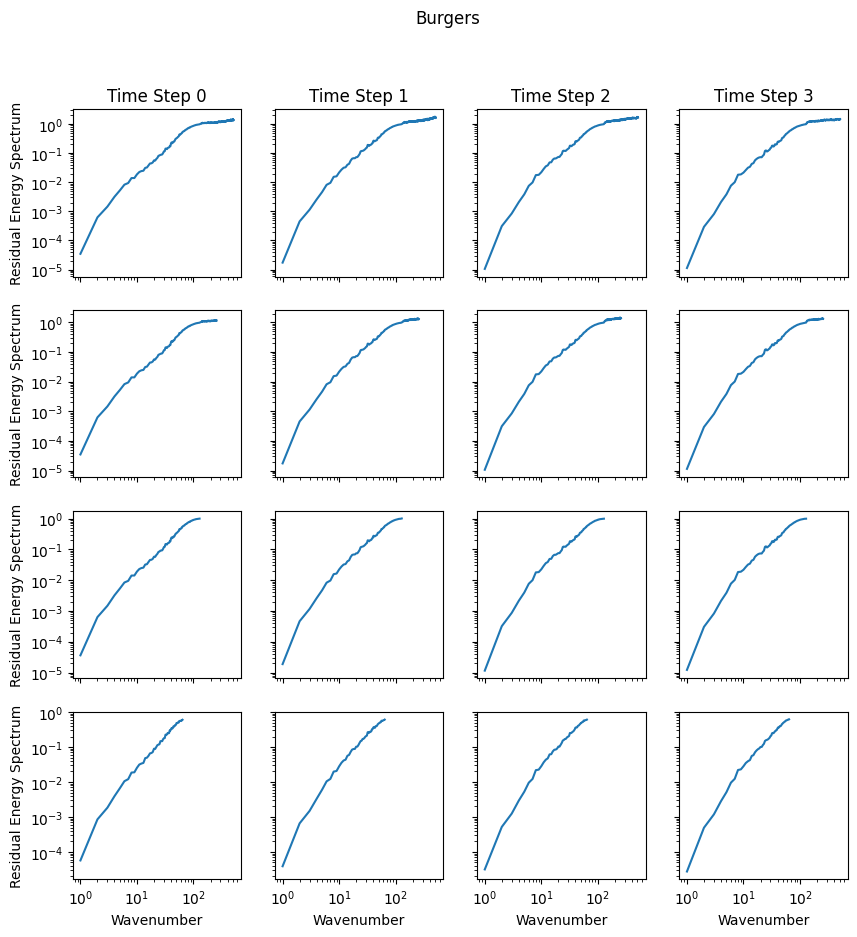

2d energy
dataset_name='incomp_ns_pdebench'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[0, 1, 0, 0]
self.num_samples=109
resolution_ratios=[0, 0, 1, 0]
self.num_samples=109
resolution_ratios=[0, 0, 0, 1]
self.num_samples=109


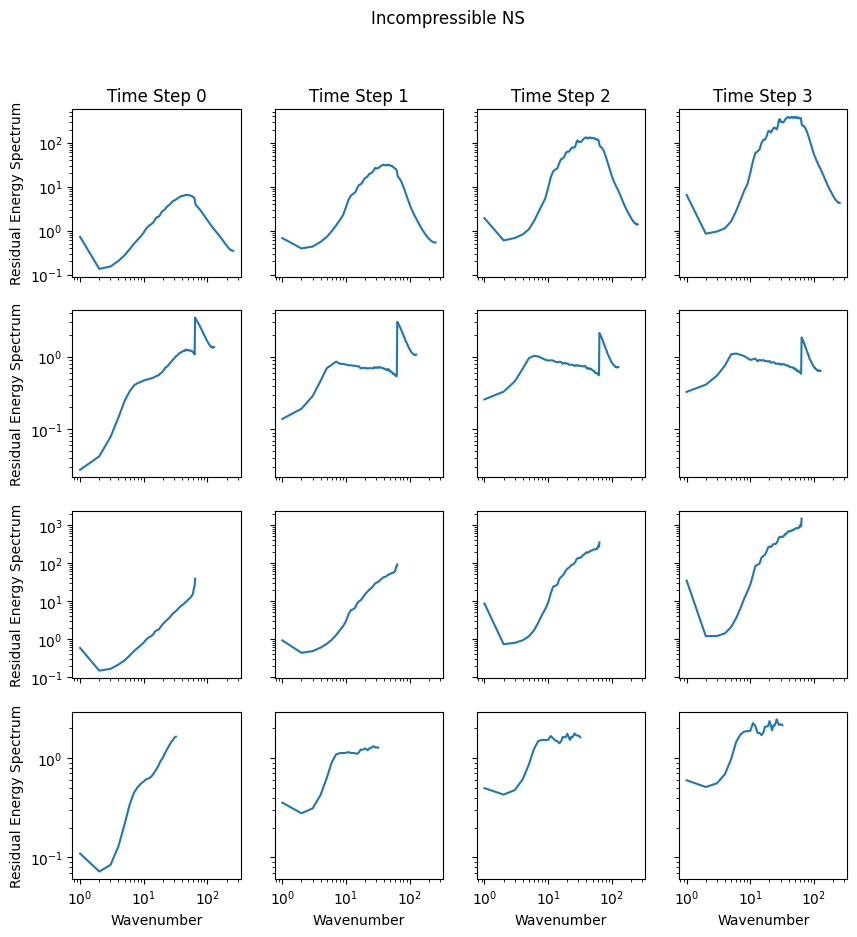

2d energy
dataset_name='ns_pdebench'
waiting for experiment:  /pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_4_ns_pdebench_-1_-1_256_FNO2D_40_4_05_10_single_0_1_0_0//150_ckpt.pth


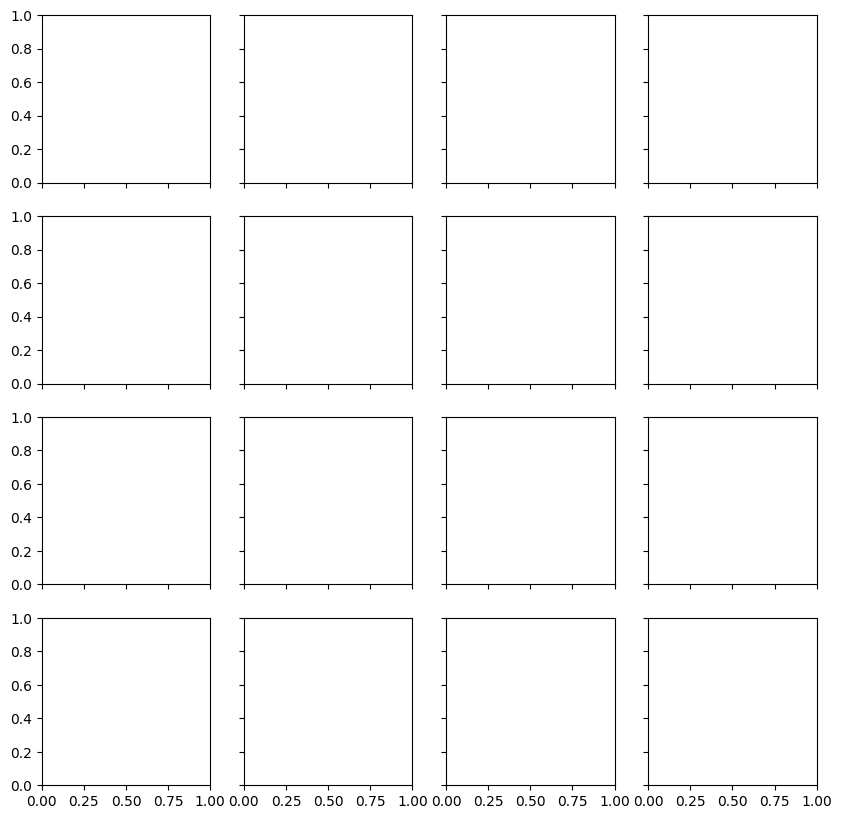

In [10]:
for dataset_name in ['burgers_pdebench', 'incomp_ns_pdebench', 'ns_pdebench']:
    fig, axs = plt.subplots(4, 4, sharey=True, sharex='col', figsize=(10, 10))
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    print(f'{dataset_name=}')
    batch_size = 128
    batch_size = 128
    in_channels = 10
    out_channels = 1
    initial_steps = 10
    filter_lim = -1
    downsample_dim = -1

    model_name = 'FNO2D'
    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    comp_ns_params = ['Turb', 1.0, 1e-08, 1e-08, 'periodic', 512]
    seed = 0
    lr = '0001'
    wd = 1e-5
    pinn_loss_weight = '05'
    loss = 'mse'

    epoch = 150

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        batch_size = 64
        model_name = 'FNO1D'
        title = 'Burgers'
        max_mode = 512 // 2  # TODO Change

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        batch_size = 4
        title = 'Incompressible NS'
        max_mode = 255 // 2  # TODO Change

    if dataset_name == 'ns_pdebench':
        batch_size = 4
        in_channels = 40
        out_channels = 4
        title = 'Compressible NS'
        max_mode = 512 // 2  # TODO Change

    train_resolutions = '[0,1,0,0]'

    # ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{train_resolutions}'
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
    ckpt_dir = ckpt_dir.replace('.', '')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    model = get_model(
        model_name=model_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
    )

    # ckpt_dict = load_latest_ckpt(ckpt_pth)
    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
    if not os.path.exists(ckpt_file):
        print('waiting for experiment: ', ckpt_file)
        continue
    ckpt_dict = torch.load(
        ckpt_file,
        weights_only=False,
    )
    model.load_state_dict(ckpt_dict['model_state_dict'])
    model = model.to(device)
    model = model.eval()

    # iterate through resolutions
    for y_idx, res in enumerate(range(4)):
        test_resolutions = [0, 0, 0, 0]
        test_resolutions[res] = 1
        dataset = get_dataset(
            dataset_name=dataset_name,
            filter_lim=filter_lim,
            img_size='na',
            downsample_dim=downsample_dim,
            train=False,
            initial_steps=initial_steps,
            model_name=model_name,
            darcy_forcing_term=darcy_forcing_term,
            burger_viscosity=burger_viscosity,
            batch_size=4,
            seed=0,
            resolution_ratios=test_resolutions,
            comp_ns_params=comp_ns_params,
            loss_name='na',
        )

        test_loader = torch.utils.data.DataLoader(dataset, batch_size=1)
        model_output = get_model_preds(
            test_loader=test_loader,
            model=model,
            device=device,
            initial_steps=initial_steps,
        )
        # iteratate through time
        for x_idx, t in enumerate(range(4)):
            labels = torch.concat(
                [dataset[i]['y'] for i in range(len(dataset))]
            )[
                :, initial_steps + (t) * 2 : initial_steps + (t + 1) * 2, ...
            ].to(device)
            if dataset_name == 'ns_pdebench':
                labels = torch.concat(
                    [dataset[i]['y'] for i in range(len(dataset))]
                )[
                    :,
                    initial_steps + (t) * 2 : initial_steps + (t + 1) * 2,
                    2,
                    ...,
                ].to(device)
                # choose specific channel [density, pressure, X Vel, Y Vel]
            residuals = (
                model_output[:, (t) * 2 : (t + 1) * 2, ...] - labels
            )  # / labels

            # label_spectrum = energy_curve_func(labels)
            residual_spectrum = energy_curve_func(residuals)
            label_spectrum = energy_curve_func(labels)

            x = np.linspace(1, len(residual_spectrum), len(residual_spectrum))
            axs[y_idx, x_idx].plot(x, residual_spectrum / label_spectrum)

            axs[y_idx, x_idx].set_yscale('log')
            axs[y_idx, x_idx].set_xscale('log')

            if y_idx == 3:
                axs[y_idx, x_idx].set_xlabel('Wavenumber')
            if y_idx == 0:
                axs[y_idx, x_idx].set_title(f'Time Step {t}')
            if x_idx == 0:
                axs[y_idx, x_idx].set_ylabel('Residual Energy Spectrum')

    fig.suptitle(title)
    plt.show()

# Filter/ Downsample Experiments

TODO: show that w/ filters/downsampling the 

2d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

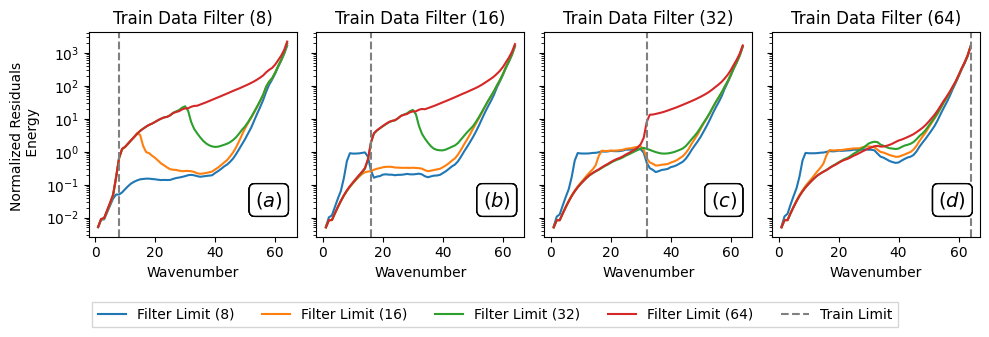

1d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

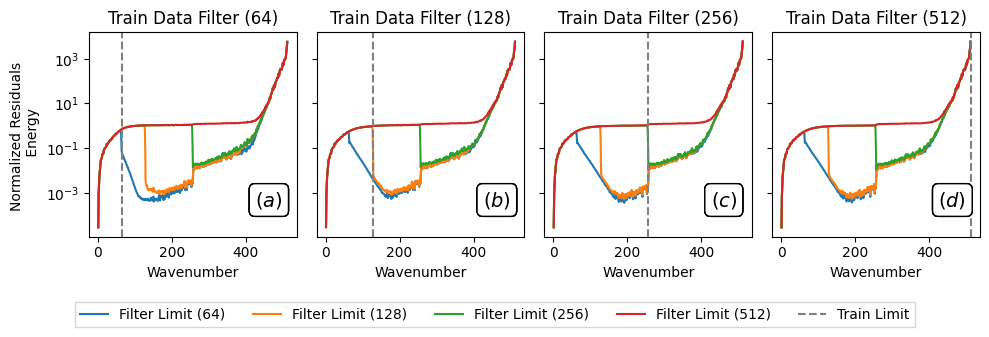

2d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
re

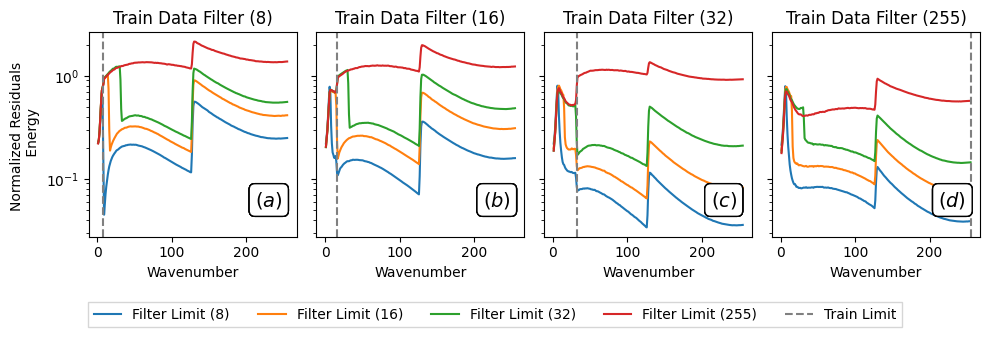

finished_exp=12, total_exp=12, 100.0 %


In [2]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0
subplot_labels = ['a', 'b', 'c', 'd']

for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 32  # half of 64 // 2
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [64, 128, 255, -1]  # 85 finished
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [32, 64, 128, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    train_resolutions = [1, 0, 0, 0]
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=True, sharex='col', figsize=(10, 3)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for _y_idx, downsample_dim in enumerate([-1]):
            for x_idx, filter_lim in enumerate(filter_lims):
                if filter_lim == -1 and downsample_dim != -1:
                    continue
                max_mode = img_size // 2
                ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                ckpt_dir = ckpt_dir.replace('.', '')
                ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                total_exp += 1
                if not os.path.exists(ckpt_file):
                    print(f'Does not exists: {ckpt_file}')
                    continue
                finished_exp += 1
                ckpt_name = f'{ckpt_pth}/train_stats.csv'
                df = pd.read_csv(ckpt_name)
                # load model
                model = get_model(
                    model_name=model_name,
                    out_channels=out_channels,
                    in_channels=in_channels,
                    hidden_channels=32,
                    max_modes=max_mode,
                    latent_size='-',
                    img_size='-',
                ).to(device)
                ckpt_dict = torch.load(
                    ckpt_file,
                    weights_only=False,
                )
                model.load_state_dict(ckpt_dict['model_state_dict'])

                # get data at various sizes
                for idx, test_filt in enumerate(filter_lims):
                    dataset = get_dataset(
                        dataset_name=dataset_name,
                        filter_lim=test_filt,
                        img_size='n/a',
                        downsample_dim=-1,
                        train=False,
                        initial_steps=initial_steps,
                        model_name=model_name,
                        darcy_forcing_term=darcy_forcing_term,
                        burger_viscosity=burger_viscosity,
                        batch_size=batch_size,
                        seed=0,
                        resolution_ratios=train_resolutions,
                        loss_name='n/a',
                    )
                    test_loader = DataLoader(dataset, batch_size=1)

                    dataset = get_dataset(
                        dataset_name=dataset_name,
                        filter_lim=-1,
                        img_size='n/a',
                        downsample_dim=-1,
                        train=False,
                        initial_steps=initial_steps,
                        model_name=model_name,
                        darcy_forcing_term=darcy_forcing_term,
                        burger_viscosity=burger_viscosity,
                        batch_size=batch_size,
                        seed=0,
                        resolution_ratios=train_resolutions,
                        loss_name='n/a',
                    )
                    unfilter_test_loader = DataLoader(dataset, batch_size=1)

                    # get model preds
                    model_preds_test = get_model_preds(
                        test_loader, model, device, initial_steps
                    )
                    offset = 0
                    if initial_steps == 1:
                        offset = 1
                    labels = torch.concat(
                        [
                            test_loader.dataset[i]['y'][
                                :, initial_steps - offset :, ...
                            ]
                            for i in range(len(test_loader))
                        ]
                    )
                    unfilter_labels = torch.concat(
                        [
                            unfilter_test_loader.dataset[i]['y'][
                                :, initial_steps - offset :, ...
                            ]
                            for i in range(len(unfilter_test_loader))
                        ]
                    )
                    residuals = model_preds_test - labels.to(device)
                    unfilter_label_spectrum = energy_curve_func(
                        unfilter_labels
                    )
                    residual_spectrum = energy_curve_func(residuals)

                    x = np.linspace(
                        1, len(residual_spectrum), len(residual_spectrum)
                    )
                    axes[x_idx].set_yscale('log')
                    f_lim = test_filt
                    if test_filt == -1:
                        f_lim = max_mode
                    axes[x_idx].plot(
                        x,
                        residual_spectrum / unfilter_label_spectrum,
                        label=f'Filter Limit ({f_lim})',
                    )

                    axes[x_idx].annotate(
                        f'$({subplot_labels[x_idx]})$',
                        xy=(0.8, 0.15),
                        xycoords='axes fraction',
                        # textcoords='offset points',
                        size=14,
                        bbox=dict(
                            boxstyle='round',
                            facecolor='white',
                            edgecolor='black',
                        ),
                    )
                    f_lim = filter_lim
                    if filter_lim == -1:
                        f_lim = max_mode
                    if idx == 3:
                        axes[x_idx].axvline(
                            x=f_lim,
                            color='grey',
                            linestyle='--',
                            label='Train Limit',
                        )
                    axes[x_idx].set_title(f'Train Data Filter ({f_lim})')
                    axes[x_idx].set_xlabel('Wavenumber')
                    if x_idx == 0:
                        axes[x_idx].set_ylabel(
                            'Normalized Residuals \n Energy'
                        )
                    handles, labels = axes[x_idx].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=5,
        )
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_varried_filter_w_max_modes.pdf',
            dpi=300,
            bbox_inches='tight',
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

2d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_16_8_64_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_32_8_64_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_rat

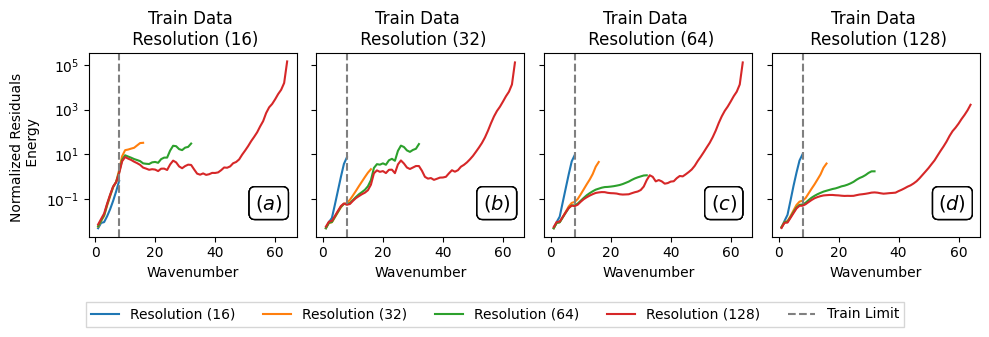

1d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_128_64_512_FNO1D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_64_burgers_pdebench_256_64_512_FNO1D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
re

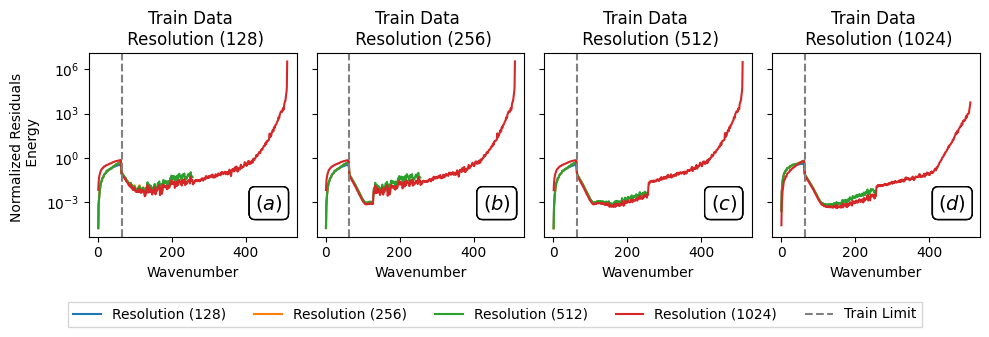

2d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_64_32_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts/001_1e-06_15_05_mse_4_incomp_ns_pdebench_128_32_255_FNO2D_10_1_05_10_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolution_ratios=[1, 0, 0, 0]
self.num_samples=109
resolutio

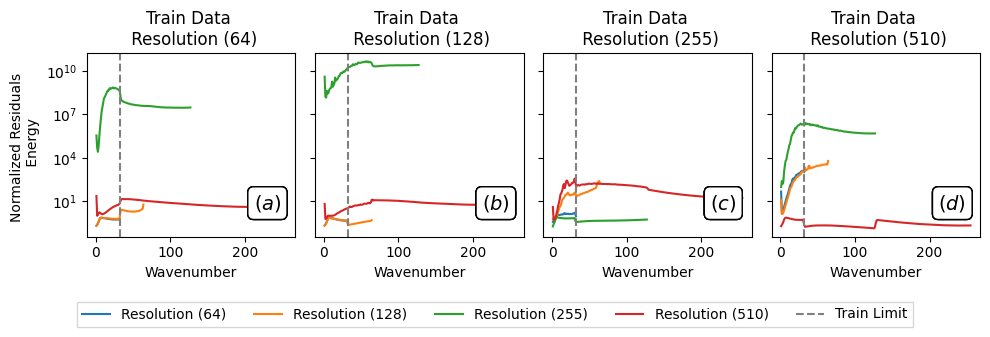

finished_exp=12, total_exp=12, 100.0 %


In [3]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0
subplot_labels = ['a', 'b', 'c', 'd']

for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )

    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 32  # half of 64 // 2
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [64, 128, 255, -1]  # 85 finished
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [16, 32, 64, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    train_resolutions = [1, 0, 0, 0]
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=True, sharex='col', figsize=(10, 3)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for y_idx, max_mode in enumerate([64]):
            for x_idx, downsample_dim in enumerate(downsample_dims):
                for _y_idx, filter_lim in enumerate([fixed_lim]):
                    if filter_lim == -1 and downsample_dim != -1:
                        continue
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_dir = ckpt_dir.replace('.', '')
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print(f'Does not exists: {ckpt_file}')
                        continue
                    finished_exp += 1
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    df = pd.read_csv(ckpt_name)
                    # load model
                    model = get_model(
                        model_name=model_name,
                        out_channels=out_channels,
                        in_channels=in_channels,
                        hidden_channels=32,
                        max_modes=max_mode,
                        latent_size='-',
                        img_size='-',
                    ).to(device)
                    # ckpt_dict = load_latest_ckpt(ckpt_pth)

                    print(f'{ckpt_file=}')
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])

                    # get data at various sizes
                    for idx, test_down in enumerate(downsample_dims):
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=filter_lim,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                            loss_name='n/a',
                        )
                        test_loader = DataLoader(dataset, batch_size=1)

                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=-1,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                            loss_name='n/a',
                        )
                        unfilter_test_loader = DataLoader(
                            dataset, batch_size=1
                        )

                        # get model preds
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )
                        offset = 0
                        if initial_steps == 1:
                            offset = 1
                        labels = torch.concat(
                            [
                                test_loader.dataset[i]['y'][
                                    :, initial_steps - offset :, ...
                                ]
                                for i in range(len(test_loader))
                            ]
                        )
                        label_spectrum = energy_curve_func(labels)
                        unfilter_labels = torch.concat(
                            [
                                unfilter_test_loader.dataset[i]['y'][
                                    :, initial_steps - offset :, ...
                                ]
                                for i in range(len(unfilter_test_loader))
                            ]
                        )
                        residuals = model_preds_test - labels.to(device)
                        unfilter_label_spectrum = energy_curve_func(
                            unfilter_labels
                        )
                        residual_spectrum = energy_curve_func(residuals)

                        x = np.linspace(
                            1, len(residual_spectrum), len(residual_spectrum)
                        )
                        axes[x_idx].set_yscale('log')
                        d_dim = test_down
                        if test_down == -1:
                            d_dim = img_size
                        axes[x_idx].plot(
                            x,
                            residual_spectrum / unfilter_label_spectrum,
                            # label=f'Downsample ({d_dim})',
                            label=f'Resolution ({d_dim})',
                        )
                        axes[x_idx].annotate(
                            f'$({subplot_labels[x_idx]})$',
                            xy=(0.8, 0.15),
                            xycoords='axes fraction',
                            # textcoords='offset points',
                            size=14,
                            bbox=dict(
                                boxstyle='round',
                                facecolor='white',
                                edgecolor='black',
                            ),
                        )
                        if idx == 3:
                            axes[x_idx].axvline(
                                x=filter_lim,
                                color='grey',
                                linestyle='--',
                                label='Train Limit',
                            )
                        d_dim = downsample_dim
                        if downsample_dim == -1:
                            d_dim = img_size

                        axes[x_idx].set_title(
                            f'Train Data \n Resolution ({d_dim})'
                        )
                        axes[x_idx].set_xlabel('Wavenumber')
                        if x_idx == 0:
                            axes[x_idx].set_ylabel(
                                'Normalized Residuals \n Energy'
                            )
                        handles, labels = axes[
                            x_idx
                        ].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=5,
        )
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_varried_downsample_w_max_modes.pdf',
            dpi=300,
            bbox_inches='tight',
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

# Max Modes

2d energy
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.

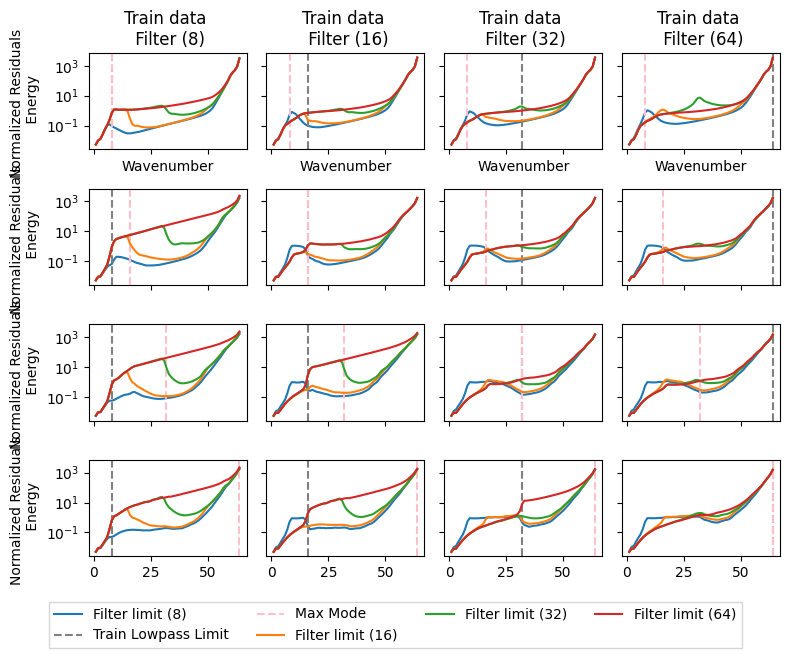

finished_exp=16, total_exp=16, 100.0 %


In [2]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0

for dataset_name in [
    'darcy_pdebench',
    #'burgers_pdebench',
    #'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 32  # half of 64 // 2
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [64, 128, 255, -1]  # 85 finished
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [32, 64, 128, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    train_resolutions = [1, 0, 0, 0]
    fig, axes = plt.subplots(
        nrows=4, ncols=4, sharey=True, sharex='col', figsize=(8, 6)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for y_idx, max_mode in enumerate(
            [img_size // 16, img_size // 8, img_size // 4, img_size // 2]
        ):
            downsample_dim = -1
            for x_idx, filter_lim in enumerate(filter_lims):
                if filter_lim == -1 and downsample_dim != -1:
                    continue
                # max_mode = img_size // 2
                ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                ckpt_dir = ckpt_dir.replace('.', '')
                ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                total_exp += 1
                if not os.path.exists(ckpt_file):
                    print(f'Does not exists: {ckpt_file}')
                    continue
                finished_exp += 1
                ckpt_name = f'{ckpt_pth}/train_stats.csv'
                df = pd.read_csv(ckpt_name)
                # load model
                model = get_model(
                    model_name=model_name,
                    out_channels=out_channels,
                    in_channels=in_channels,
                    hidden_channels=32,
                    max_modes=max_mode,
                ).to(device)
                ckpt_dict = torch.load(
                    ckpt_file,
                    weights_only=False,
                )
                model.load_state_dict(ckpt_dict['model_state_dict'])

                # get data at various sizes
                for idx, test_filt in enumerate(filter_lims):
                    dataset = get_dataset(
                        dataset_name=dataset_name,
                        filter_lim=test_filt,
                        img_size='n/a',
                        downsample_dim=-1,
                        train=False,
                        initial_steps=initial_steps,
                        model_name=model_name,
                        darcy_forcing_term=darcy_forcing_term,
                        burger_viscosity=burger_viscosity,
                        batch_size=batch_size,
                        seed=0,
                        resolution_ratios=train_resolutions,
                        loss_name='n/a',
                    )
                    test_loader = DataLoader(dataset, batch_size=1)

                    dataset = get_dataset(
                        dataset_name=dataset_name,
                        filter_lim=-1,
                        img_size='n/a',
                        downsample_dim=-1,
                        train=False,
                        initial_steps=initial_steps,
                        model_name=model_name,
                        darcy_forcing_term=darcy_forcing_term,
                        burger_viscosity=burger_viscosity,
                        batch_size=batch_size,
                        seed=0,
                        resolution_ratios=train_resolutions,
                        loss_name='n/a',
                    )
                    unfilter_test_loader = DataLoader(dataset, batch_size=1)

                    # get model preds
                    model_preds_test = get_model_preds(
                        test_loader, model, device, initial_steps
                    )
                    offset = 0
                    if initial_steps == 1:
                        offset = 1
                    labels = torch.concat(
                        [
                            test_loader.dataset[i]['y'][
                                :, initial_steps - offset :, ...
                            ]
                            for i in range(len(test_loader))
                        ]
                    )
                    unfilter_labels = torch.concat(
                        [
                            unfilter_test_loader.dataset[i]['y'][
                                :, initial_steps - offset :, ...
                            ]
                            for i in range(len(unfilter_test_loader))
                        ]
                    )
                    residuals = model_preds_test - labels.to(device)
                    unfilter_label_spectrum = energy_curve_func(
                        unfilter_labels
                    )
                    residual_spectrum = energy_curve_func(residuals)

                    x = np.linspace(
                        1, len(residual_spectrum), len(residual_spectrum)
                    )
                    axes[y_idx, x_idx].set_yscale('log')
                    f_lim = test_filt
                    if test_filt == -1:
                        f_lim = img_size // 2
                    axes[y_idx, x_idx].plot(
                        x,
                        residual_spectrum / unfilter_label_spectrum,
                        label=f'Filter limit ({f_lim})',
                    )
                    f_lim = filter_lim
                    if filter_lim == -1:
                        f_lim = img_size // 2
                    if idx == 0:
                        axes[y_idx, x_idx].axvline(
                            x=f_lim,
                            color='grey',
                            linestyle='--',
                            label='Train Lowpass Limit',
                        )
                        axes[y_idx, x_idx].axvline(
                            x=max_mode,
                            color='pink',
                            linestyle='--',
                            label='Max Mode',
                        )
                    if y_idx == 0:
                        axes[y_idx, x_idx].set_title(
                            f'Train data \n Filter ({f_lim})'
                        )
                        axes[y_idx, x_idx].set_xlabel('Wavenumber')
                    if x_idx == 0:
                        axes[y_idx, x_idx].set_ylabel(
                            'Normalized Residuals \n Energy'
                        )
                    handles, labels = axes[
                        y_idx, x_idx
                    ].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_varried_filter_w_varried_max_modes.pdf',
            dpi=300,
            bbox_inches='tight',
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

2d energy
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_16_8_8_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
ckpt_file='/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_32_8_8_FNO2D_1_1_05_1_single_1_0_0_0//150_ckpt.pth'
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratios=[1, 0, 0, 0]
self.num_samples=1000
resolution_ratio

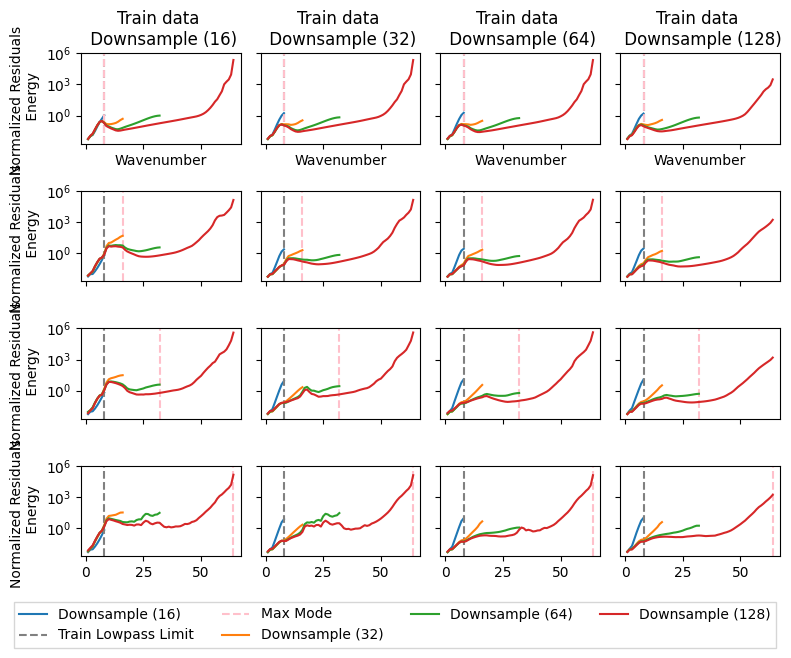

finished_exp=16, total_exp=16, 100.0 %


In [3]:
darcy_forcing_term = 1.0
burger_viscosity = 0.001
seed = 0
total_exp = 0
finished_exp = 0

for dataset_name in [
    'darcy_pdebench',
    #'burgers_pdebench',
    #'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    if 'burgers' in dataset_name:
        print('1d energy')
        energy_curve_func = get_energy_curve_1d
    else:
        print('2d energy')
        energy_curve_func = get_energy_curve

    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )

    if dataset_name == 'darcy_pdebench':
        img_size = 128
        fixed_lim = 8
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [16, 32, 64, -1]  # 16 finished

    if dataset_name == 'burgers_pdebench':
        img_size = 1024
        model_name = 'FNO1D'
        fixed_lim = 64
        filter_lims = [64, 128, 256, -1]  # -1 finished
        downsample_dims = [128, 256, 512, -1]  # 128 finished

    if dataset_name == 'incomp_ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 510
        fixed_lim = 32  # half of 64 // 2
        filter_lims = [8, 16, 32, -1]  # -1 finished
        downsample_dims = [64, 128, 255, -1]  # 85 finished
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'

    if dataset_name == 'ns_pdebench':
        # TODO(MS): waiting for HP search
        img_size = 512
        fixed_lim = 32
        filter_lims = [16, 32, 64, -1]  # -1 finished
        downsample_dims = [64, 128, 256, -1]  # 64 finished

    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    train_resolutions = [1, 0, 0, 0]
    fig, axes = plt.subplots(
        nrows=4, ncols=4, sharey=True, sharex='col', figsize=(8, 6)
    )
    for epoch in [150]:  # 0, 50, 100, 250,
        for y_idx, max_mode in enumerate(
            [
                img_size // 16,
                img_size // 8,
                img_size // 4,
                img_size // 2,
            ]
        ):
            for x_idx, downsample_dim in enumerate(downsample_dims):
                for _y_idx, filter_lim in enumerate([fixed_lim]):
                    if filter_lim == -1 and downsample_dim != -1:
                        continue
                    # max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_{downsample_dim}_{filter_lim}_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{str_from_res(train_resolutions)}'
                    ckpt_dir = ckpt_dir.replace('.', '')
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
                    total_exp += 1
                    if not os.path.exists(ckpt_file):
                        print(f'Does not exists: {ckpt_file}')
                        continue
                    finished_exp += 1
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    df = pd.read_csv(ckpt_name)
                    # load model
                    model = get_model(
                        model_name=model_name,
                        out_channels=out_channels,
                        in_channels=in_channels,
                        hidden_channels=32,
                        max_modes=max_mode,
                    ).to(device)
                    # ckpt_dict = load_latest_ckpt(ckpt_pth)

                    print(f'{ckpt_file=}')
                    ckpt_dict = torch.load(
                        ckpt_file,
                        weights_only=False,
                    )
                    model.load_state_dict(ckpt_dict['model_state_dict'])

                    # get data at various sizes
                    for idx, test_down in enumerate(downsample_dims):
                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=filter_lim,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                            loss_name='n/a',
                        )
                        test_loader = DataLoader(dataset, batch_size=1)

                        dataset = get_dataset(
                            dataset_name=dataset_name,
                            filter_lim=-1,
                            img_size='n/a',
                            downsample_dim=test_down,
                            train=False,
                            initial_steps=initial_steps,
                            model_name=model_name,
                            darcy_forcing_term=darcy_forcing_term,
                            burger_viscosity=burger_viscosity,
                            batch_size=batch_size,
                            seed=0,
                            resolution_ratios=train_resolutions,
                            loss_name='n/a',
                        )
                        unfilter_test_loader = DataLoader(
                            dataset, batch_size=1
                        )

                        # get model preds
                        model_preds_test = get_model_preds(
                            test_loader, model, device, initial_steps
                        )
                        offset = 0
                        if initial_steps == 1:
                            offset = 1
                        labels = torch.concat(
                            [
                                test_loader.dataset[i]['y'][
                                    :, initial_steps - offset :, ...
                                ]
                                for i in range(len(test_loader))
                            ]
                        )
                        label_spectrum = energy_curve_func(labels)
                        unfilter_labels = torch.concat(
                            [
                                unfilter_test_loader.dataset[i]['y'][
                                    :, initial_steps - offset :, ...
                                ]
                                for i in range(len(unfilter_test_loader))
                            ]
                        )
                        residuals = model_preds_test - labels.to(device)
                        unfilter_label_spectrum = energy_curve_func(
                            unfilter_labels
                        )
                        residual_spectrum = energy_curve_func(residuals)

                        x = np.linspace(
                            1, len(residual_spectrum), len(residual_spectrum)
                        )
                        axes[y_idx, x_idx].set_yscale('log')
                        d_dim = test_down
                        if test_down == -1:
                            d_dim = img_size
                        axes[y_idx, x_idx].plot(
                            x,
                            residual_spectrum / unfilter_label_spectrum,
                            label=f'Downsample ({d_dim})',
                        )
                        if idx == 0:
                            axes[y_idx, x_idx].axvline(
                                x=filter_lim,
                                color='grey',
                                linestyle='--',
                                label='Train Lowpass Limit',
                            )
                            axes[y_idx, x_idx].axvline(
                                x=max_mode,
                                color='pink',
                                linestyle='--',
                                label='Max Mode',
                            )
                        d_dim = downsample_dim
                        if downsample_dim == -1:
                            d_dim = img_size
                        if y_idx == 0:
                            axes[y_idx, x_idx].set_title(
                                f'Train data \n Downsample ({d_dim})'
                            )
                            axes[y_idx, x_idx].set_xlabel('Wavenumber')
                        if x_idx == 0:
                            axes[y_idx, x_idx].set_ylabel(
                                'Normalized Residuals \n Energy'
                            )
                        handles, labels = axes[
                            y_idx, x_idx
                        ].get_legend_handles_labels()

        fig.legend(
            handles=handles,
            labels=labels,
            loc='upper center',
            bbox_to_anchor=(0.5, -0.0),
            fancybox=False,
            shadow=False,
            ncol=4,
        )
        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_varried_downsample_w_varried_max_modes.pdf',
            dpi=300,
            bbox_inches='tight',
        )
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp * 100} %')

# Multi-Res Training

Training curves w/ multi-res test sets

TODO: Plot multi-res spectrum

TODO: REDO ALL BURGERS DUE TO MULTI - RES data bug

Middle plot sweep:
- Story: Middle plot shows fragility
- Add in the residual energy spectrum for each res
- Add in the base energy spectrum for each res
- Add in 7:1:1:1 ratio, add in the 1:0:0:0 ratio

/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_01_01_01_07//train_stats.csv
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_01_0_0_09//train_stats.csv
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_002_003_005_09//train_stats.csv
/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts/0001_1e-05_15_05_mse_128_darcy_pdebench_-1_-1_64_FNO2D_1_1_05_1_multi_025_025_025_025//train_stats.csv


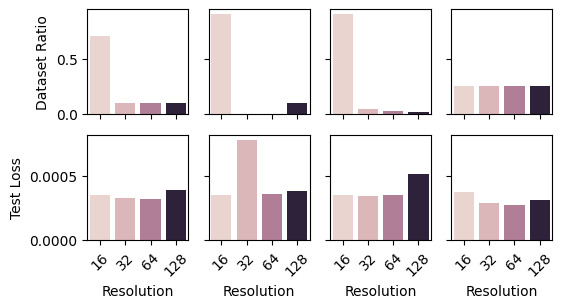

In [23]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey='row', sharex='col', figsize=(6, 3)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, 'mse')
# lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    [0.1, 0.1, 0.1, 0.7],
    [0.1, 0, 0, 0.9],
    [0.02, 0.03, 0.05, 0.9],
    [0.25, 0.25, 0.25, 0.25],
]
for x_idx, res_ratio in enumerate(res_ratios):
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    # if x_idx == 3:
    #    ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
    res_ratio_str = str_from_res(res_ratio)
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
    ckpt_dir = ckpt_dir.replace('.', '')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    ckpt_name = f'{ckpt_pth}/train_stats.csv'

    print(ckpt_name)
    if not os.path.exists(ckpt_name):
        print('does not exist: ', ckpt_dir)
        continue
    df = pd.read_csv(ckpt_name)
    losses = (
        df[df.epoch == 150][
            ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
        ]
        .values.squeeze()
        .tolist()
    )
    sns.barplot(y=res_ratio, x=img_sizes, ax=axes[0, x_idx], hue=img_sizes)
    sns.barplot(y=losses, x=img_sizes, ax=axes[1, x_idx], hue=img_sizes)
    axes[0, x_idx].get_legend().remove()
    axes[1, x_idx].get_legend().remove()
    axes[1, x_idx].tick_params(axis='x', labelrotation=45)

    if x_idx == 0:
        axes[0, x_idx].set_ylabel('Dataset Ratio')
        axes[1, x_idx].set_ylabel('Test Loss')

    axes[1, x_idx].set_xlabel('Resolution')
# plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

DATASET:  incomp_ns_pdebench


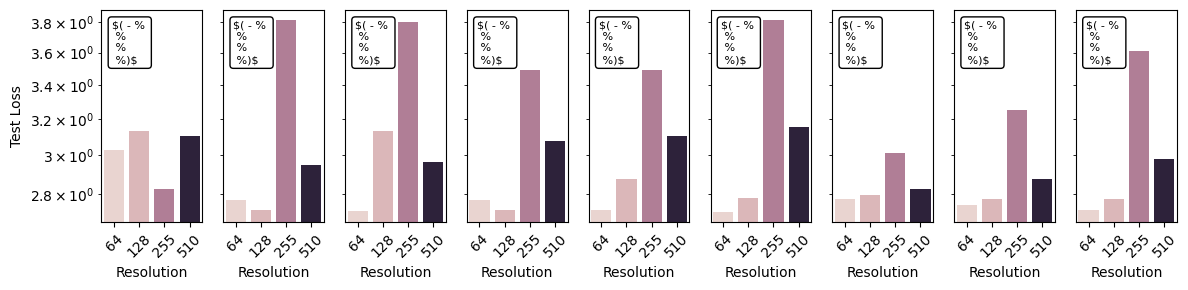

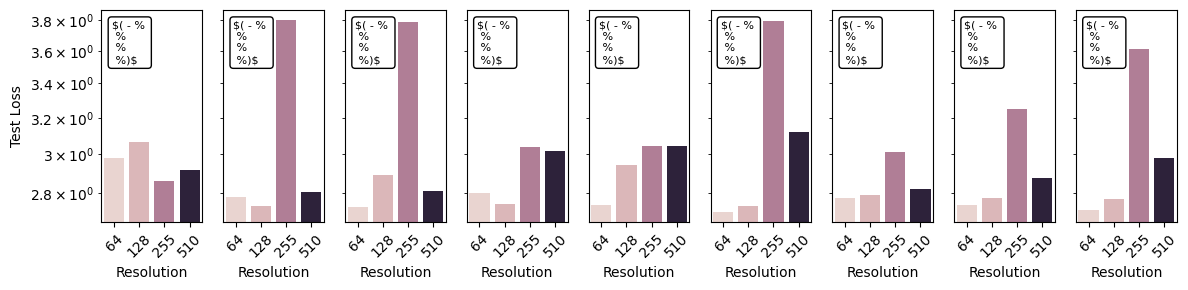

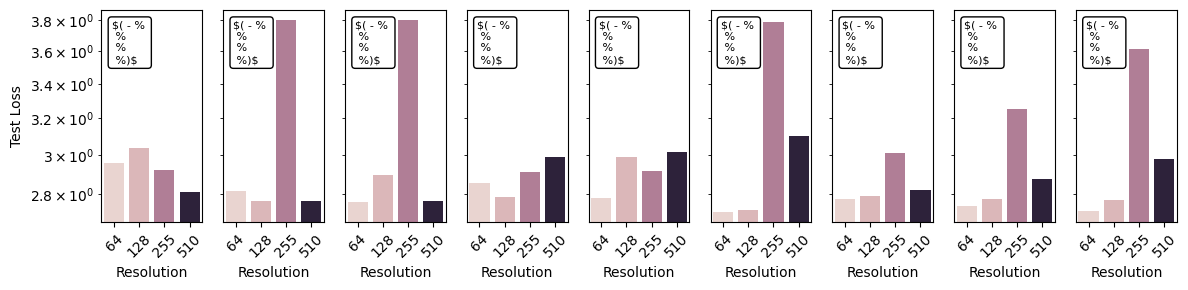

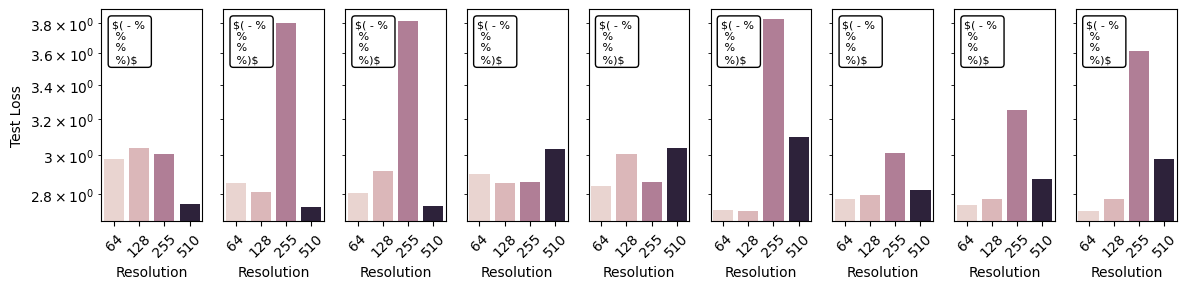

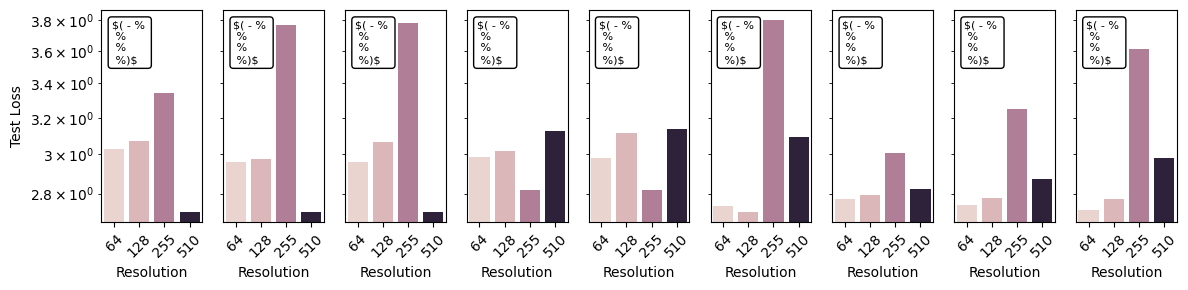

DATASET:  burgers_pdebench


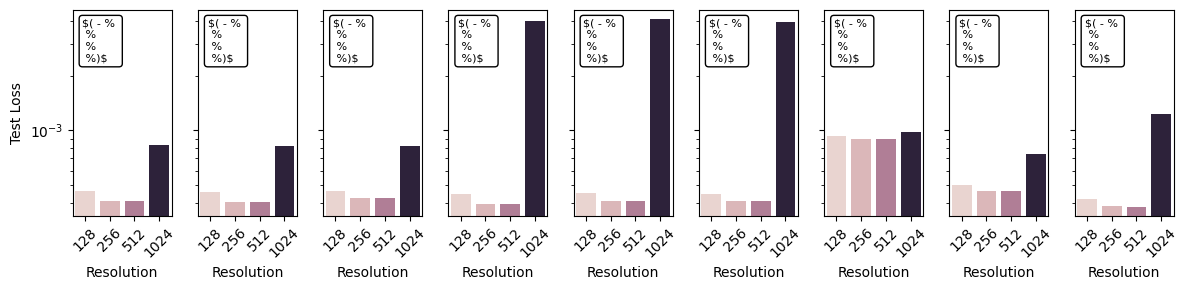

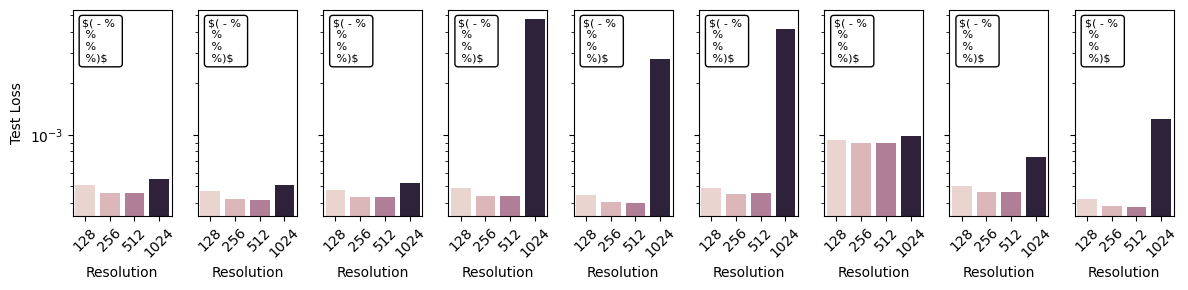

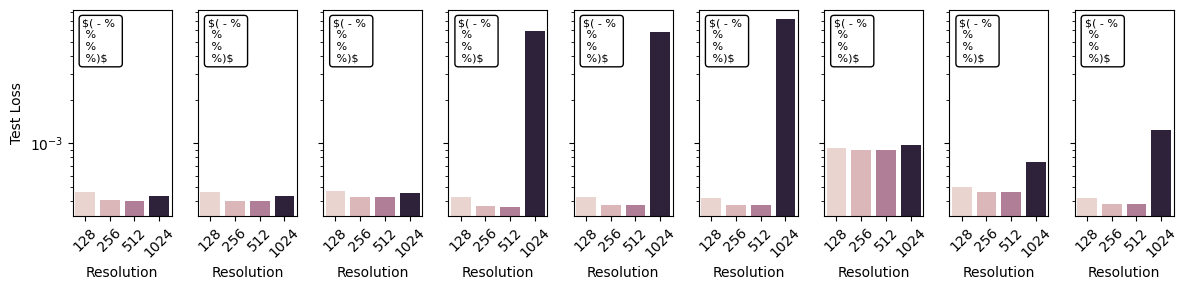

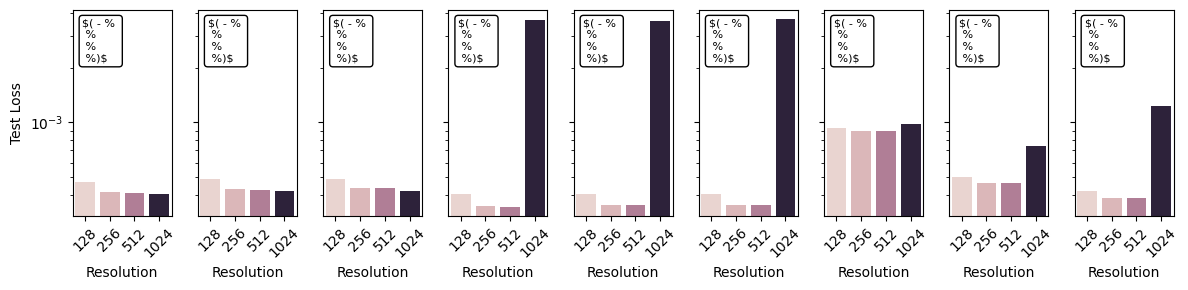

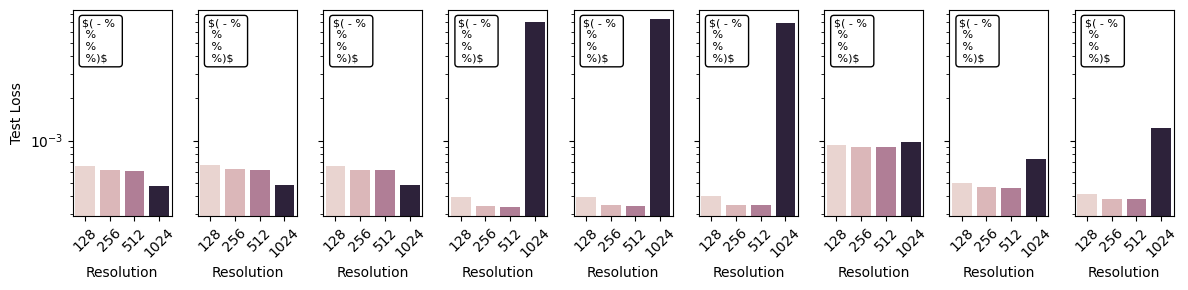

DATASET:  darcy_pdebench


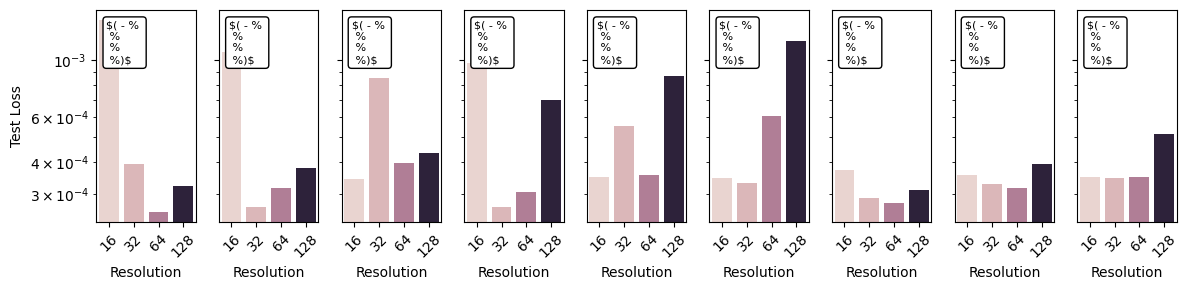

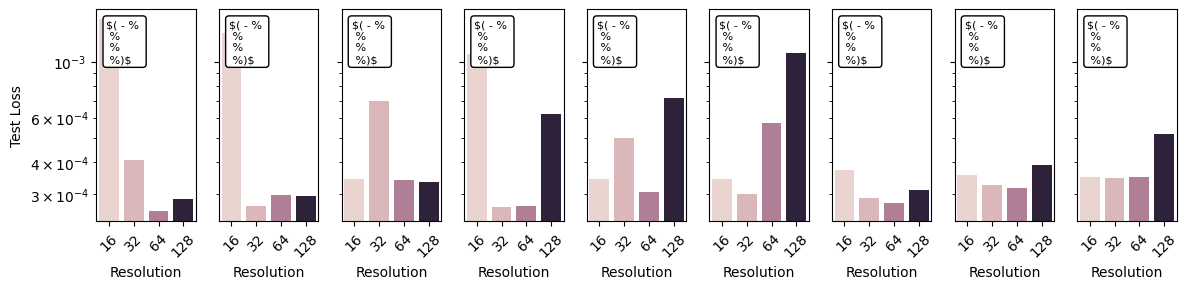

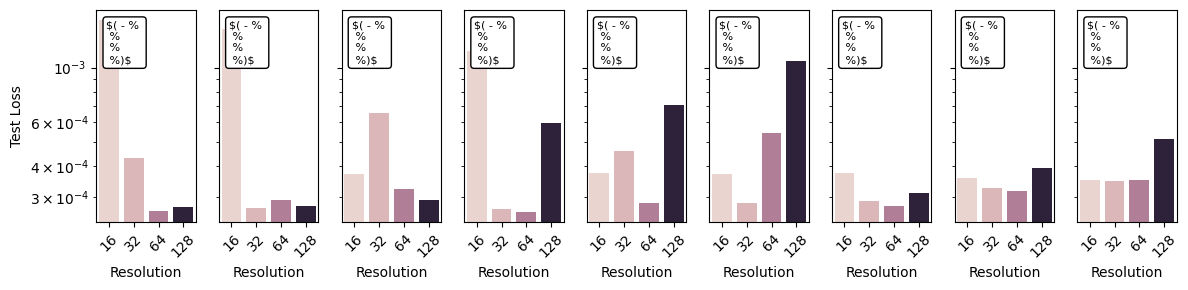

KeyboardInterrupt: 

In [39]:
summary_stats = pd.DataFrame(
    columns=[
        'test_loss',
        'resolution',
        'dataset',
        'ratio',
        'pair',
        'avg_epoch_time',
        'avg_loss_cross_res',
    ]
)

for dataset_name in [
    'incomp_ns_pdebench',
    'burgers_pdebench',
    'darcy_pdebench',
]:  # , 'ns_pdebench'
    loss = 'mse'
    print('DATASET: ', dataset_name)
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    # lr = str(lr).replace('.','')
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        img_size = 128
    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        img_size = 1024
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        img_size = 510
        batch_size = 1
        lr = 1e-05
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        img_size = 512

    max_mode = img_size // 2

    final_ckpts = []

    res_ratios = [
        '[0.25,0.25,0.25,0.25]',
        '[0.1,0.1,0.1,0.7]',
        '[0.02,0.03,0.05,0.9]',
    ]
    for _idx, rat in enumerate([0.05, 0.25, 0.5, 0.75, 0.95]):
        fig, axes = plt.subplots(
            nrows=1, ncols=9, sharey='row', sharex=True, figsize=(12, 3)
        )
        for x_idx, (first_idx, second_idx) in enumerate(
            [
                (0, 1),
                (0, 2),
                (0, 3),
                (1, 2),
                (1, 3),
                (2, 3),
                ('equal', 0),
                ('all', 0),
                ('all_less', 0),
            ]
        ):
            if first_idx == 'equal':
                res_ratio = [0.25, 0.25, 0.25, 0.25]
            elif first_idx == 'all':
                res_ratio = [0.1, 0.1, 0.1, 0.7]
            elif first_idx == 'all_less':
                res_ratio = [0.02, 0.03, 0.05, 0.9]
            else:
                res_ratio = [0, 0, 0, 0]
                res_ratio[first_idx] = rat
                res_ratio[second_idx] = round(1 - rat, 2)
            res_ratio_str = str_from_res(res_ratio)
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
            ckpt_dir = ckpt_dir.replace('.', '')
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            ckpt_file = f'{ckpt_pth}/150_ckpt.pth'

            if not os.path.exists(ckpt_file):
                print('does not exist: ', ckpt_pth)
                continue
            df = pd.read_csv(ckpt_name)
            avg_per_epoch_train_time = df['train_time'].mean()
            losses = (
                df[df.epoch == 150][
                    ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
                ]
                .values.squeeze()
                .tolist()
            )
            avg_loss_cross_res = sum(losses) / len(losses)
            for res, loss_val in enumerate(losses):
                summary_stats.loc[len(summary_stats)] = [
                    loss_val,
                    res,
                    dataset_name,
                    rat,
                    (first_idx, second_idx),
                    avg_per_epoch_train_time,
                    avg_loss_cross_res,
                ]
            # sns.barplot(y=res_ratio, x=img_sizes, ax=axes[0, x_idx], hue=img_sizes)
            sns.barplot(y=losses, x=img_sizes, ax=axes[x_idx], hue=img_sizes)
            # axes[0, x_idx].get_legend().remove()
            # axes[0,x_idx].set_ylim([0,1])
            axes[x_idx].get_legend().remove()
            # axes[0, x_idx].tick_params(axis='x', labelrotation=45)
            axes[x_idx].tick_params(axis='x', labelrotation=45)
            axes[x_idx].set_yscale('log')

            axes[x_idx].annotate(
                '$( - % \n % \n % \n %)$',
                xy=(0.1, 0.75),
                xycoords='axes fraction',
                # textcoords='offset points',
                size=8,
                bbox=dict(
                    boxstyle='round', facecolor='white', edgecolor='black'
                ),
            )

            # sns.barplot(y=[avg_per_epoch_train_time,], x=["",], ax=axes[2,x_idx])
            # axes[2, x_idx].tick_params(axis='x', labelrotation=45)
            # axes[2, x_idx].set_yscale('log')

            if x_idx == 0:
                # axes[0, x_idx].set_ylabel('Dataset Ratio')
                axes[x_idx].set_ylabel('Test Loss')
                # axes[2, x_idx].set_ylabel('Avg Train Time')

            axes[x_idx].set_xlabel('Resolution')

        plt.tight_layout()
        plt.show()

DATASET:  incomp_ns_pdebench


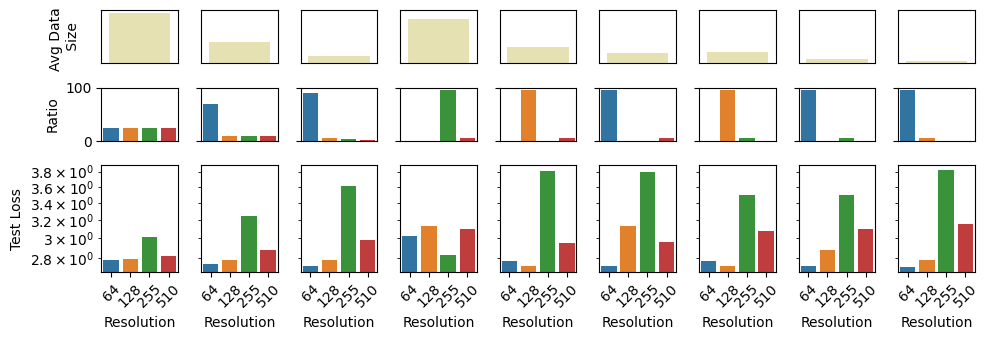

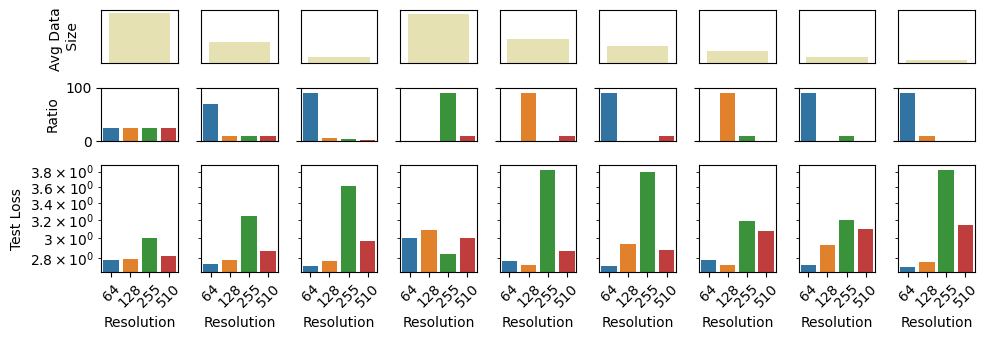

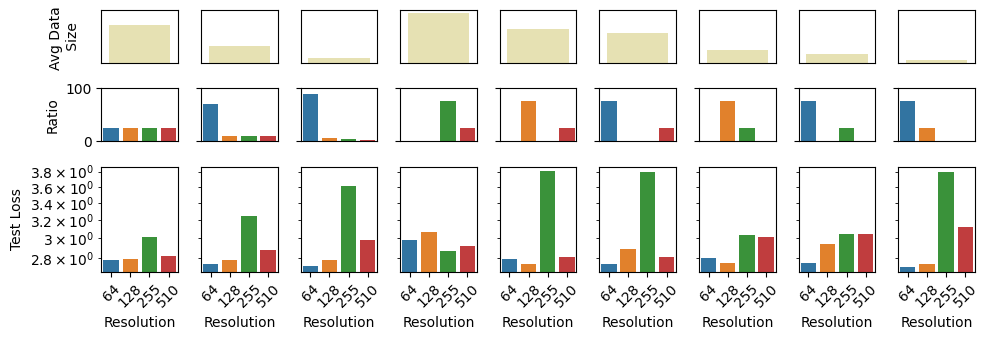

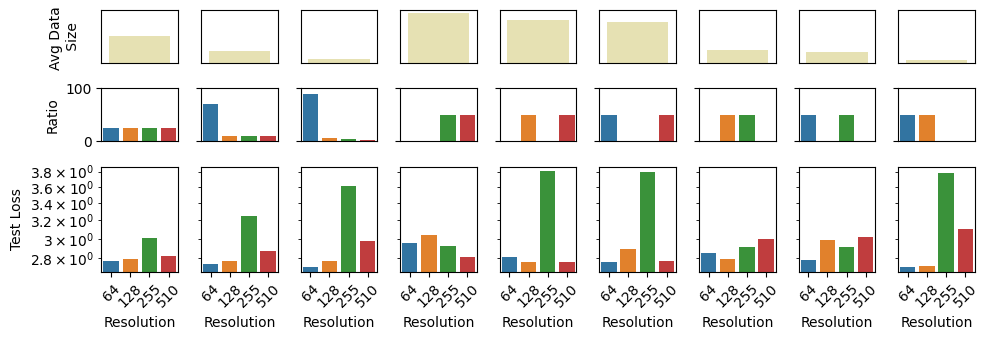

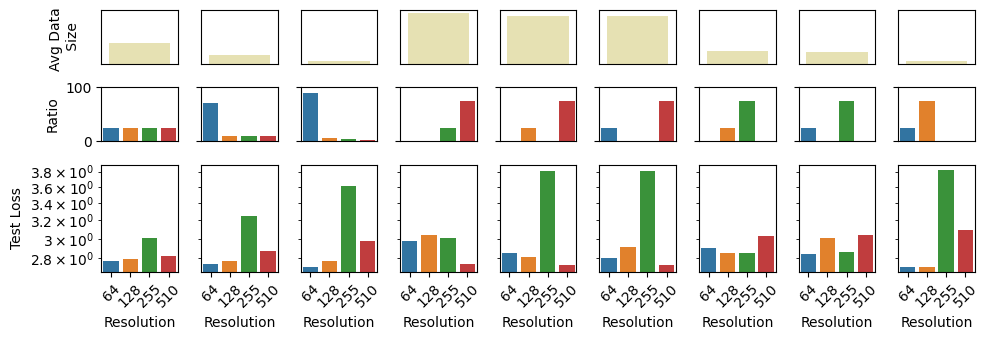

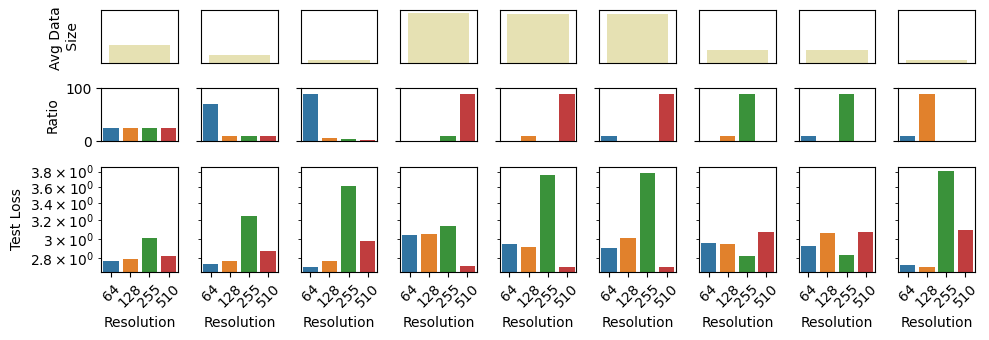

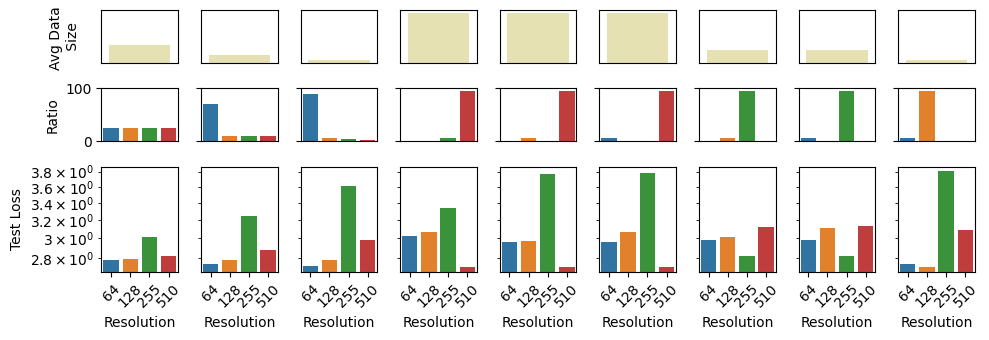

DATASET:  burgers_pdebench


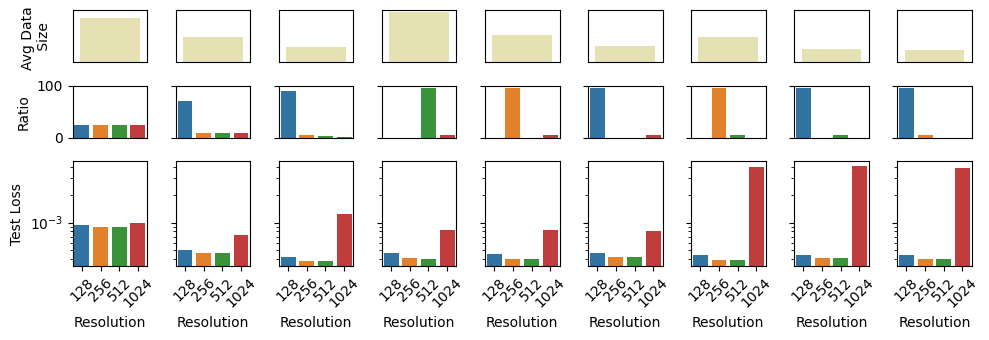

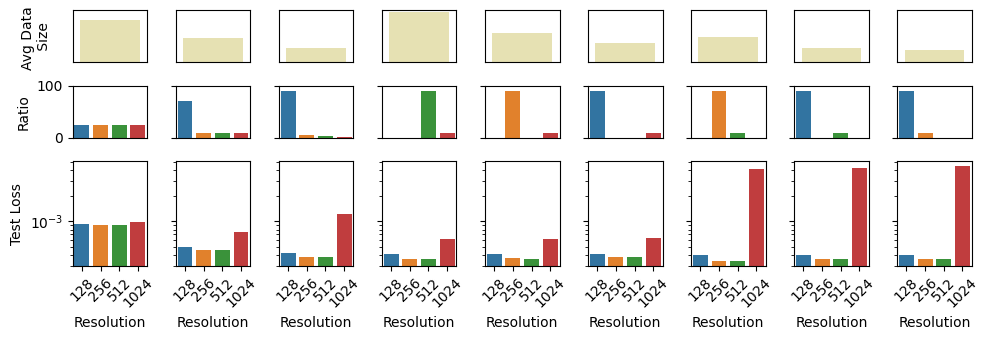

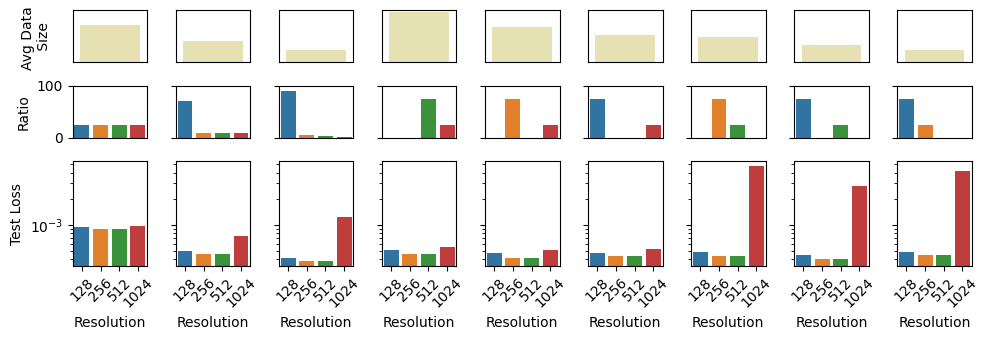

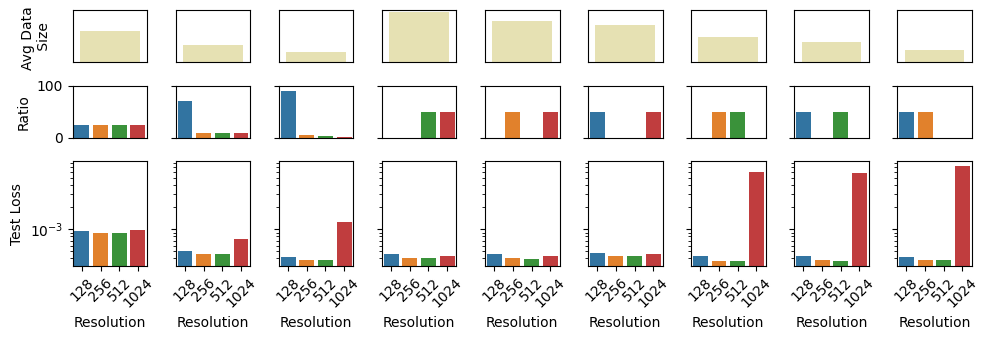

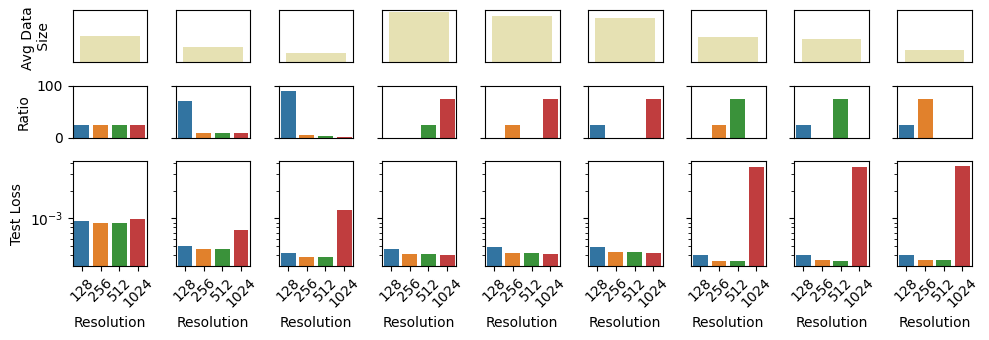

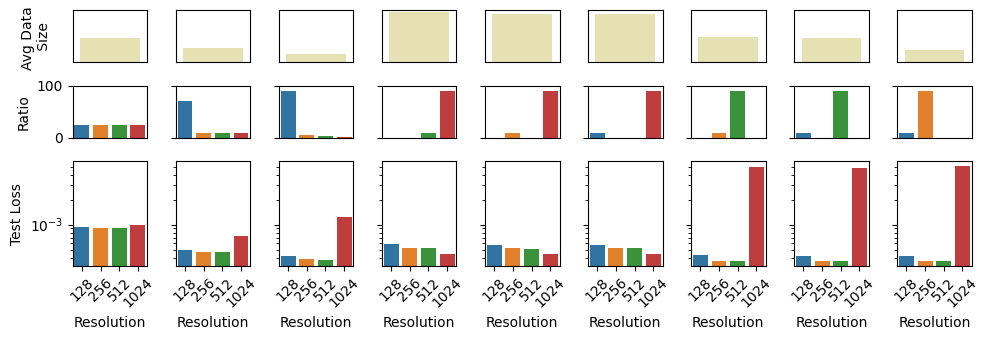

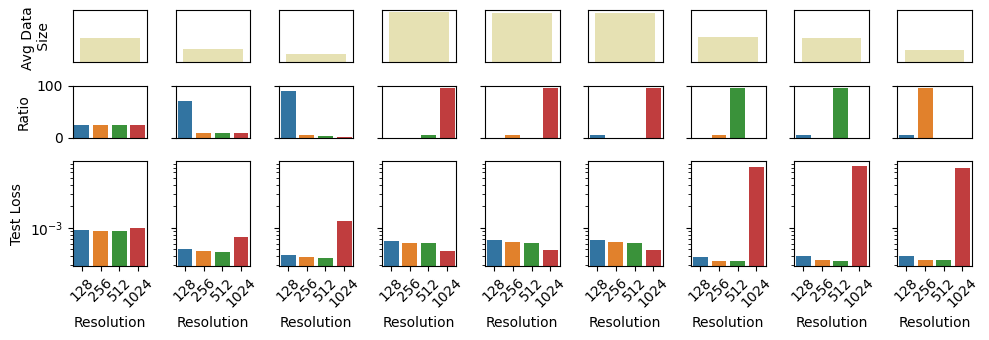

DATASET:  darcy_pdebench


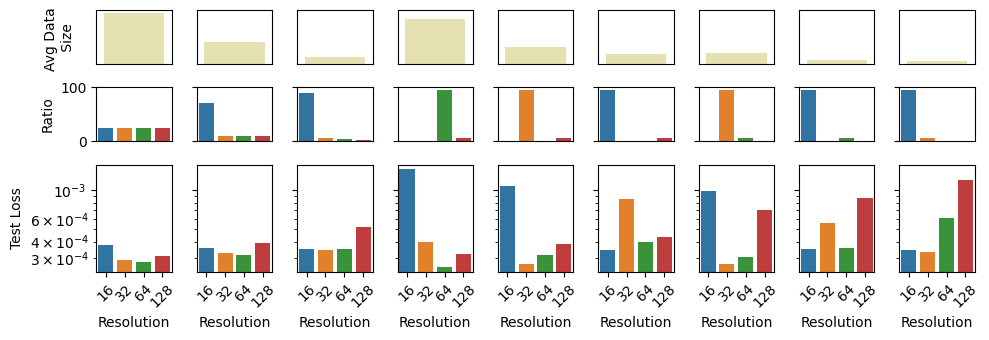

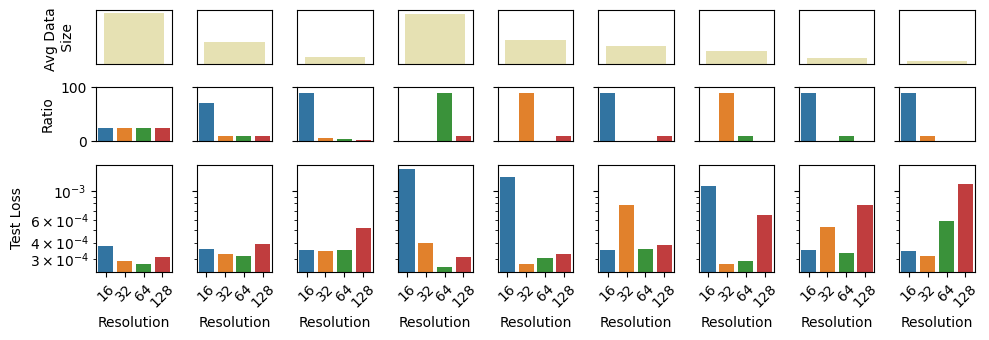

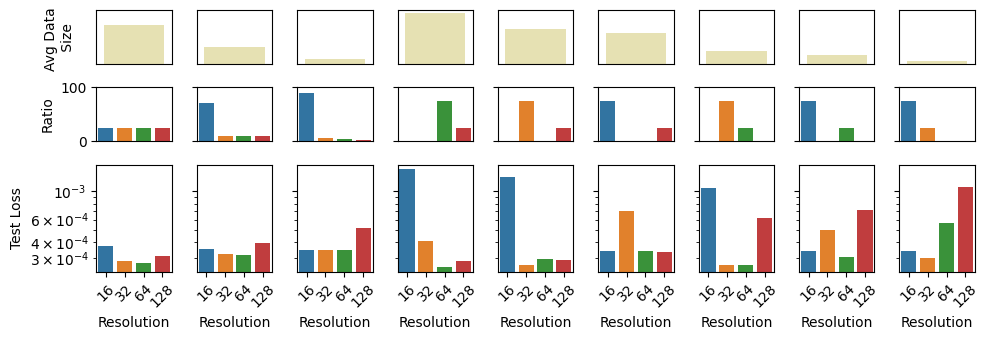

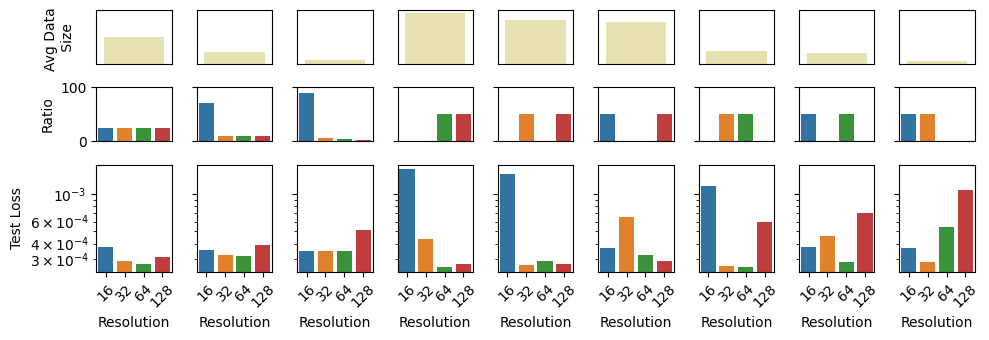

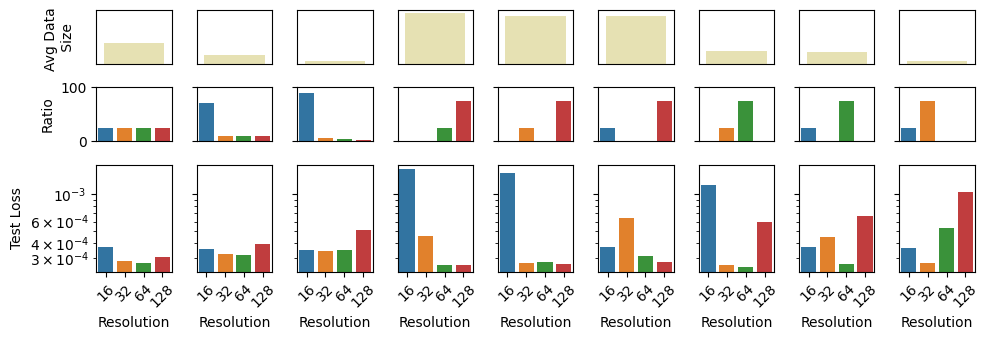

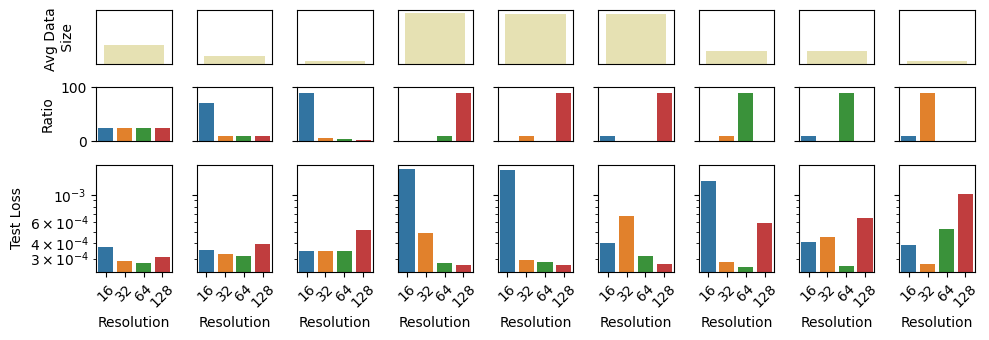

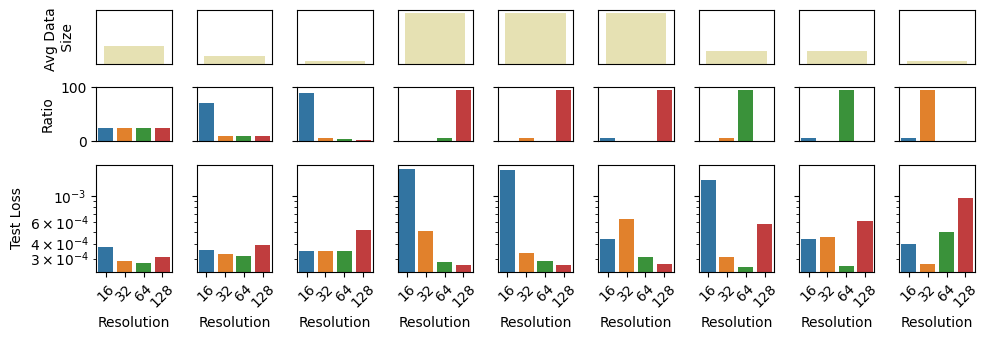

In [152]:
summary_stats = pd.DataFrame(
    columns=[
        'test_loss',
        'resolution',
        'dataset',
        'ratio',
        'pair',
        'avg_epoch_time',
        'avg_loss_cross_res',
        'avg_data_size',
        'train_resolutions',
    ]
)
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']
numbers = {0: '1st', 1: '2nd', 2: '3rd', 3: '4th'}

for dataset_name in [
    'incomp_ns_pdebench',
    'burgers_pdebench',
    'darcy_pdebench',
]:  # , 'ns_pdebench'
    loss = 'mse'
    print('DATASET: ', dataset_name)
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    # lr = str(lr).replace('.','')
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        num_pixels = [i**2 for i in img_sizes]
        img_size = 128
    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        num_pixels = img_sizes
        img_size = 1024
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        num_pixels = [i**2 for i in img_sizes]
        img_size = 510
        batch_size = 1
        lr = 1e-05
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        img_size = 512

    max_mode = img_size // 2

    final_ckpts = []

    res_ratios = [
        '[0.25,0.25,0.25,0.25]',
        '[0.1,0.1,0.1,0.7]',
        '[0.02,0.03,0.05,0.9]',
    ]
    for _idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
        fig, axes = plt.subplots(
            nrows=3,
            ncols=9,
            sharey='row',
            sharex=False,
            figsize=(10, 3.5),
            gridspec_kw={'height_ratios': [1, 1, 2]},
        )
        for x_idx, (first_idx, second_idx) in enumerate(
            [
                ('equal', 0),
                ('all', 0),
                ('all_less', 0),
                (0, 1),
                (0, 2),
                (0, 3),
                (1, 2),
                (1, 3),
                (2, 3),
            ]
        ):
            pair = 'All Res.'
            if first_idx == 'equal':
                res_ratio = [0.25, 0.25, 0.25, 0.25]
            elif first_idx == 'all':
                res_ratio = [0.1, 0.1, 0.1, 0.7]
            elif first_idx == 'all_less':
                res_ratio = [0.02, 0.03, 0.05, 0.9]
            else:
                res_ratio = [0, 0, 0, 0]
                res_ratio[first_idx] = rat
                res_ratio[second_idx] = round(1 - rat, 2)
                pair = f'{numbers[first_idx]}+{numbers[second_idx]}'  # [numbers[first_idx], numbers[second_idx]]
            res_ratio_str = str_from_res(res_ratio)
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
            ckpt_dir = ckpt_dir.replace('.', '')
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            ckpt_file = f'{ckpt_pth}/150_ckpt.pth'

            if not os.path.exists(ckpt_file):
                print('does not exist: ', ckpt_pth)
                continue
            df = pd.read_csv(ckpt_name)
            num_pixes = sum([x * y for x, y in zip(res_ratio, num_pixels)])
            avg_per_epoch_train_time = df['train_time'].mean()
            avg_data_size = sum([x * y for x, y in zip(res_ratio, num_pixels)])
            losses = (
                df[df.epoch == 150][
                    ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
                ]
                .values.squeeze()
                .tolist()
            )
            avg_loss_cross_res = sum(losses) / len(losses)
            for res, loss_val in enumerate(losses):
                summary_stats.loc[len(summary_stats)] = [
                    loss_val,
                    res,
                    dataset_name,
                    rat,
                    (first_idx, second_idx),
                    avg_per_epoch_train_time,
                    avg_loss_cross_res,
                    avg_data_size,
                    str(pair),
                ]
            scaled_ratios = [i * 100 for i in res_ratio]
            sns.barplot(
                y=scaled_ratios,
                x=img_sizes,
                ax=axes[1, x_idx],
                hue=img_sizes,
                palette='tab10',
            )
            axes[1, x_idx].get_xaxis().set_visible(False)
            axes[1, x_idx].get_legend().remove()
            # axes[1,x_idx].bar(img_sizes, scaled_ratios, color=bar_colors)
            sns.barplot(
                y=losses,
                x=img_sizes,
                ax=axes[2, x_idx],
                hue=img_sizes,
                palette='tab10',
            )

            axes[1, x_idx].set_ylim([0, 100])
            axes[2, x_idx].get_legend().remove()
            axes[1, x_idx].tick_params(axis='x', labelrotation=45)
            axes[2, x_idx].tick_params(axis='x', labelrotation=45)
            axes[2, x_idx].set_yscale('log')

            # sns.barplot(y=[avg_per_epoch_train_time,], x=["",], ax=axes[0, x_idx])
            sns.barplot(
                y=[avg_data_size],
                x=[''],
                ax=axes[0, x_idx],
                hue=[''],
                palette={'': 'palegoldenrod'},
            )  # {'': 'palegoldenrod'}
            axes[0, x_idx].get_xaxis().set_visible(False)
            axes[0, x_idx].set_yticks([])
            # axes[0, x_idx].tick_params(axis='x', labelrotation=45)
            # axes[0, x_idx].set_yscale('log')

            if x_idx == 0:
                axes[1, x_idx].set_ylabel('Ratio')
                axes[2, x_idx].set_ylabel('Test Loss')
                axes[0, x_idx].set_ylabel('Avg Data \n Size \n')
                # axes[0, x_idx].set_ylabel('Avg Train \n Time')

            axes[2, x_idx].set_xlabel('Resolution')

        plt.tight_layout()
        plt.show()
        fig.savefig(
            f'{FIG_DIR}/{dataset_name}_{rat}_{first_idx}_{second_idx}_multi_res.pdf',
            dpi=300,
            bbox_inches='tight',
        )

DATASET:  incomp_ns_pdebench


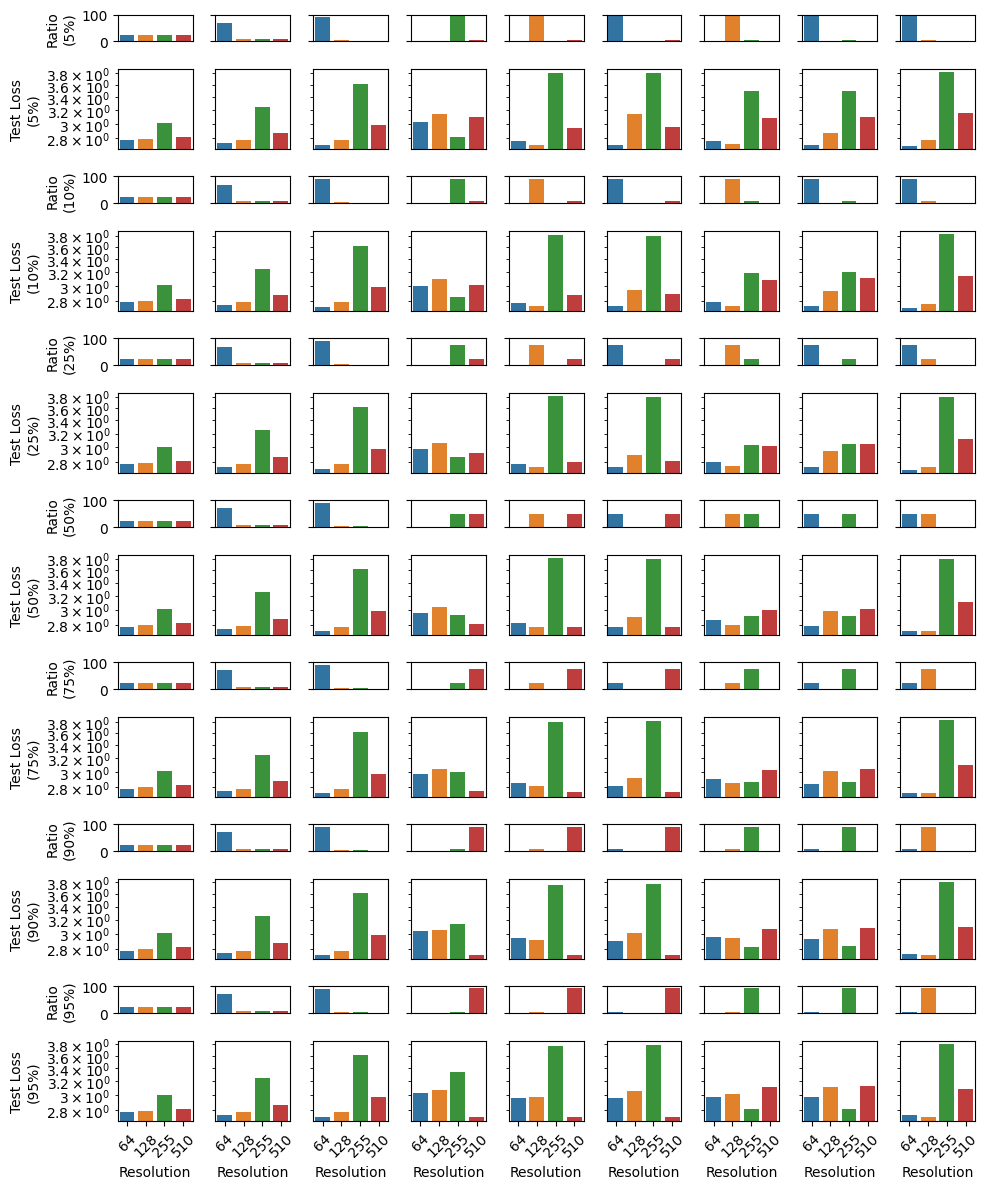

DATASET:  burgers_pdebench


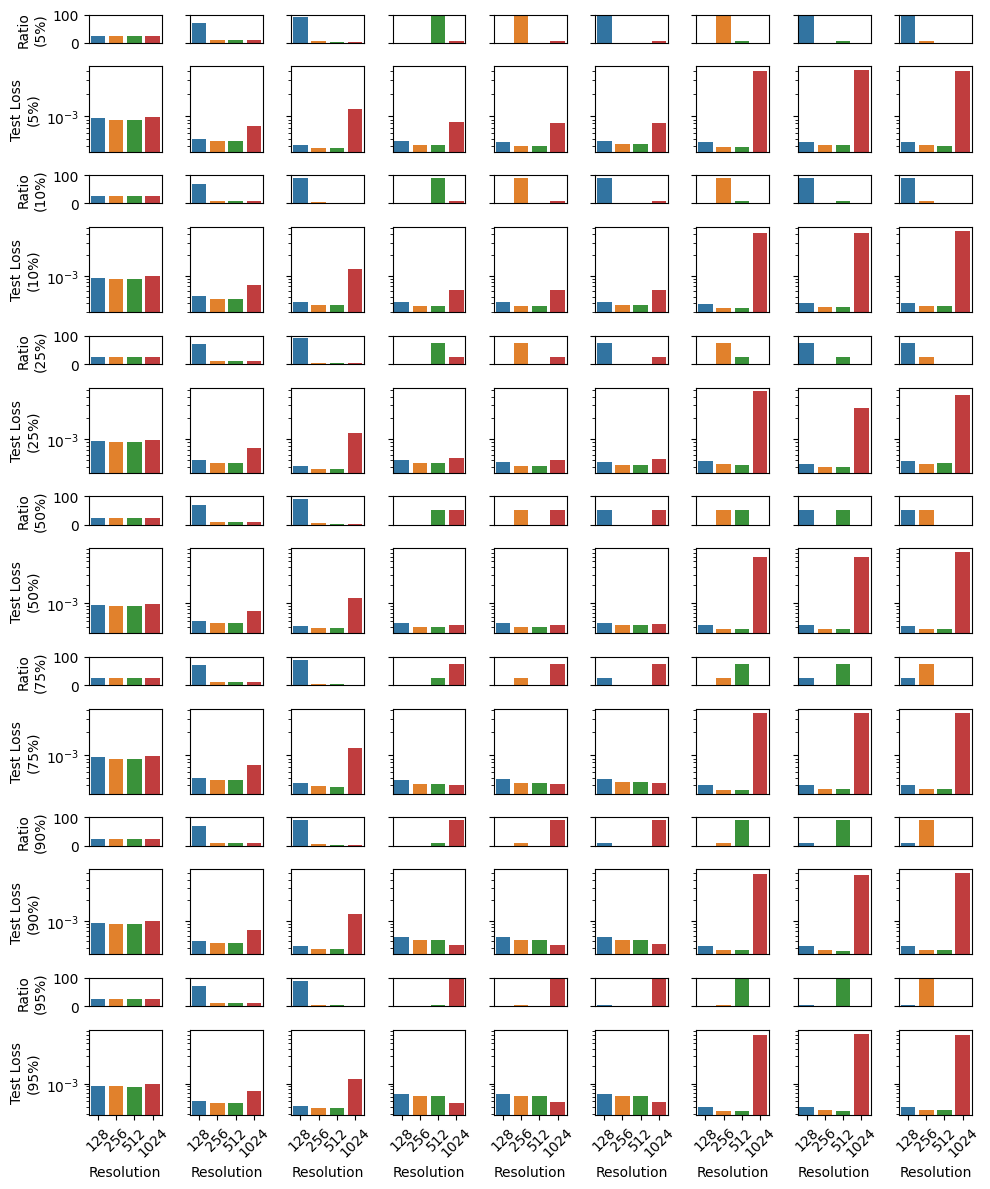

DATASET:  darcy_pdebench


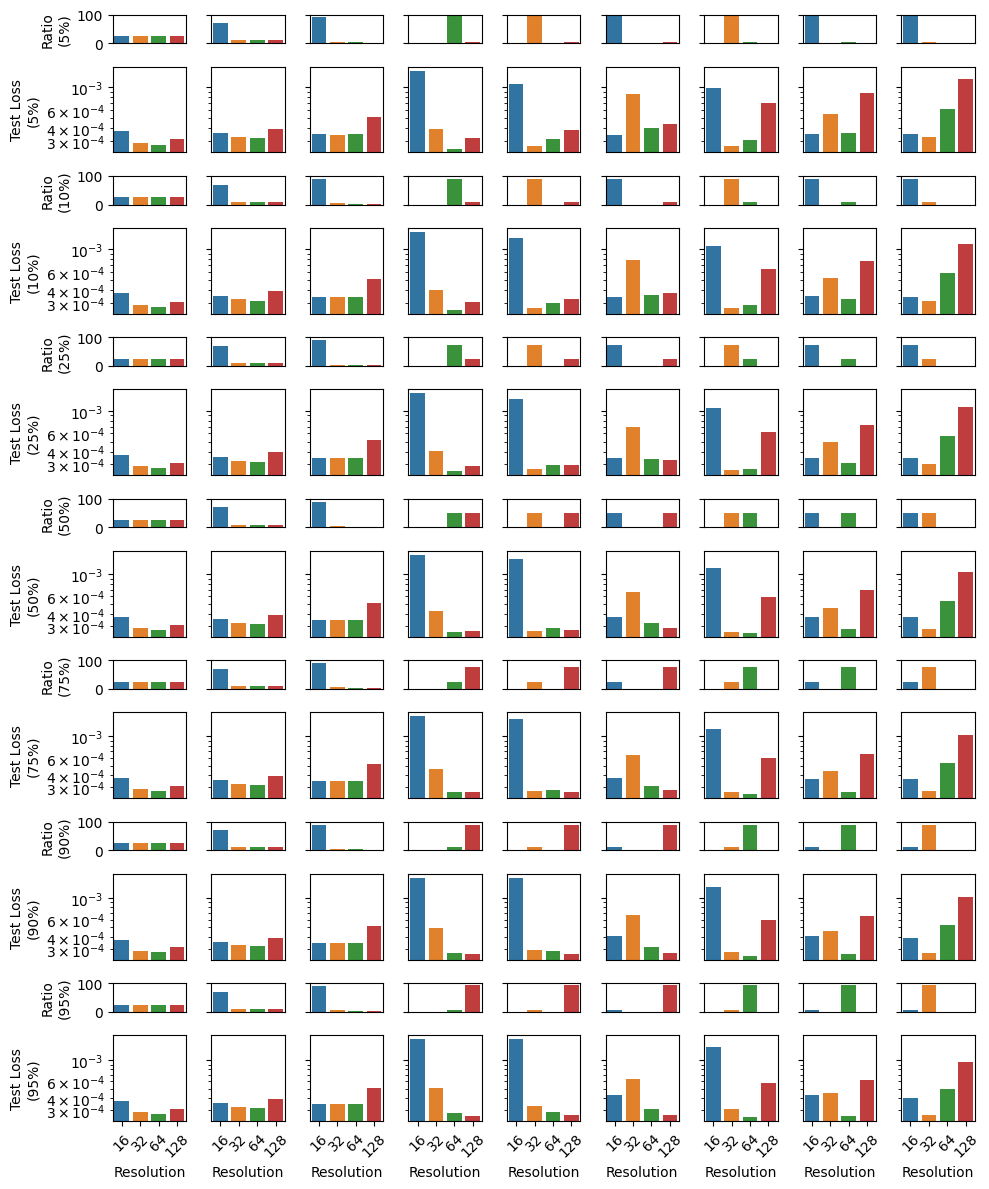

In [27]:
summary_stats = pd.DataFrame(
    columns=[
        'test_loss',
        'resolution',
        'dataset',
        'ratio',
        'pair',
        'avg_epoch_time',
        'avg_loss_cross_res',
        'avg_data_size',
    ]
)
bar_colors = ['tab:red', 'tab:blue', 'tab:red', 'tab:orange']

for dataset_name in [
    'incomp_ns_pdebench',
    'burgers_pdebench',
    'darcy_pdebench',
]:  # , 'ns_pdebench'
    loss = 'mse'
    print('DATASET: ', dataset_name)
    (
        model_name,
        in_channels,
        out_channels,
        initial_steps,
        loss,
        batch_size,
        lr,
        wd,
        pinn_loss_weight,
    ) = get_dataset_info(dataset_name, 'mse')
    # lr = str(lr).replace('.','')
    ckpt_path = (
        '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ckpts'
    )
    if dataset_name == 'darcy_pdebench':
        img_sizes = [128, 64, 32, 16]
        num_pixels = [i**2 for i in img_sizes]
        img_size = 128
    if dataset_name == 'burgers_pdebench':
        img_sizes = [1024, 512, 256, 128]
        num_pixels = img_sizes
        img_size = 1024
    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [510, 255, 128, 64]
        num_pixels = [i**2 for i in img_sizes]
        img_size = 510
        batch_size = 1
        lr = 1e-05
        ckpt_path = '/pscratch/sd/m/mansisak/operator_aliasing/operator_aliasing/ns_ckpts'
    if dataset_name == 'ns_pdebench':
        img_sizes = [512, 256, 128, 64]
        img_size = 512

    max_mode = img_size // 2

    final_ckpts = []

    res_ratios = [
        '[0.25,0.25,0.25,0.25]',
        '[0.1,0.1,0.1,0.7]',
        '[0.02,0.03,0.05,0.9]',
    ]
    fig, axes = plt.subplots(
        nrows=14,
        ncols=9,
        sharey='row',
        sharex=False,
        figsize=(10, 12),
        gridspec_kw={
            'height_ratios': [
                0.75,
                2.25,
                0.75,
                2.25,
                0.75,
                2.25,
                0.75,
                2.25,
                0.75,
                2.25,
                0.75,
                2.25,
                0.75,
                2.25,
            ]
        },  # 1, 2, 1, 2,1, 2,1, 2,1, 2,1, 2,1, 2,]
    )
    for _idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
        for x_idx, (first_idx, second_idx) in enumerate(
            [
                ('equal', 0),
                ('all', 0),
                ('all_less', 0),
                (0, 1),
                (0, 2),
                (0, 3),
                (1, 2),
                (1, 3),
                (2, 3),
            ]
        ):
            if first_idx == 'equal':
                res_ratio = [0.25, 0.25, 0.25, 0.25]
            elif first_idx == 'all':
                res_ratio = [0.1, 0.1, 0.1, 0.7]
            elif first_idx == 'all_less':
                res_ratio = [0.02, 0.03, 0.05, 0.9]
            else:
                res_ratio = [0, 0, 0, 0]
                res_ratio[first_idx] = rat
                res_ratio[second_idx] = round(1 - rat, 2)
            res_ratio_str = str_from_res(res_ratio)
            ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio_str}'
            ckpt_dir = ckpt_dir.replace('.', '')
            ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
            ckpt_name = f'{ckpt_pth}/train_stats.csv'
            ckpt_file = f'{ckpt_pth}/150_ckpt.pth'

            if not os.path.exists(ckpt_file):
                print('does not exist: ', ckpt_pth)
                continue
            df = pd.read_csv(ckpt_name)
            num_pixes = sum([x * y for x, y in zip(res_ratio, num_pixels)])
            avg_per_epoch_train_time = df['train_time'].mean()
            avg_data_size = sum([x * y for x, y in zip(res_ratio, num_pixels)])
            losses = (
                df[df.epoch == 150][
                    ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
                ]
                .values.squeeze()
                .tolist()
            )
            avg_loss_cross_res = sum(losses) / len(losses)
            for res, loss_val in enumerate(losses):
                summary_stats.loc[len(summary_stats)] = [
                    loss_val,
                    res,
                    dataset_name,
                    rat,
                    (first_idx, second_idx),
                    avg_per_epoch_train_time,
                    avg_loss_cross_res,
                    avg_data_size,
                ]
            scaled_ratios = [i * 100 for i in res_ratio]
            sns.barplot(
                y=scaled_ratios,
                x=img_sizes,
                ax=axes[_idx * 2 + 0, x_idx],
                hue=img_sizes,
                palette='tab10',
            )
            axes[_idx * 2 + 0, x_idx].get_xaxis().set_visible(False)
            if _idx != 6:
                axes[_idx * 2 + 1, x_idx].get_xaxis().set_visible(False)
            axes[_idx * 2 + 0, x_idx].get_legend().remove()
            # axes[1,x_idx].bar(img_sizes, scaled_ratios, color=bar_colors)
            sns.barplot(
                y=losses,
                x=img_sizes,
                ax=axes[_idx * 2 + 1, x_idx],
                hue=img_sizes,
                palette='tab10',
            )
            # print(_idx*2)
            axes[_idx * 2 + 0, x_idx].set_ylim([0, 100])
            axes[_idx * 2 + 1, x_idx].get_legend().remove()
            axes[_idx * 2 + 0, x_idx].tick_params(axis='x', labelrotation=45)
            axes[_idx * 2 + 1, x_idx].tick_params(axis='x', labelrotation=45)
            axes[_idx * 2 + 1, x_idx].set_yscale('log')

            # sns.barplot(y=[avg_per_epoch_train_time,], x=["",], ax=axes[0, x_idx])
            # sns.barplot(y=[avg_data_size,], x=["",], ax=axes[0, x_idx], hue=["",], palette = {'': 'palegoldenrod'})
            # axes[0,x_idx].get_xaxis().set_visible(False)
            # axes[0,x_idx].set_yticks([])
            # axes[0, x_idx].tick_params(axis='x', labelrotation=45)
            # axes[0, x_idx].set_yscale('log')

            if x_idx == 0:
                axes[_idx * 2 + 0, x_idx].set_ylabel(
                    f'Ratio\n({int(rat * 100)}%)'
                )
                axes[_idx * 2 + 1, x_idx].set_ylabel(
                    f'Test Loss\n({int(rat * 100)}%)'
                )
                # axes[0, x_idx].set_ylabel('Avg Data \n Size \n')
                # axes[0, x_idx].set_ylabel('Avg Train \n Time')

            axes[_idx * 2 + 1, x_idx].set_xlabel('Resolution')

    plt.tight_layout()
    plt.show()
    fig.savefig(
        f'{FIG_DIR}/{dataset_name}_multi_res.pdf',
        dpi=300,
        bbox_inches='tight',
    )

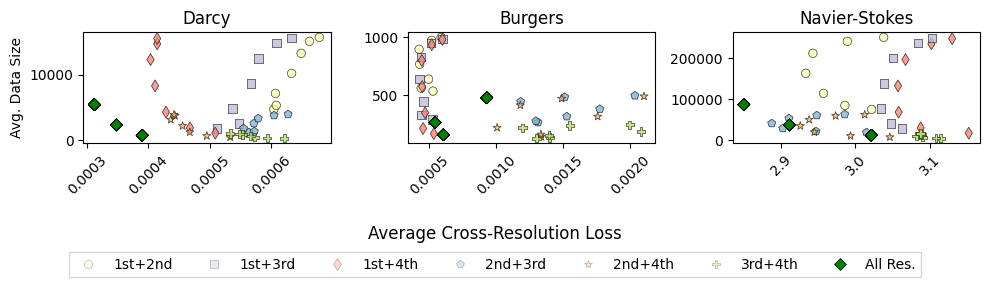

In [155]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=False,
    sharex=False,
    figsize=(10, 2.5),
)

palette = {
    method: color if method != 'All Res.' else 'green'
    for method, color in zip(
        summary_stats.train_resolutions.unique(), sns.color_palette('Set3', 12)
    )
}
for x_idx, dataset_name in enumerate(
    ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench']
):
    if 'burgers' in dataset_name:
        title = 'Burgers'
    if 'darcy' in dataset_name:
        title = 'Darcy'
    if 'ns' in dataset_name:
        title = 'Navier-Stokes'
    sns.scatterplot(
        data=summary_stats[
            (summary_stats.dataset == dataset_name)
            & (summary_stats.train_resolutions != 'All Res.')
        ],
        y='avg_data_size',
        x='avg_loss_cross_res',
        # hue="pair",
        hue='train_resolutions',
        ax=axes[x_idx],
        palette=palette,
        style='train_resolutions',
        markers=['o', 's', 'd', 'p', '*', 'P'],
        edgecolor='Black',
        alpha=0.3,
    )
    sns.scatterplot(
        data=summary_stats[
            (summary_stats.dataset == dataset_name)
            & (summary_stats.train_resolutions == 'All Res.')
        ],
        y='avg_data_size',
        x='avg_loss_cross_res',
        # hue="pair",
        hue='train_resolutions',
        ax=axes[x_idx],
        palette=palette,
        style='train_resolutions',
        markers=['D'],
        edgecolor='Black',
        alpha=1,
    )
    axes[x_idx].set_title(title)
    # axes[x_idx].set_xlabel("Average Cross-Resolution Loss")
    axes[x_idx].set_ylabel('')
    axes[x_idx].set_xlabel('')
    if x_idx == 0:
        axes[x_idx].set_ylabel('Avg. Data Size')
    # axes[x_idx].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
    #      fancybox=False, shadow=False, ncol=2)
    handles, labels = axes[x_idx].get_legend_handles_labels()
    axes[x_idx].get_legend().remove()

    axes[x_idx].tick_params(axis='x', labelrotation=45)
    # axes[x_idx].set_xscale("log")
# plt.title(dataset_name)
fig.supxlabel('Average Cross-Resolution Loss')
fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.0),
    fancybox=False,
    shadow=False,
    ncol=7,
)
plt.tight_layout()
plt.show()
fig.savefig(
    f'{FIG_DIR}/multi_res_scatter.pdf',
    dpi=300,
    bbox_inches='tight',
)

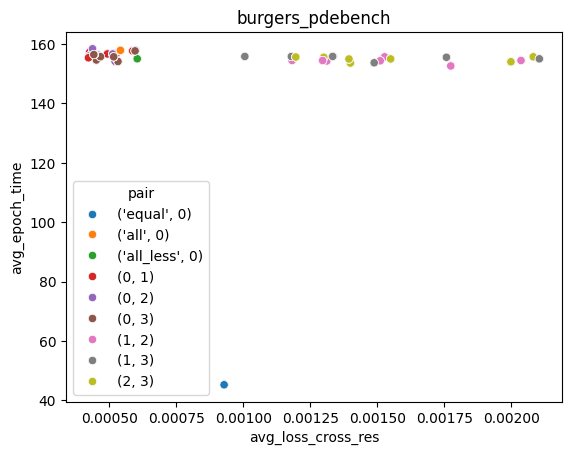

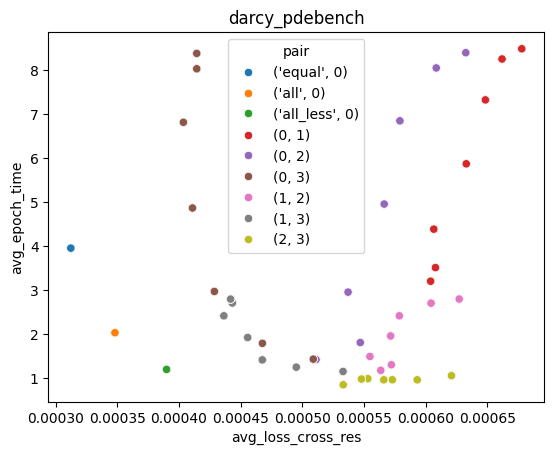

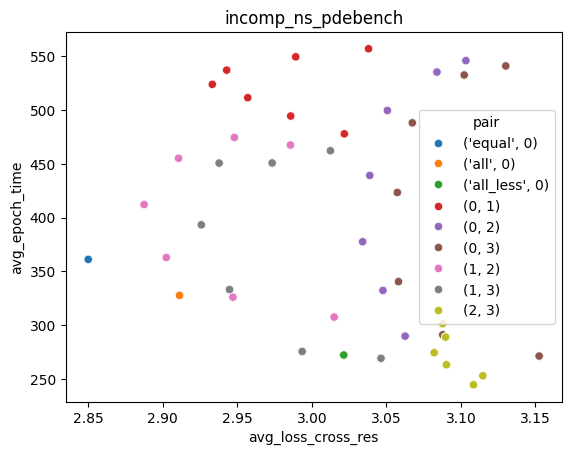

In [71]:
for dataset_name in [
    'burgers_pdebench',
    'darcy_pdebench',
    'incomp_ns_pdebench',
]:
    sns.scatterplot(
        data=summary_stats[summary_stats.dataset == dataset_name],
        y='avg_epoch_time',
        x='avg_loss_cross_res',
        hue='pair',
    )
    plt.title(dataset_name)
    plt.show()

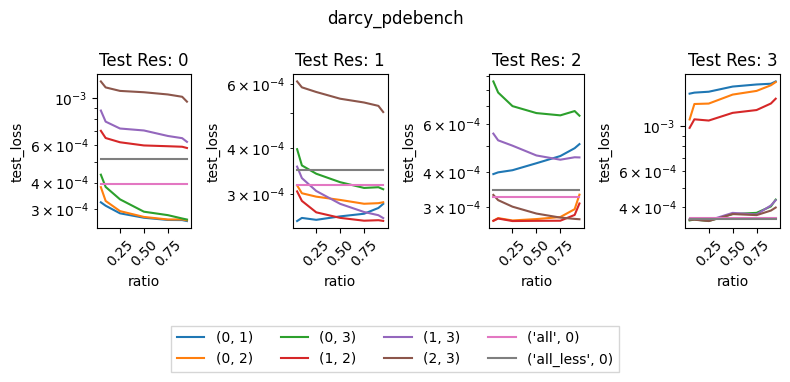

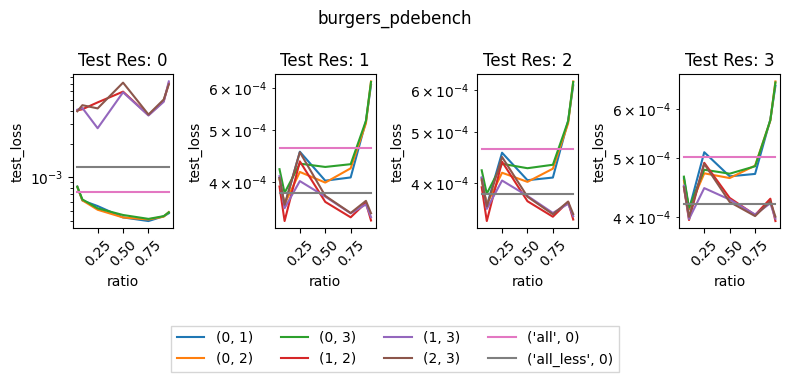

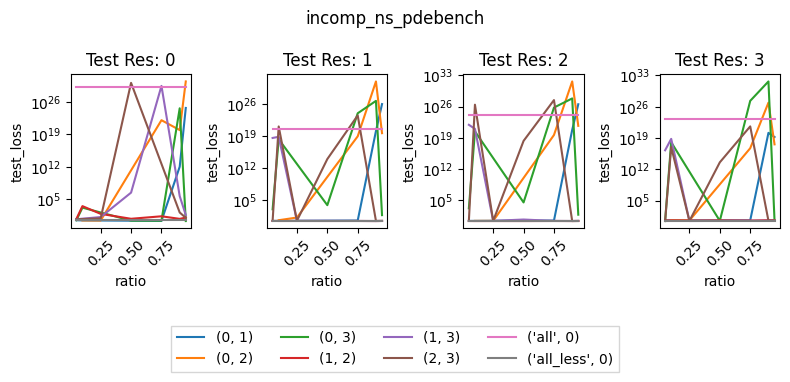

In [55]:
for dataset in ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench']:
    fig, axes = plt.subplots(
        nrows=1, ncols=4, sharey=False, sharex='col', figsize=(8, 3)
    )
    for res in range(4):
        for pair in summary_stats.pair.unique():
            sns.lineplot(
                x='ratio',
                y='test_loss',
                data=summary_stats[
                    (summary_stats.resolution == res)
                    & (summary_stats.pair == pair)
                    & (summary_stats.dataset == dataset)
                ],
                ax=axes[res],
                label=pair,
            )
            axes[res].set_yscale('log')
            axes[res].set_title(f'Test Res: {res}')
            handles, labels = axes[res].get_legend_handles_labels()
            axes[res].get_legend().remove()
            axes[res].tick_params(axis='x', labelrotation=45)
    fig.legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        fancybox=False,
        shadow=False,
        ncol=4,
    )
    plt.suptitle(dataset)
    plt.tight_layout()
    plt.show()

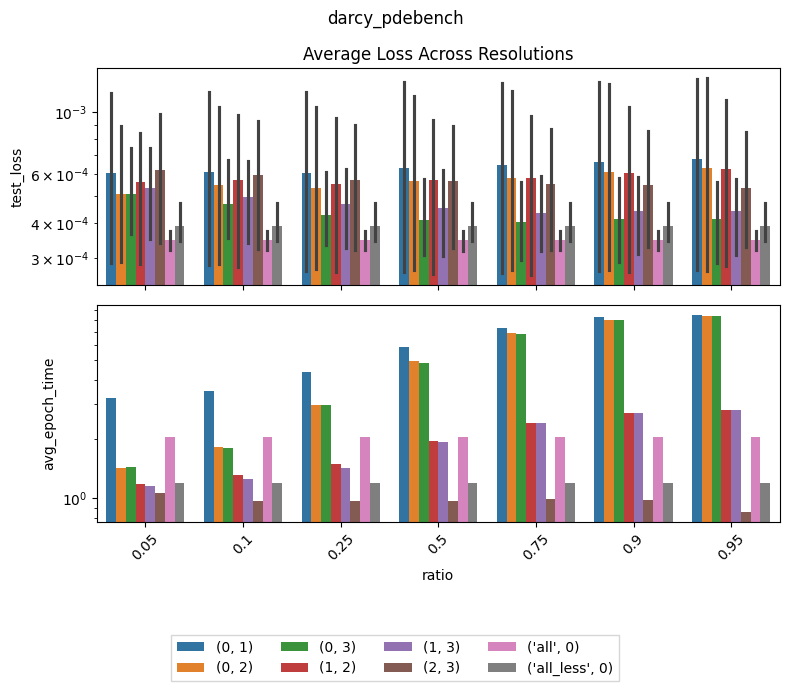

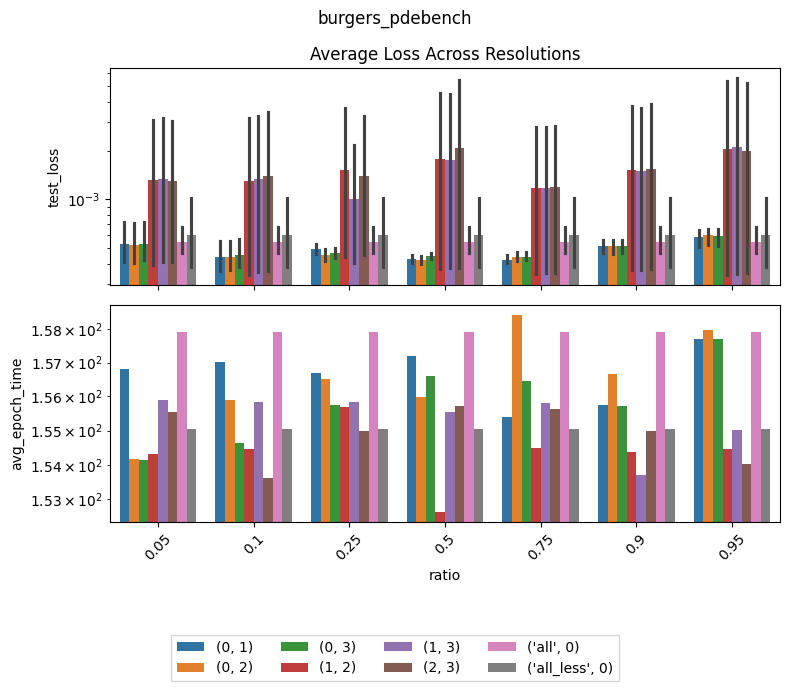

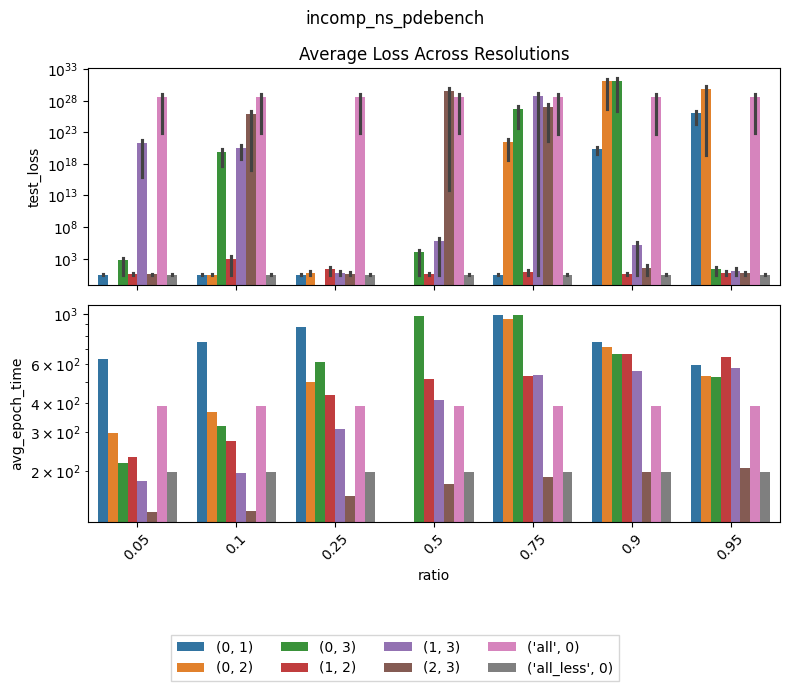

In [66]:
for dataset in ['darcy_pdebench', 'burgers_pdebench', 'incomp_ns_pdebench']:
    fig, axes = plt.subplots(
        nrows=2, ncols=1, sharey=False, sharex='col', figsize=(8, 6)
    )
    # for res in range(4):
    # for idx, pair in enumerate(summary_stats.pair.unique()):
    sns.barplot(
        x='ratio',
        y='test_loss',
        data=summary_stats[(summary_stats.dataset == dataset)],
        ax=axes[0],
        hue='pair',
    )
    axes[0].set_yscale('log')

    sns.barplot(
        x='ratio',
        y='avg_epoch_time',
        data=summary_stats[(summary_stats.dataset == dataset)],
        ax=axes[1],
        hue='pair',
    )
    axes[1].set_yscale('log')

    axes[0].set_title('Average Loss Across Resolutions')
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].get_legend().remove()
    axes[1].get_legend().remove()
    axes[1].tick_params(axis='x', labelrotation=45)
    fig.legend(
        handles=handles,
        labels=labels,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.05),
        fancybox=False,
        shadow=False,
        ncol=4,
    )
    plt.suptitle(dataset)
    plt.tight_layout()
    plt.show()

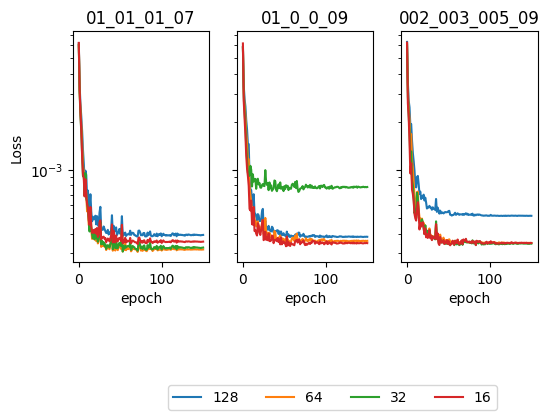

In [17]:
fig, axes = plt.subplots(
    nrows=1, ncols=3, sharey=True, sharex='col', figsize=(6, 3)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, 'mse')
# lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    [0.1, 0.1, 0.1, 0.7],
    [0.1, 0, 0, 0.9],
    [0.02, 0.03, 0.05, 0.9],
]
for x_idx, res_ratio in enumerate(res_ratios):
    res_ratio = str_from_res(res_ratio)
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio}'
    ckpt_dir = ckpt_dir.replace('.', '')
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    ckpt_name = f'{ckpt_pth}/train_stats.csv'

    if not os.path.exists(ckpt_name):
        print('does not exist: ', ckpt_dir)
        continue
    df = pd.read_csv(ckpt_name)
    df['res_ratio'] = res_ratio
    final_ckpts.append(df[df.epoch == 150])
    for res in range(4):
        ylabel = f'test_res_{res}'
        sns.lineplot(
            df,
            x='epoch',
            y=ylabel,
            label=f'{img_sizes[res]}',
            ax=axes[x_idx],
        )
        axes[x_idx].get_legend().remove()
        axes[x_idx].set_yscale('log')
        axes[x_idx].set_title(res_ratio)
        axes[x_idx].set_ylabel('Loss')

plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

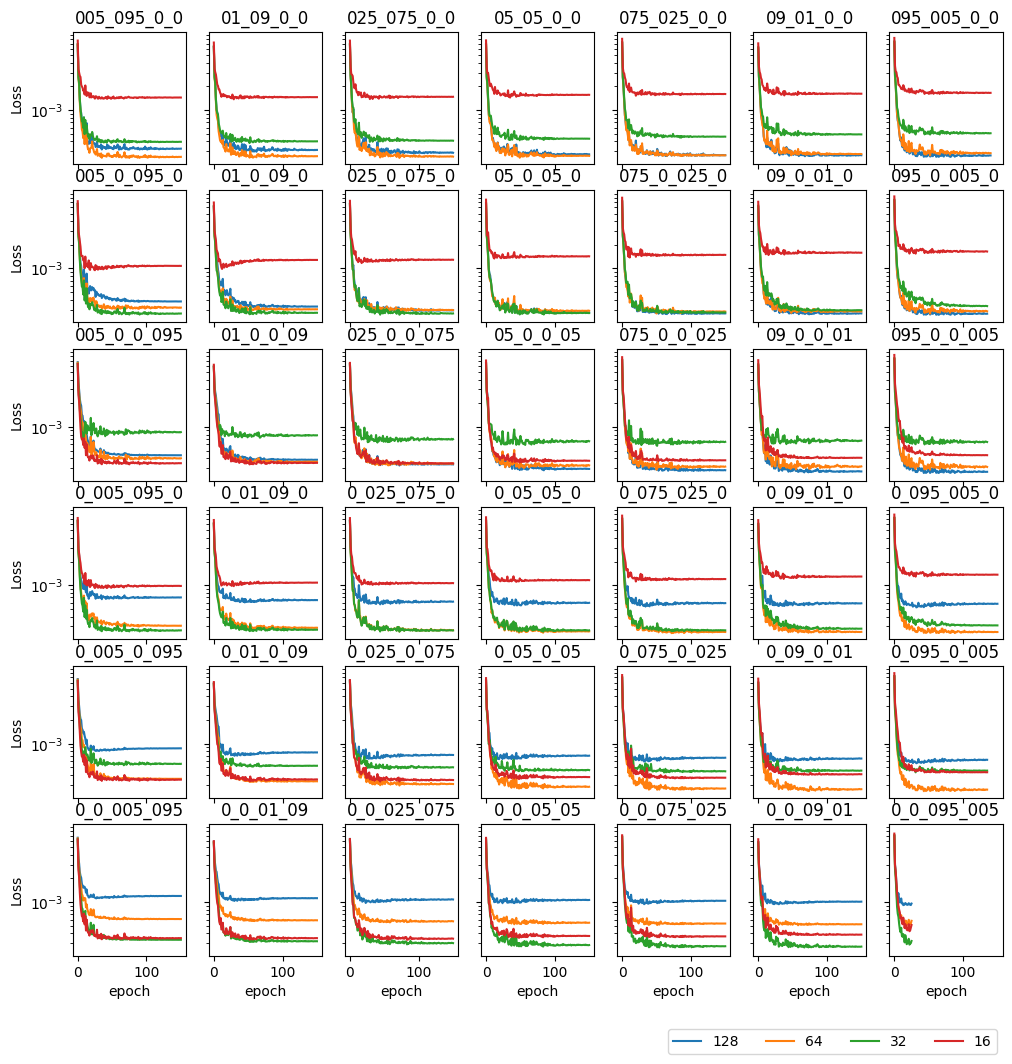

In [72]:
fig, axes = plt.subplots(
    nrows=6, ncols=7, sharey=True, sharex='col', figsize=(12, 12)
)

dataset_name = 'darcy_pdebench'
loss = 'mse'
(
    model_name,
    in_channels,
    out_channels,
    initial_steps,
    loss,
    batch_size,
    lr,
    wd,
    pinn_loss_weight,
) = get_dataset_info(dataset_name, 'mse')
# lr = str(lr).replace('.','')
if dataset_name == 'darcy_pdebench':
    img_sizes = [128, 64, 32, 16]
    img_size = 128
    max_mode = img_size // 2


final_ckpts = []

res_ratios = [
    '[0.1,0.1,0.1,0.7]',
    '[0.1,0,0,0.9]',
    '[0.02,0.03,0.05,0.9]',
]
for x_idx, rat in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]):
    for y_idx, (first_idx, second_idx) in enumerate(
        [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    ):
        ratio = [0, 0, 0, 0]
        ratio[first_idx] = rat
        ratio[second_idx] = round(1 - rat, 2)
        res_ratio = str_from_res(ratio)  # str(ratio).replace(" ","")
        ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_multi_{res_ratio}'
        ckpt_dir = ckpt_dir.replace('.', '')
        ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
        ckpt_name = f'{ckpt_pth}/train_stats.csv'

        if not os.path.exists(ckpt_name):
            print('does not exist: ', ckpt_dir)
            continue
        df = pd.read_csv(ckpt_name)
        df['res_ratio'] = res_ratio
        final_ckpts.append(df[df.epoch == 150])
        for res in range(4):
            ylabel = f'test_res_{res}'
            sns.lineplot(
                df,
                x='epoch',
                y=ylabel,
                label=f'{img_sizes[res]}',
                ax=axes[y_idx, x_idx],
            )
            axes[y_idx, x_idx].get_legend().remove()
            axes[y_idx, x_idx].set_yscale('log')
            axes[y_idx, x_idx].set_title(res_ratio)
            axes[y_idx, x_idx].set_ylabel('Loss')

plt.legend(bbox_to_anchor=(-0.5, -0.5), loc='upper center', ncols=4)

In [15]:
final_ckpt = pd.concat(final_ckpts)
final_ckpt['avg'] = final_ckpt[
    ['test_res_0', 'test_res_1', 'test_res_2', 'test_res_3']
].mean(axis=1)
final_ckpt

epoch  train_loss  train_time  test_res_0  test_res_1  test_res_2  \
150    150    0.000288    1.670186    0.000392    0.000318    0.000327   
150    150    0.000285    1.745384    0.000381    0.000360    0.000781   
150    150    0.000286    0.912009    0.000516    0.000349    0.000346   

     test_res_3         res_ratio       avg  
150    0.000356     [01,01,01,07]  0.000348  
150    0.000348       [01,0,0,09]  0.000468  
150    0.000349  [002,003,005,09]  0.000390

# Generalization Across Turbulence Scales

NS trained at low turbulence, evaluated at high-turbulence

# OLD FIGS

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


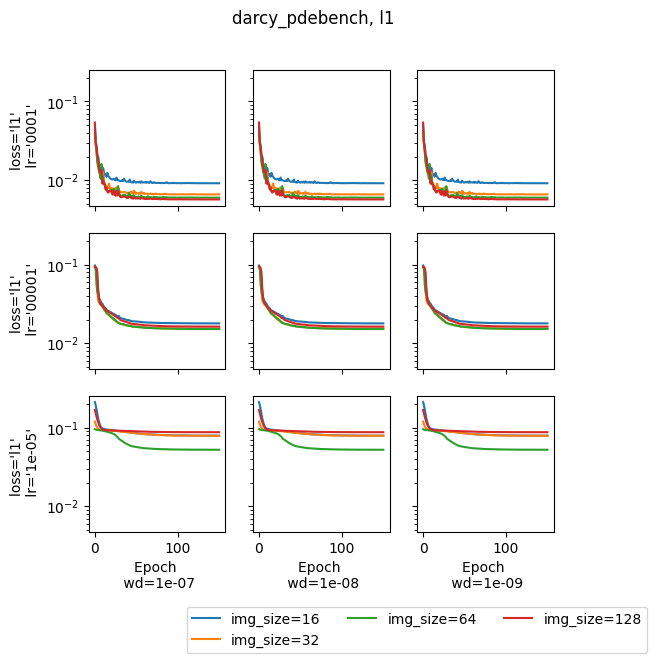

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


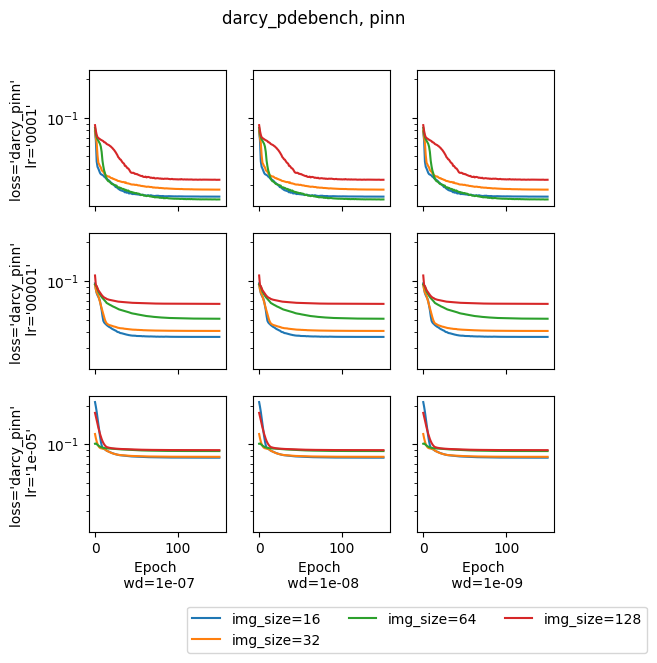

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


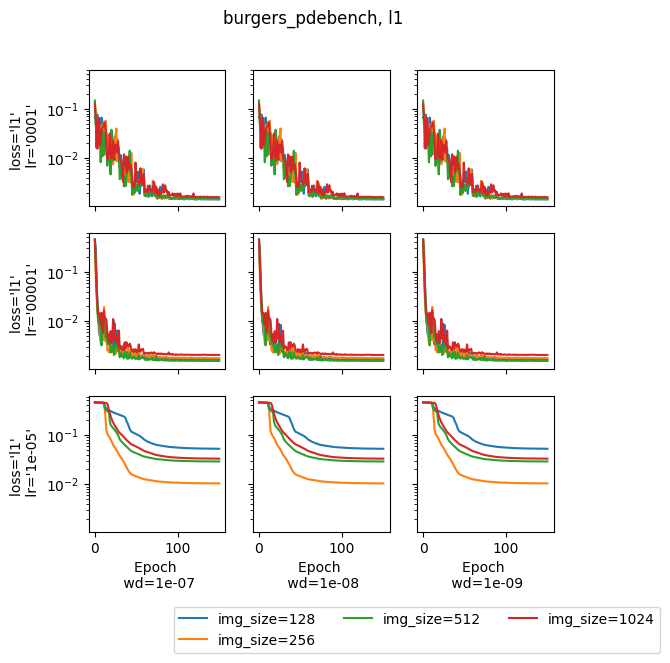

/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


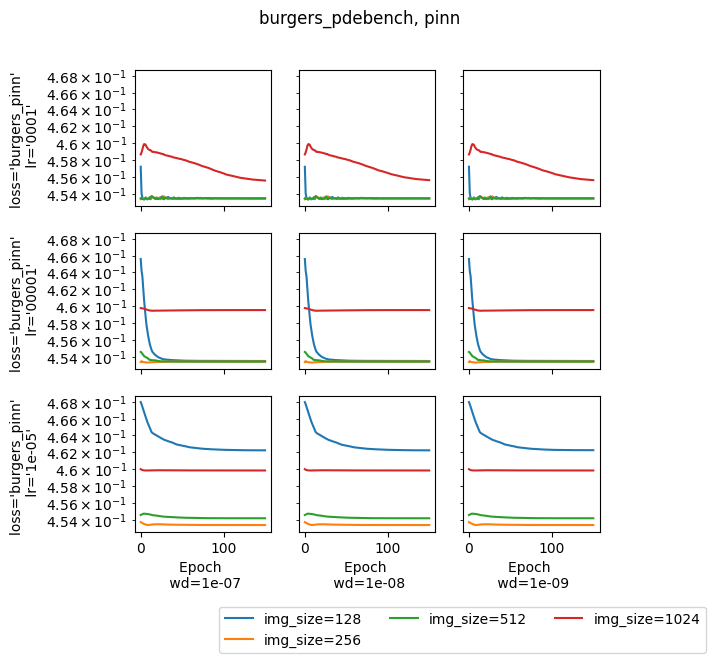

does not exist:  0001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_l1_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


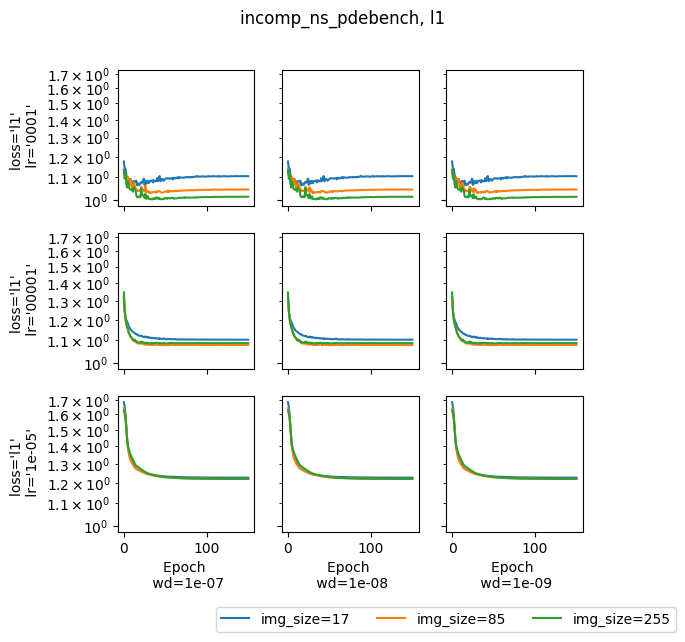

does not exist:  0001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  0001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  00001_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-07_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-08_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10
does not exist:  1e-05_1e-09_15_05_incomp_ns_pinn_4_incomp_ns_pdebench_-1_-1_510_255_FNO2D_10_10


/tmp/ipykernel_951742/8617956.py:68: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


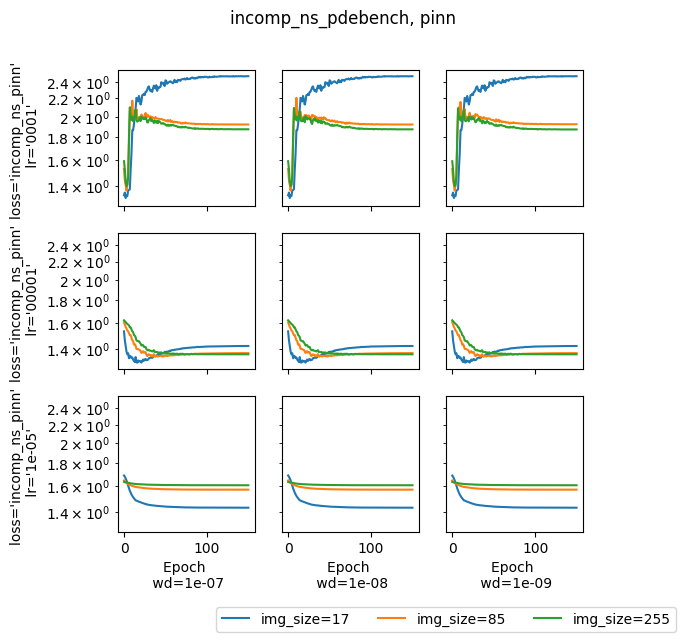

finished_exp=198, total_exp=216, 0.9166666666666666 %


In [3]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
for dataset_name in [
    'darcy_pdebench',
    'burgers_pdebench',
    'incomp_ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    initial_steps = 10

    if dataset_name == 'darcy_pdebench':
        img_sizes = [16, 32, 64, 128]
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_sizes = [128, 256, 512, 1024]
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    if dataset_name == 'incomp_ns_pdebench':
        img_sizes = [17, 85, 255, 510]
        pinn_loss_name = 'incomp_ns_pinn'
        batch_size = 4

    for loss_type in ['l1', 'pinn']:
        loss = 'l1'
        if loss_type == 'pinn':
            loss = pinn_loss_name
        fig, axes = plt.subplots(
            nrows=3, ncols=3, sharey=True, sharex='col', figsize=(6, 6)
        )
        for y_idx, lr in enumerate(['0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-07, 1e-08, 1e-09]):
                for color_idx, img_size in enumerate(img_sizes):
                    max_mode = img_size // 2
                    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{img_size}_{max_mode}_{model_name}_{in_channels}_{initial_steps}'
                    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
                    ckpt_name = f'{ckpt_pth}/train_stats.csv'
                    total_exp += 1
                    if not os.path.exists(ckpt_name):
                        print('does not exist: ', ckpt_dir)
                        continue
                    df = pd.read_csv(ckpt_name)
                    for ylabel in [
                        #'train_loss',
                        'test',
                    ]:
                        if 150 in df['epoch']:
                            finished_exp += 1
                        sns.lineplot(
                            df,
                            x='epoch',
                            y=ylabel,
                            label=f'{img_size=}',
                            ax=axes[y_idx, x_idx],
                        )
                        axes[y_idx, x_idx].get_legend().remove()
                        axes[y_idx, x_idx].set_yscale('log')

                if y_idx == 2:
                    axes[y_idx, x_idx].set_xlabel(f'Epoch \n {wd=}')
                if x_idx == 0:
                    axes[y_idx, x_idx].set_ylabel(f'{loss=} \n {lr=}')

        plt.legend(bbox_to_anchor=(0, -0.5), loc='upper center', ncols=3)
        plt.tight_layout()
        fig.suptitle(f'{dataset_name}, {loss_type}')
        plt.show()
print(f'{finished_exp=}, {total_exp=}, {finished_exp / total_exp} %')

# (BE CAREFUL W/ this is could override things) Recover stats

In [19]:
from operator_aliasing.train.train import test_model


def recompute_train_test_stats(
    dataset_name,
    filter_lim,
    downsample_dim,
    initial_steps,
    model_name,
    seed,
    batch_size,
    train_resolutions,
    in_channels,
    out_channels,
    max_mode,
    pinn_loss_weight,
):
    stats = pd.DataFrame(columns=['epoch', 'train_loss', 'test', 'train_time'])
    darcy_forcing_term = 1.0
    burger_viscosity = 0.001
    # load relavent dataset
    train_loader, test_loaders = get_data(
        dataset_name=dataset_name,
        filter_lim=filter_lim,
        img_size='n/a',
        downsample_dim=downsample_dim,
        train=True,
        initial_steps=initial_steps,
        model_name=model_name,
        darcy_forcing_term=darcy_forcing_term,
        burger_viscosity=burger_viscosity,
        seed=seed,
        batch_size=batch_size,
        resolution_ratios=eval(train_resolutions),
        test_res='single',
    )

    # train_resolutions =
    # iterate thought all ckpts
    ckpt_dir = f'{lr}_{wd}_15_05_{loss}_{batch_size}_{dataset_name}_-1_-1_{max_mode}_{model_name}_{in_channels}_{out_channels}_{pinn_loss_weight}_{initial_steps}_single_{train_resolutions}'
    ckpt_pth = f'{ckpt_path}/{ckpt_dir}/'
    model = get_model(
        model_name=model_name,
        max_modes=max_mode,
        hidden_channels=32,
        in_channels=in_channels,
        out_channels=out_channels,
    ).to(device)

    print(ckpt_dir)
    for epoch in range(0, 155, 5):
        ckpt_file = f'{ckpt_pth}/{epoch}_ckpt.pth'
        if not os.path.exists(ckpt_file):
            return
        ckpt_dict = torch.load(
            ckpt_file,
            weights_only=False,
        )
        model.load_state_dict(ckpt_dict['model_state_dict'])
        model = model.to(device)
        model = model.eval()

        # compute train/test loss
        train_loss = test_model(
            model,
            {'train': train_loader},
            device,
            initial_steps,
        )
        test_loss = test_model(
            model,
            test_loaders,
            device,
            initial_steps,
        )

        stats.loc[len(stats)] = [
            epoch,
            train_loss['train'],
            test_loss['test'],
            None,
        ]

    print(stats)
    stats.to_csv(f'{ckpt_pth}/train_stats.csv', index=False)
    return

In [8]:
# Check if all experiments have finished
total_exp = 0
finished_exp = 0
seed = 0
learning_rates = {'001': 1e-2, '0001': 1e-3, '00001': 1e-4, '1e-05': 1e-5}
pinn_weights = {'05': 0.5, '025': 0.25, '01': 0.1}
summary_stats = pd.DataFrame(
    columns=['data', 'loss', 'lr', 'wd', 'pinn_loss_weight', 'test']
)
for dataset_name in [
    #'darcy_pdebench',
    'burgers_pdebench',
    #'incomp_ns_pdebench',
    #'ns_pdebench',
]:
    model_name = 'FNO2D'
    in_channels = 10
    out_channels = 1
    initial_steps = 10
    # if dataset_name == 'incomp_ns_pdebench':

    # incomp_ns args
    img_size = 255
    pinn_loss_name = 'incomp_ns_pinn'
    batch_size = 4

    if dataset_name == 'ns_pdebench':
        img_size = 256
        pinn_loss_name = 'n/a'
        batch_size = 4
        # num time steps * channels:
        in_channels = 40
        # num channels:
        out_channels = 4

    if dataset_name == 'darcy_pdebench':
        img_size = 64
        pinn_loss_name = 'darcy_pinn'
        batch_size = 128
        in_channels = 1
        initial_steps = 1

    if dataset_name == 'burgers_pdebench':
        img_size = 512
        pinn_loss_name = 'burgers_pinn'
        batch_size = 64
        model_name = 'FNO1D'

    for loss_type in ['mse', 'pinn']:
        loss = loss_type
        if loss_type == 'pinn':
            loss = pinn_loss_name
        if loss == 'n/a':
            continue
        for y_idx, lr in enumerate(['001', '0001', '00001', '1e-05']):
            for x_idx, wd in enumerate([1e-05, 1e-06, 1e-07]):
                pinn_loss_weights = ['05']
                if 'pinn' in loss_type:
                    pinn_loss_weights += ['025', '01']
                for pinn_loss_weight in pinn_loss_weights:
                    max_mode = img_size // 2

                # recompute_train_test_stats(dataset_name, -1, -1, initial_steps, model_name, seed, batch_size, '[0,1,0,0]', in_channels, out_channels, max_mode, pinn_loss_weight)